In [42]:
import ray
from ray import tune
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import  seaborn as sns
import learning_lidar.utils.vis_utils as vis_utils
import matplotlib as mpl
sns.set_palette(sns.color_palette("tab10"))

plt.rcParams['figure.dpi'] = vis_utils.FIGURE_DPI
plt.rcParams['savefig.dpi'] = vis_utils.SAVEFIG_DPI

sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('text', usetex=False)
#plt.rc('font', family='serif')
#plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

In [2]:
def extract_powers(row, in_channels):
    powers = eval(row['powers']) if type(row['powers'])==str else None
    pow_y = np.array(powers[1])[0] if type(powers)==tuple else None
    pow_x = np.array(powers[0]) if type(powers)==tuple else None
    pow_xi = np.zeros(in_channels)
    if type(pow_x)==np.ndarray:
        for chan in range(in_channels):
            pow_xi[chan] = pow_x[chan] if  (len(pow_x)>=chan+1) else None
    else:
        for chan in range(in_channels):
            pow_xi[chan] = None
    return [pow_y,*pow_xi]

In [3]:
base_folder = os.path.dirname(os.path.dirname(os.path.abspath(os.curdir)))
results_folder = os.path.join(base_folder, 'results')
results_folder

'/home/shubi/PycharmProjects/learning_lidar/results'

# postprocessing LCNET results from jason state files saved in  `runs_board.xlsx`

In [44]:
runs_df = pd.read_excel(os.path.join(results_folder,'runs_board.xlsx'),engine='openpyxl')
runs_df = runs_df[runs_df.include==True][runs_df.state!='PENDING']
runs_df

<ipython-input-44-5cecbceb7a08>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  runs_df = runs_df[runs_df.include==True][runs_df.state!='PENDING']


hidden_sizes bsize FC_sizes     LR  \
34                  [3,3,3,3],[4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
35  [4,4,4,1],[4,4,4,2],[4,4,4,3],[5,5,5,1],[5,5,5...    32  [16,32]  0.001   
36                    [3,3,3,1],[3,3,3,2], [4,16,8,2]    32  [16,32]  0.001   
37                    [4,8,16,2], [4,8,8,2],[2,4,8,2]    32  [16,32]  0.001   
38                  [3,3,3,3],[4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
39                  [3,3,3,3],[4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
41                  [3,3,3,3],[4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
43                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
44                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
45                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
46                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
50                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
51                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
52                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
53                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
54                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
55                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
67                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
68                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
69                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
70                  [4,4,4,4], [5, 5, 5, 5],[6,6,6,6]    32  [16,32]  0.001   
71                  [4,4,4,4], [5, 5, 5, 5],[6,6,6,6]    32  [16,32]  0.001   
75                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
79                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
80                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
81                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
82                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
83                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
84                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   
85                            [4,4,4,4], [5, 5, 5, 5]    32  [16,32]  0.001   

             dfilter                                              power  \
34                 0  ([0.5,0.25],[0.5]),([0.5,0.5],[0.5]), ([0.5,-0...   
35                 0             ([0.5,-0.25],[0.5]),([0.5,0.25],[0.5])   
36                 0             ([0.5,-0.25],[0.5]),([0.5,0.25],[0.5])   
37                 0             ([0.5,-0.25],[0.5]),([0.5,0.25],[0.5])   
38               355            ([0.5, 1], [0.5]), ([0.5,-0.27], [0.5])   
39               532           ([0.5, 1], [0.5]), ([0.5,-0.265], [0.5])   
41              1064            ([0.5, 1], [0.5]), ([0.5,-0.11], [0.5])   
43    [355,532,1064]        ([0.5, 1,1 ], [0.5]),([0.5, 1,0.5 ], [0.5])   
44               355   ([0.5,-0.27,1 ], [0.5]),  ([0.5,-0.27,0.5 ], ...   
45               532   ([0.5,-0.265,1 ], [0.5]),  ([0.5,-0.27,0.5 ],...   
46              1064   ([0.5,-0.11,1 ], [0.5]),  ([0.5,-0.11,0.5 ], ...   
50               355            ([0.5, 1], [0.5]), ([0.5,-0.27], [0.5])   
51               532           ([0.5, 1], [0.5]), ([0.5,-0.265], [0.5])   
52              1064            ([0.5, 1], [0.5]), ([0.5,-0.11], [0.5])   
53               355                            ([0.5,-0.27,1 ], [0.5])   
54               532                           ([0.5,-0.265,1 ], [0.5])   
55              1064                            ([0.5,-0.11,1 ], [0.5])   
67    [355,532,1064]        ([0.5, 1,1 ], [0.5]),([0.5, 1,0.5 ], [0.5])   
68             [all]                                             FALSE    
69             [all]                                             FALSE    
70    [355,532,1

In [45]:
for idx,row in runs_df.iterrows():
    #row = runs_df.iloc[idx]
    try:
        state_fname = sorted(glob.glob(os.path.join( row.experiment_folder,r'experiment_state*.json')))[-1]
        analysis = tune.ExperimentAnalysis(state_fname)
        ignore_MARELoss = "MARELoss" in [row.field_to_ignore]
        analysis.default_metric = "MARELoss" if ignore_MARELoss else "MARELoss"
        analysis.default_mode="min"
        results_df = analysis.dataframe(metric="MARELoss", mode="min",)

        # update fields:
        if ignore_MARELoss:
            results_df["MARELoss"]=None

        # rename column names:
        cols = results_df.columns.values.tolist()
        new_cols = [col.replace('config/',"") for col in cols]
        dict_cols ={}
        for col,new_col in zip(cols, new_cols):
            dict_cols.update({col:new_col})
        results_df = results_df.rename(columns= dict_cols)

        # update power values:
        # TODO: incase Adi Vainiger: use_bg : TRUE, range_corr and pow_x3 is not given --> use the default values to 0.5
        len_pow = len(results_df[results_df.use_power==True])
        len_no_pow = len(results_df[results_df.use_power==False])
        len_pows = len(results_df[results_df.use_power !=False])
        if len_no_pow>0:
            results_df.loc[results_df[results_df.use_power==False].index,'powers']= ''
        if len_pows!=len_pow:
            results_df.loc[results_df[results_df.use_power!=False].index,'powers']=results_df.use_power
            results_df.loc[results_df[results_df.use_power!=False].index,'use_power']=True
        else:
            results_df.loc[results_df[results_df.use_power==True].index,'powers']= '([0.5,0.5],[0.5])'

        # Update Notes
        note = row['note']
        results_df['note']= note if type(note)==str else 'ok'

        # drop irrelevant columns:
        drop_cols = [ 'time_this_iter_s', 'should_checkpoint', 'done',
                   'timesteps_total', 'episodes_total',
                   'experiment_id',  'timestamp',  'pid', 'hostname',
                   'node_ip', 'time_since_restore', 'timesteps_since_restore',
                   'iterations_since_restore']
        results_df.drop(columns=drop_cols,inplace=True)


        # reorganize columns:
        new_order = ['trial_id', 'date','time_total_s','training_iteration',
                     'loss', 'MARELoss',
                     'bsize', 'dfilter', 'dnorm','fc_size', 'hsizes', 'lr',
                     'ltype', 'source', 'use_bg', 'use_power','powers','note','logdir']
        results_df = results_df.reindex(columns=new_order)

        # keep index trial (especially for cases when trails are ignored)
        #results_df['idx']=results_df.index
        #new_cols = ['idx']
        #new_cols.extend(cols)
        #results_df = results_df.reindex(columns=new_cols)

        # remove irrelevant trials (e.g. when dnorm had wrong calculation)
        if row.trial_to_ignore is not np.nan:
            key,cond = eval(row.trial_to_ignore)
            results_df.drop(index=results_df[results_df[key]==cond].index,inplace=True)

        # save csv
        results_csv = os.path.join(analysis._experiment_dir, f'experiment_results.csv')
        results_df.to_csv(results_csv, index=False)

        # update csv path in main runs_board
        runs_df.loc[idx,'results_csv']=results_csv
        print(results_csv,idx)

    except:
        continue
# TODO: save runs_df with results_csv paths

# %%

#runs_df


# %% concatante all csv files with include =1

paths = [row['results_csv'] for idx,row in runs_df.iterrows()]
results_dfs=[pd.read_csv(path) for path in paths]
total_results = pd.concat(results_dfs,ignore_index=True)
# %%
total_results['fc_size'] = total_results.fc_size.apply(lambda x: eval(str(x))[0])
# update powers
in_channels = 3
res= total_results.apply(extract_powers,args=(in_channels,), axis=1, result_type='expand')
cols_powx = [f"pow_x{ind+1}" for ind in range(in_channels)]
res.rename( columns={0:'pow_y',1:cols_powx[0],2:cols_powx[1],3:cols_powx[2]},inplace=True)
total_results[res.columns.values] = res
total_results['powers'] = total_results.powers.apply(lambda x: eval(x) if type(x)==str else None)

# %%

hsizes=total_results.hsizes.apply(lambda x: eval(x))
total_results['u_hsize']=hsizes.apply(lambda x: all([(hi==x[0]) for hi in x])) # The test of changing the with at the last level , didn't show improvements

ValueError: Invalid file path or buffer object type: <class 'float'>

In [5]:
wavelengths=[]
filtered = total_results.dfilter.apply(lambda x:type(x)==str)
inds = total_results.dfilter[filtered].index
for ind,f in enumerate(filtered):
    if f:
        [filter_by,filter_values] = eval(total_results.dfilter.iloc[ind])
        if filter_by=='wavelength':
            wavelength = tuple(filter_values) if len(filter_values)>1 else filter_values[0]
        else:
            wavelength = 'all'
    else:
        wavelength='all'
    wavelengths.append(wavelength)

total_results['wavelength'] = wavelengths


In [6]:
total_results['overlap'] = total_results.note.str.contains('overlap')
total_results['note'] = total_results.note.str.replace('_overlap', '')


In [12]:
current_res_fname = os.path.join(results_folder,'curr_total_results.csv')
total_results.to_csv(current_res_fname)



In [4]:
current_res_fname = os.path.join(results_folder,'curr_total_results.csv')
total_results = pd.read_csv(current_res_fname)

In [36]:
analyse_results = total_results[total_results.training_iteration>=1]
analyse_results

Unnamed: 0     trial_id                 date  time_total_s  \
0             0  a823e_00006  2021-05-24_17-50-00    494.916774   
1             1  a823e_00009  2021-05-24_18-31-49    510.012694   
2             2  a823e_00001  2021-05-24_16-45-46    749.884229   
3             3  a823e_00010  2021-05-24_18-50-37    720.298314   
4             4  a823e_00003  2021-05-24_17-08-47    498.030632   
..          ...          ...                  ...           ...   
691         691  0974f_00007  2021-07-29_17-50-10    812.314487   
692         692     c7133802  2021-07-31_14-26-02    989.318416   
693         693  0974f_00015  2021-07-29_19-40-22    310.599689   
694         694  0974f_00006  2021-07-29_17-31-46    597.456719   
695         695  0974f_00011  2021-07-29_18-48-13    732.386760   

     training_iteration       loss  MARELoss  bsize                 dfilter  \
0                     7  17.733683  0.163039     32   ['wavelength', [355]]   
1                     7  20.801245  0.193428     32   ['wavelength', [355]]   
2                    11  15.935015  0.147268     32   ['wavelength', [355]]   
3                     9  10.688428  0.098870     32   ['wavelength', [355]]   
4                     7  12.791759  0.119082     32   ['wavelength', [355]]   
..                  ...        ...       ...    ...                     ...   
691                  11  22.062805  0.113109     32  ['wavelength', [1064]]   
692                  12  21.779844  0.112845     32  ['wavelength', [1064]]   
693                   4  25.405470  0.128798     32  ['wavelength', [1064]]   
694                   8  23.546019  0.120809     32  ['wavelength', [1064]]   
695                  10  19.440798  0.103000     32  ['wavelength', [1064]]   

     dnorm  ...                      powers         note  \
0    False  ...       ([0.5, -0.27], [0.5])   initial_db   
1    False  ...       ([0.5, -0.27], [0.5])   initial_db   
2    False  ...           ([0.5, 1], [0.5])   initial_db   
3    False  ...       ([0.5, -0.27], [0.5])   initial_db   
4    False  ...           ([0.5, 1], [0.5])   initial_db   
..     ...  ...                         ...          ...   
691  False  ...    ([0.5, -0.11, 1], [0.5])  extended_db   
692  False  ...  ([0.5, -0.11, 0.5], [0.5])  extended_db   
693  False  ...  ([0.5, -0.11, 0.5], [0.5])  extended_db   
694  False  ...    ([0.5, -0.11, 1], [0.5])  extended_db   
695  False  ...  ([0.5, -0.11, 0.5], [0.5])  extended_db   

                                                logdir pow_y pow_x1 pow_x2  \
0    C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5  -0.27   
1    C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5  -0.27   
2    C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5   1.00   
3    C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5  -0.27   
4    C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5   1.00   
..                                                 ...   ...    ...    ...   
691  C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5  -0.11   
692  C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5  -0.11   
693  C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5  -0.11   
694  C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5  -0.11   
695  C:\Users\addalin\Dropbox\Lidar\lidar_learning\...   0.5    0.5  -0.11   

     pow_x3 u_hsize wavelength overlap  
0       NaN    True        355   False  
1       NaN    True        355   False  
2       NaN    True        355   False  
3       NaN    True        355   False  
4       NaN    True        355   False  
..      ...     ...        ...     ...  
691     1.0    True       1064    True  
692     0.5    True       1064    True  
693     0.5    True       1064    True  
694     1.0    True       1064    True  
695     0.5    True       1064    True  

[696 rows x 27 columns]

In [ ]:
analyse_results = analyse_results[analyse_results.overlap==False]
analyse_results = analyse_results[analyse_results.u_hsize]

# %%
configs= []
use_bg = []
for idx,row in analyse_results.iterrows():
    hsize = eval(row.hsizes)[0]
    fcsize = row.fc_size
    if (hsize==4) and (fcsize==16):
        configs.append('A')
    elif (hsize==4) and (fcsize==32):
        configs.append('B')
    elif (hsize==5) and (fcsize==16):
        configs.append('C')
    elif (hsize==5) and (fcsize==32):
        configs.append('D')
    elif (hsize==6) and (fcsize==16):
        configs.append('E')
    elif (hsize==6) and (fcsize==32):
        configs.append('F')
    else:
        configs.append('Other')

    flag_bg = row.use_bg
    if type(flag_bg)==str:
        if flag_bg=='False' or flag_bg=='True':
            use_bg.append(eval(flag_bg))
        else :
            use_bg.append(flag_bg)
    else:
        use_bg.append(flag_bg)

analyse_results['config'] = configs
analyse_results['use_bg'] = use_bg

## 1. Choosing Learning rate
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


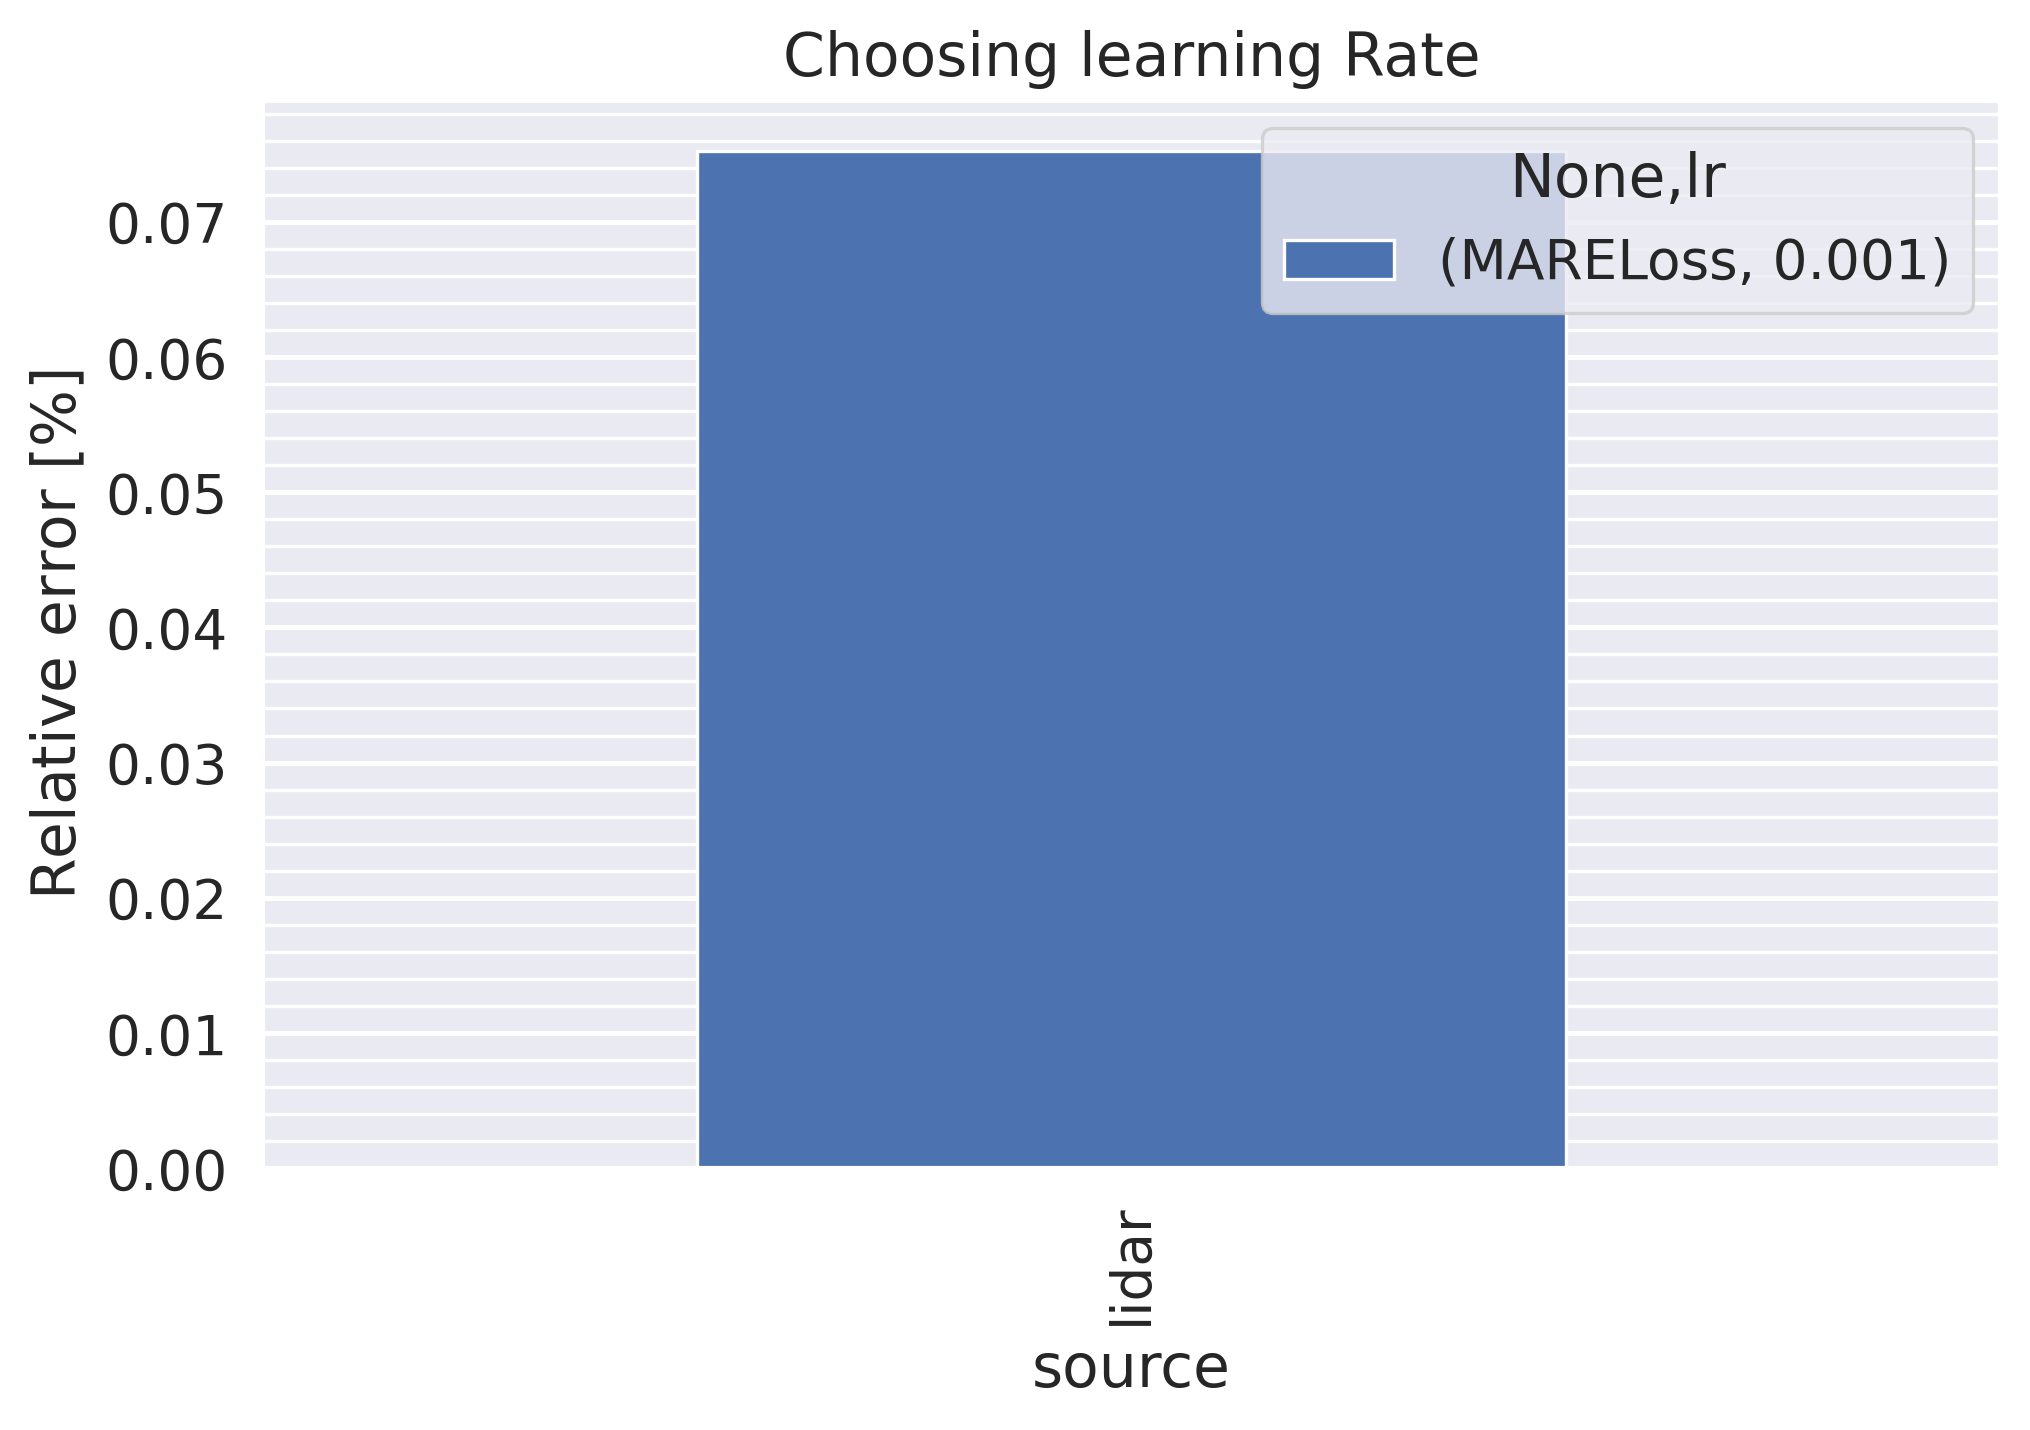

In [8]:
lidar_res = analyse_results[analyse_results.source=='lidar' ]
lidar_res = lidar_res[lidar_res.use_bg==False]
pow_lidar = lidar_res[(~lidar_res.dnorm & lidar_res.use_power ) ]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar[pow_lidar.bsize==32][pow_lidar.fc_size>4],#[pow_lidar.note=='ok'],
               values=['MARELoss'],
               columns= ['lr'],
               index=['source'],#'fc_size'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Choosing learning Rate')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
ax.set_ylabel(r'Relative error $[\%]$')
plt.tight_layout()
plt.show()

## 2. FC vs. hidden sizes
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar
> lr = 0.001 or lr = 0.005

In [9]:
all_wav = analyse_results #[analyse_results.wavelength=='all']
all_wavs_configABCD = all_wav[all_wav.config!='Other']

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
               [all_wavs_configABCD.use_bg!='range_corr']
               [all_wavs_configABCD.use_power!=False]
               [all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['pow_x1','pow_x2'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Searching for an optimal power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()


<ipython-input-10-501c6fc7fe31>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
<ipython-input-10-501c6fc7fe31>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]


TypeError: no numeric data to plot

<ipython-input-11-b23f3d78b36a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr'][all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],


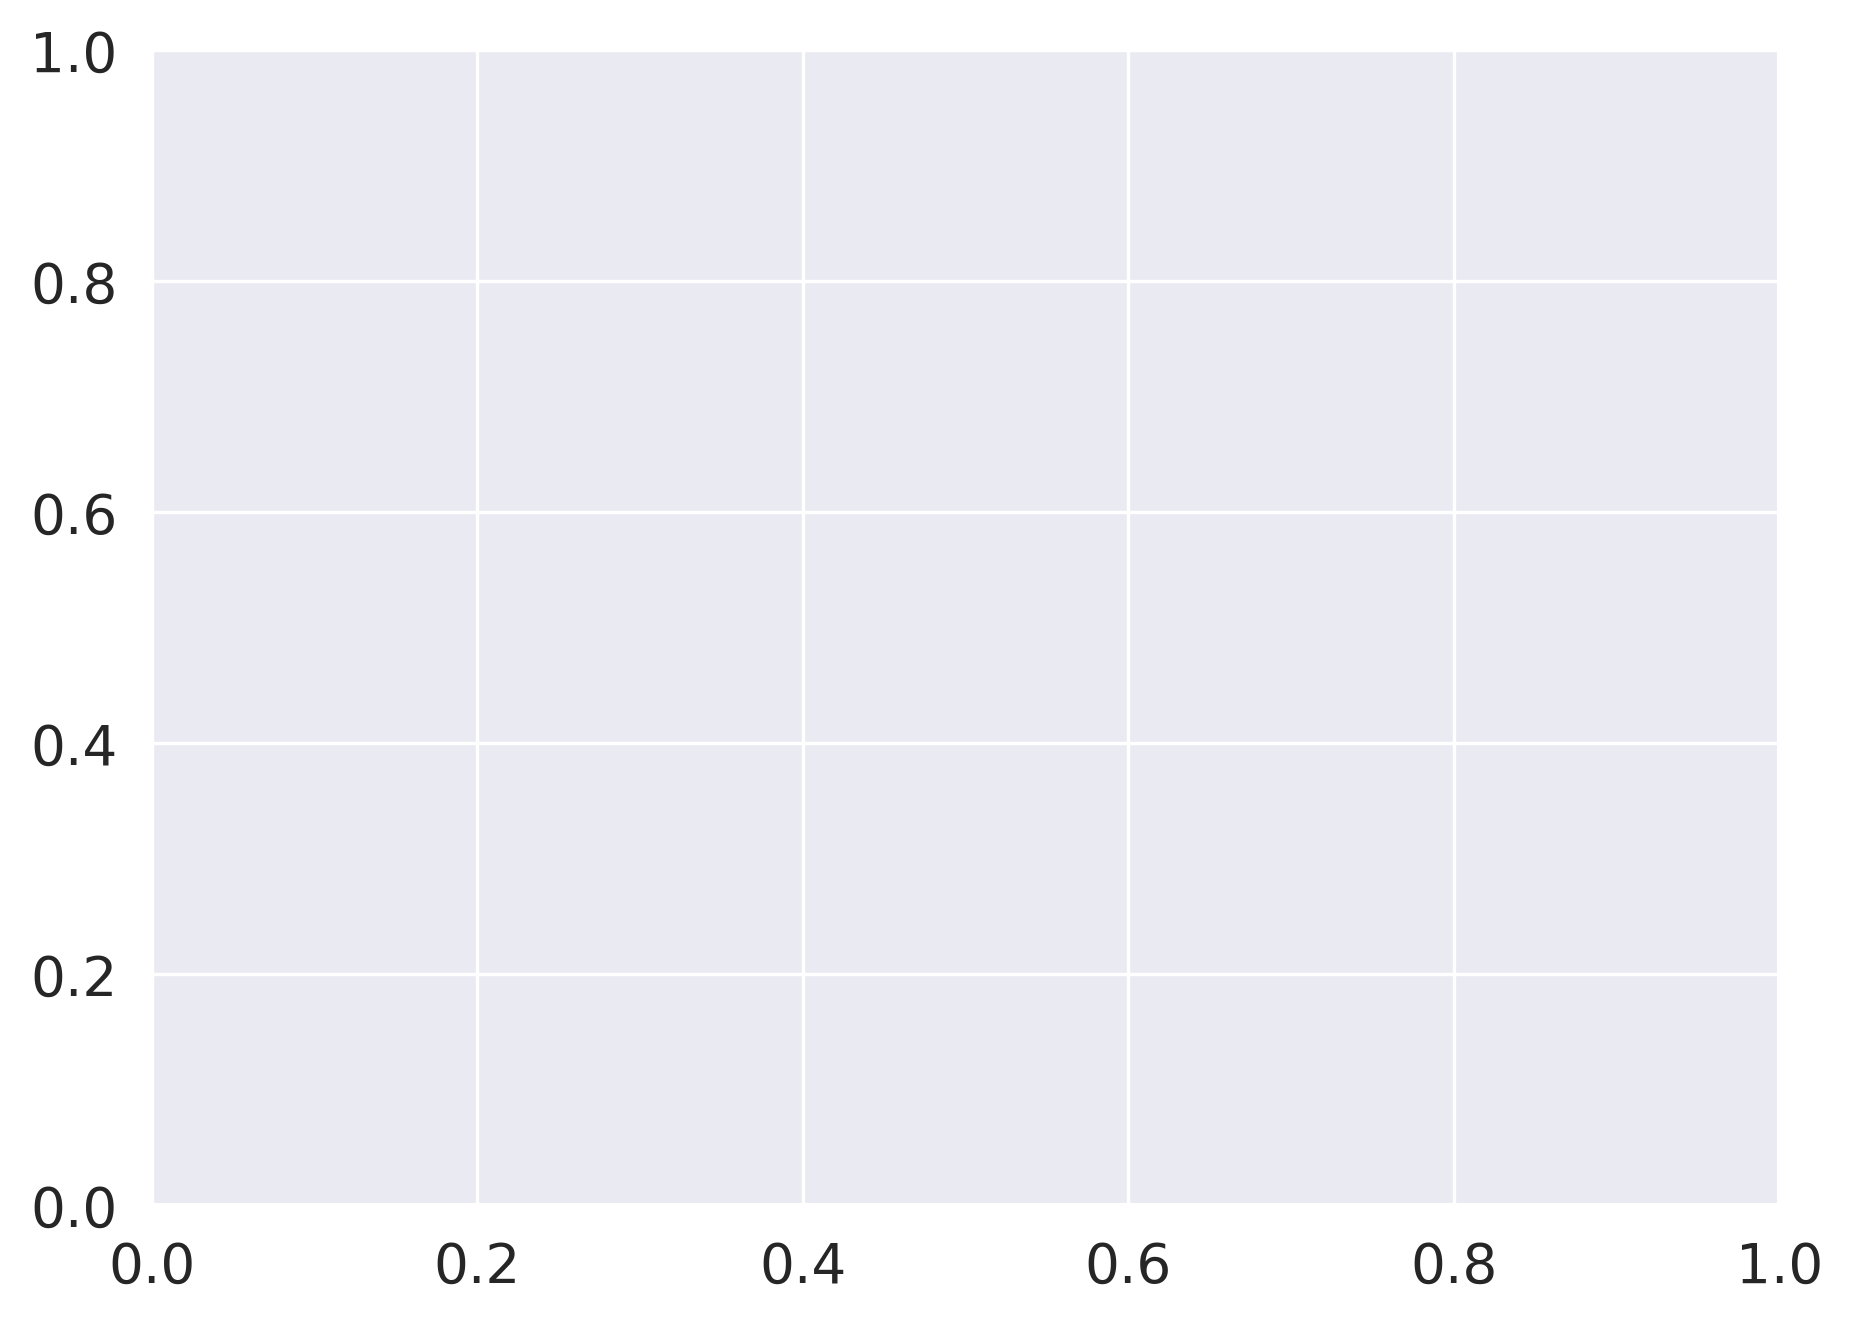

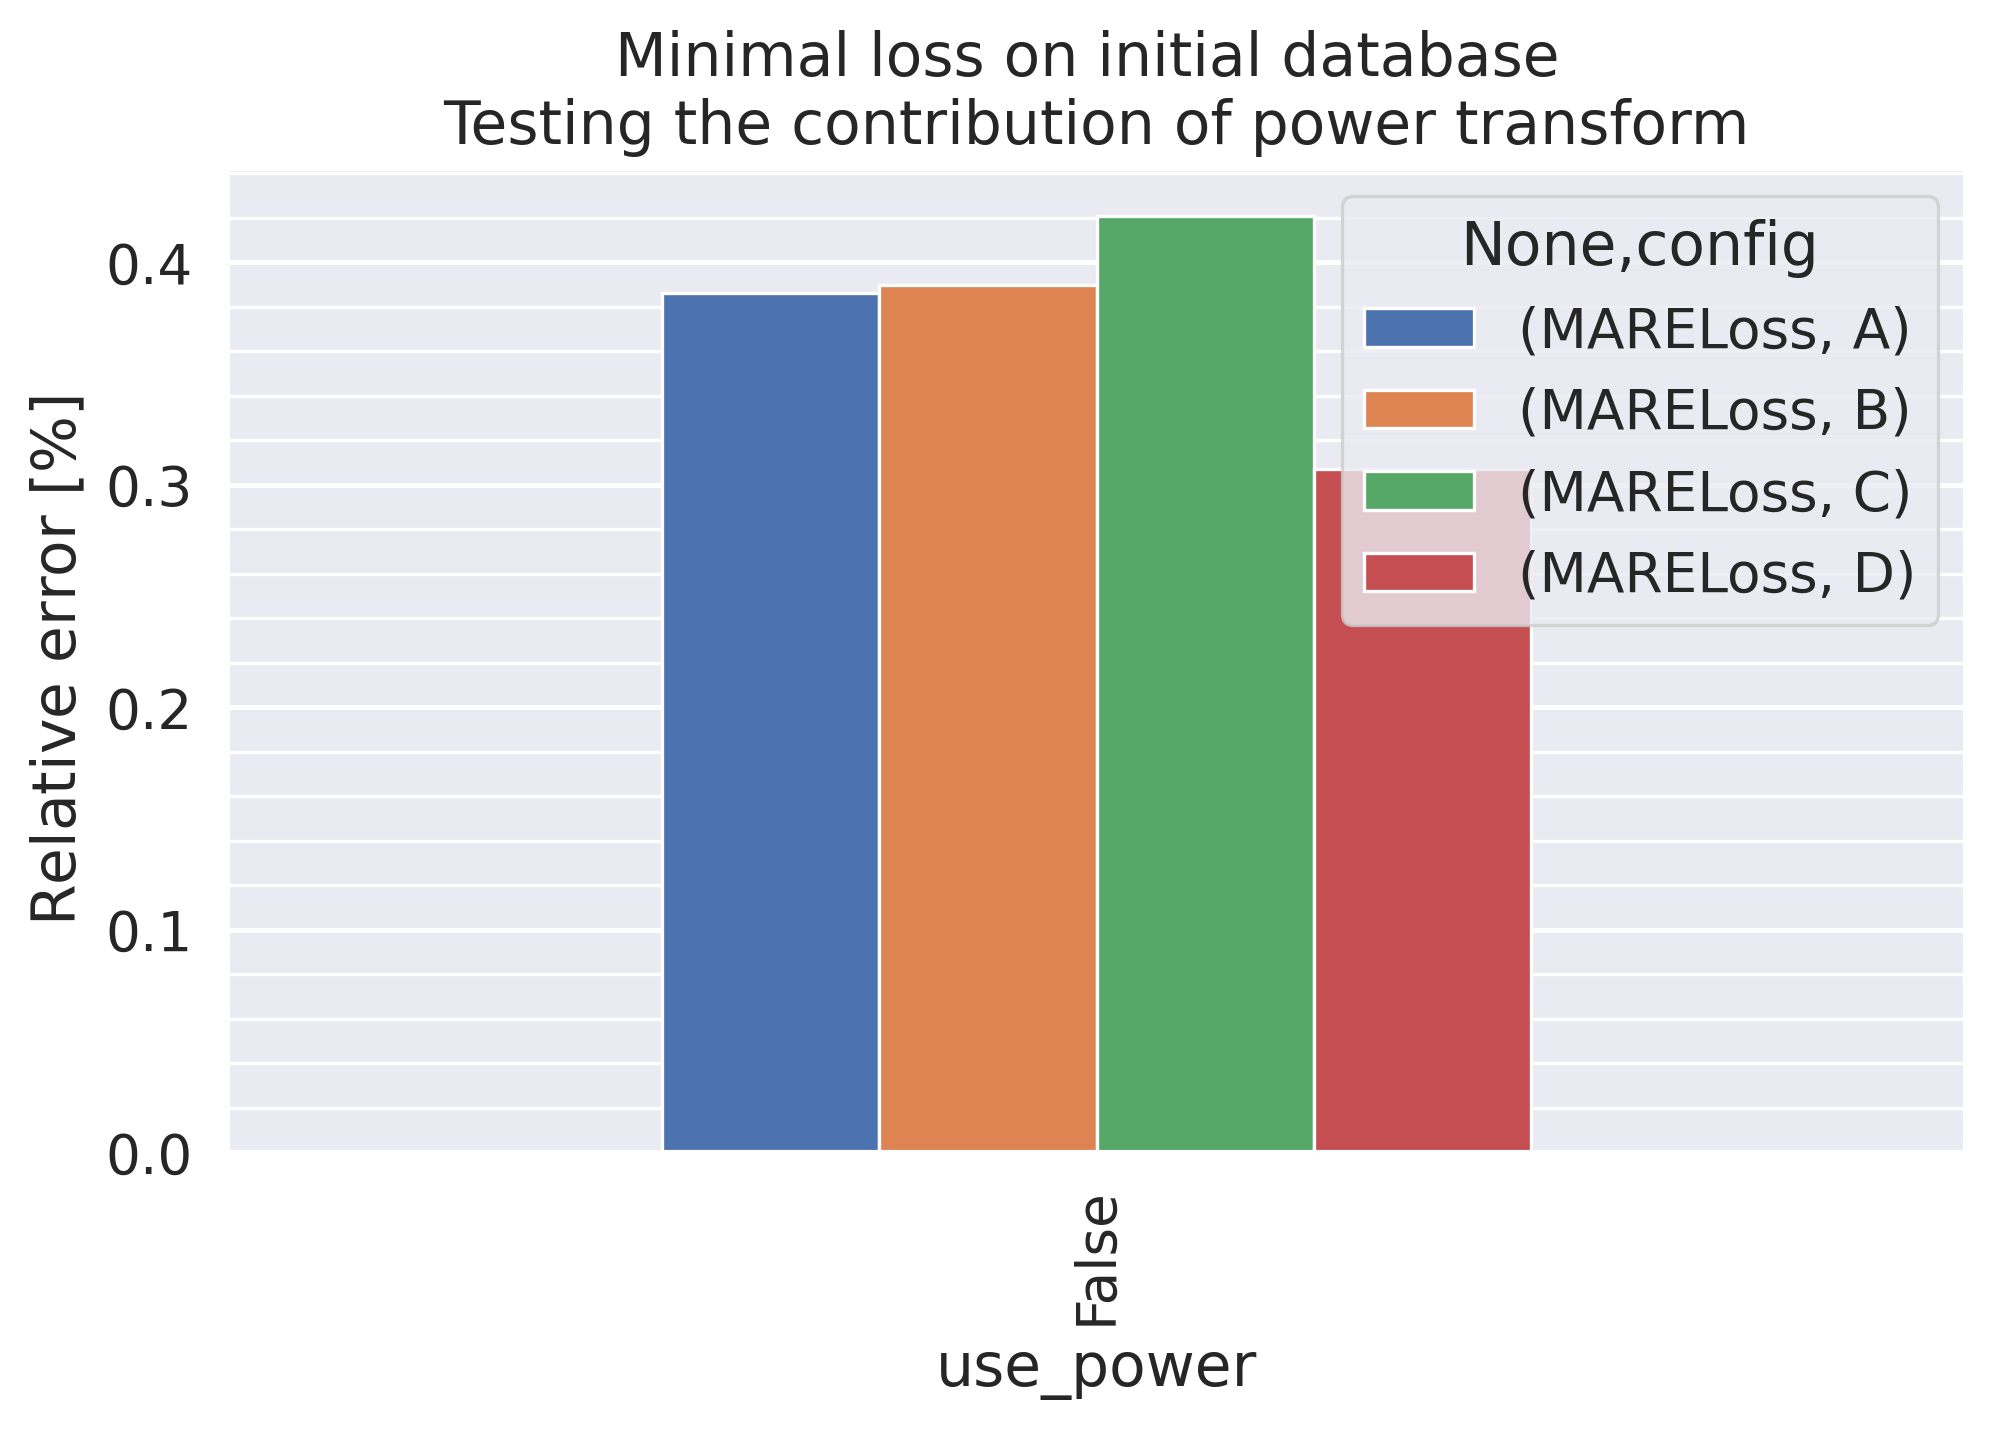

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True]
               [all_wavs_configABCD.use_bg!='range_corr']
               [all_wavs_configABCD.note=='initial_db']
               [all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_power'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the contribution of power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-12-a7e10f560838>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],


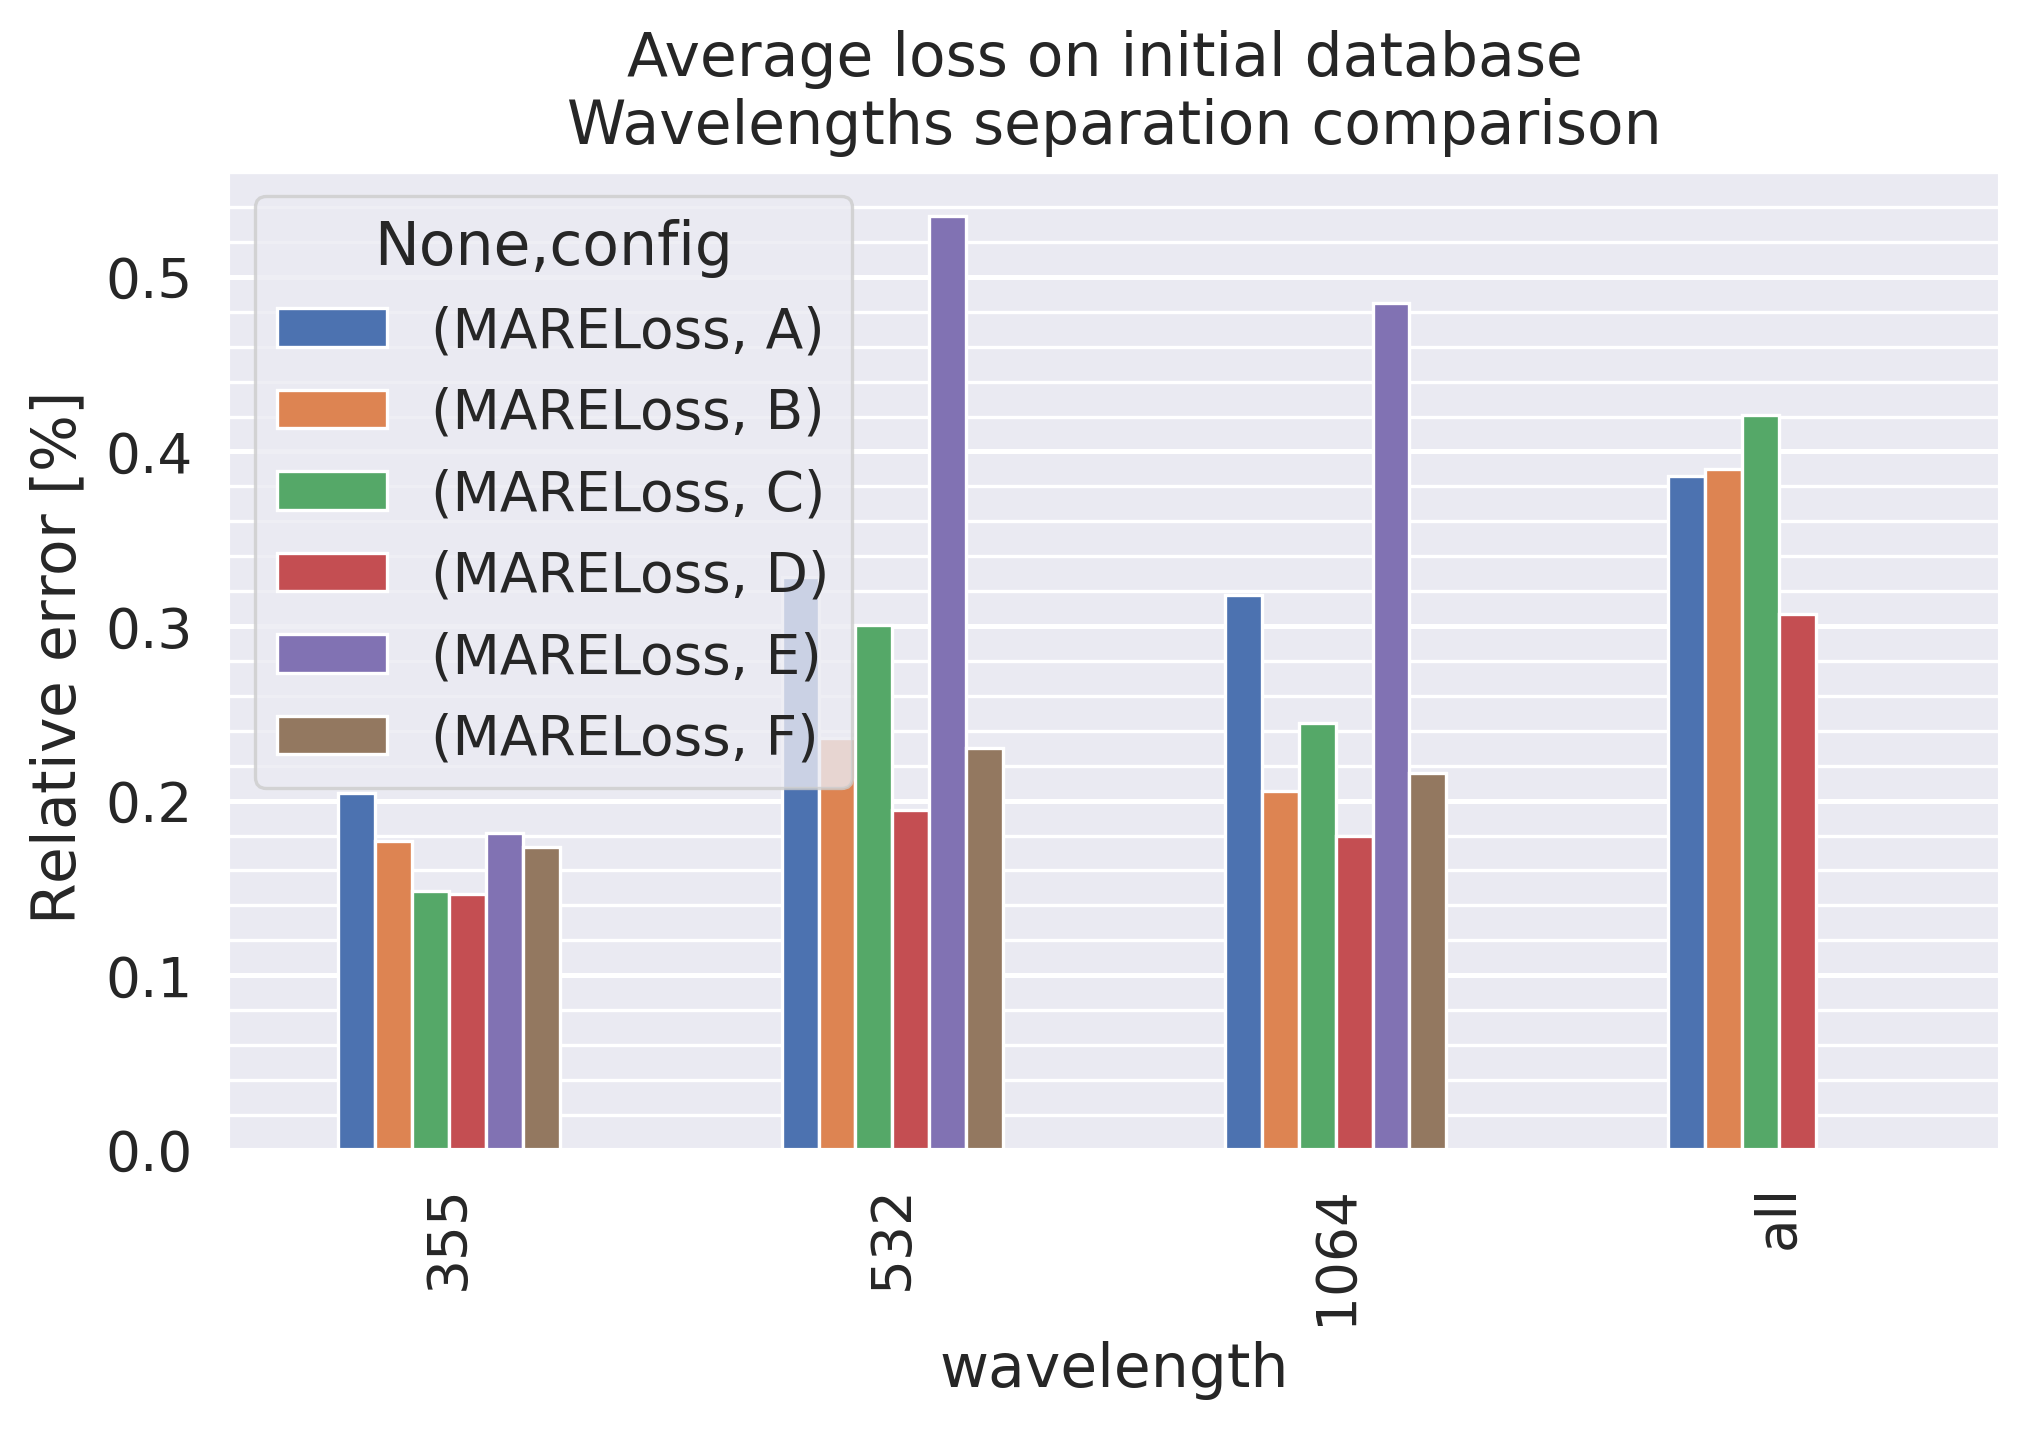

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='initial_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Wavelengths separation comparison ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-13-e12a5c488a91>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


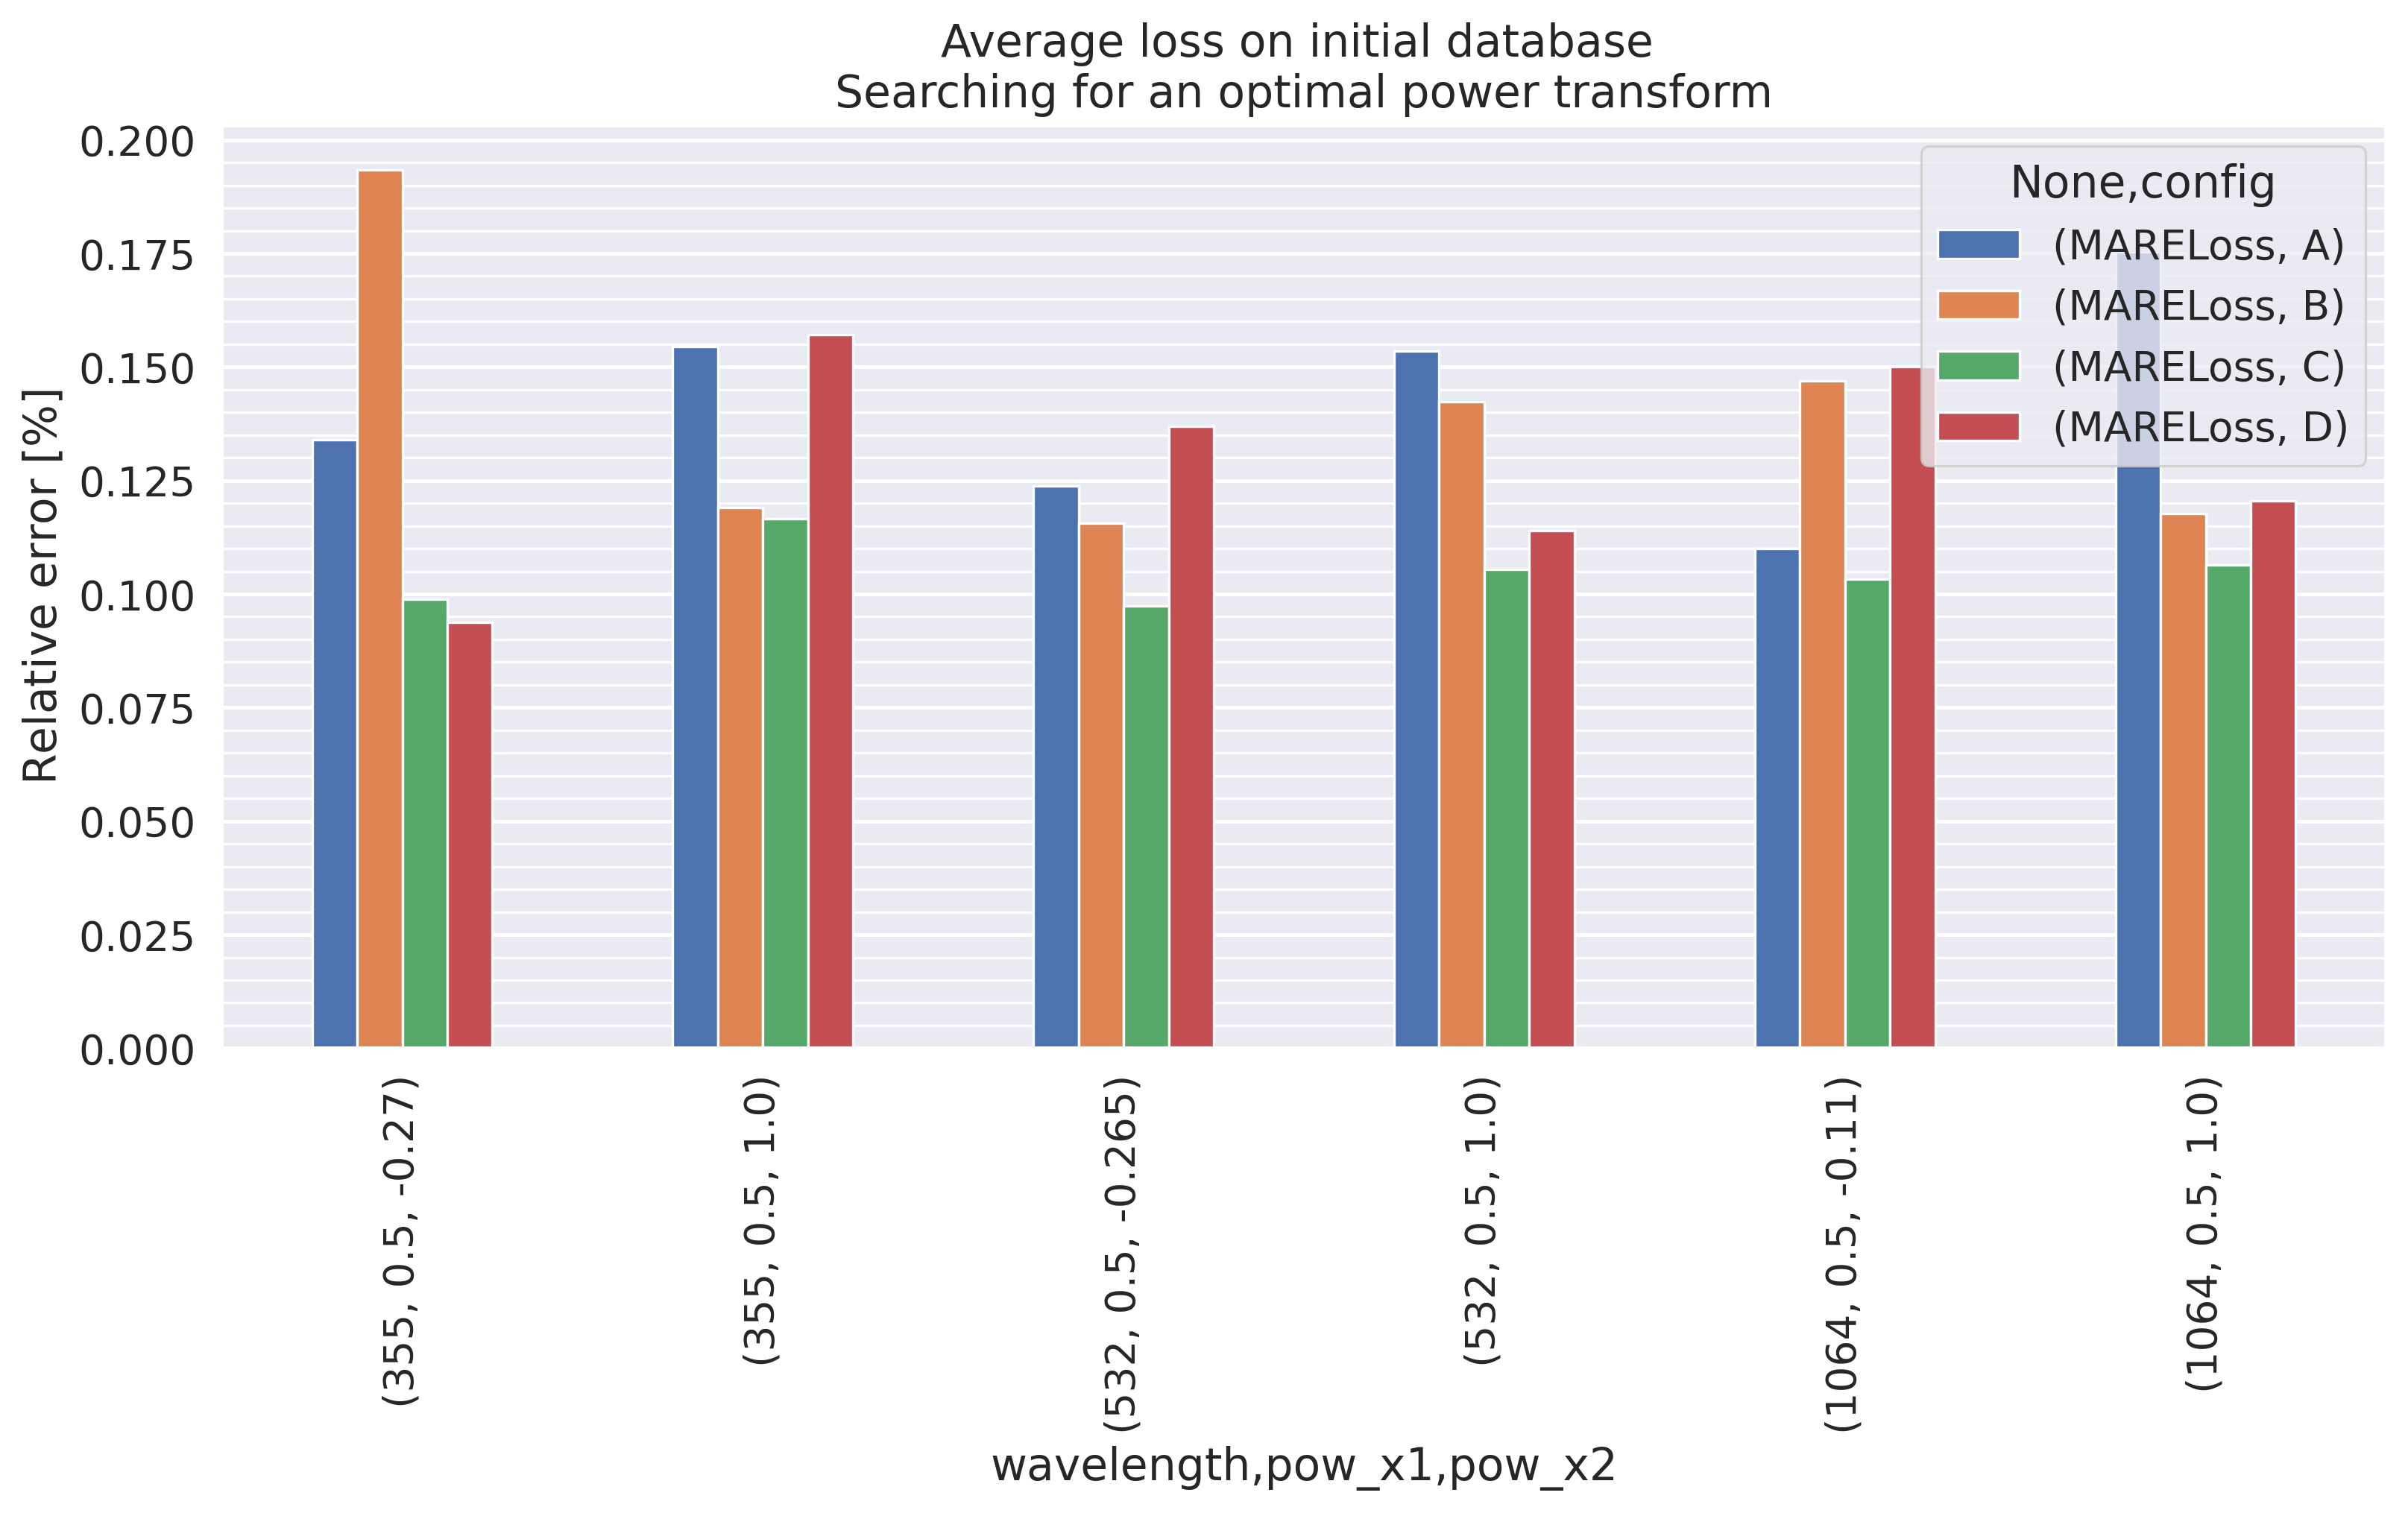

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x1','pow_x2'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Average loss on initial database \n Searching for an optimal power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-14-c9c96c5e9d22>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],


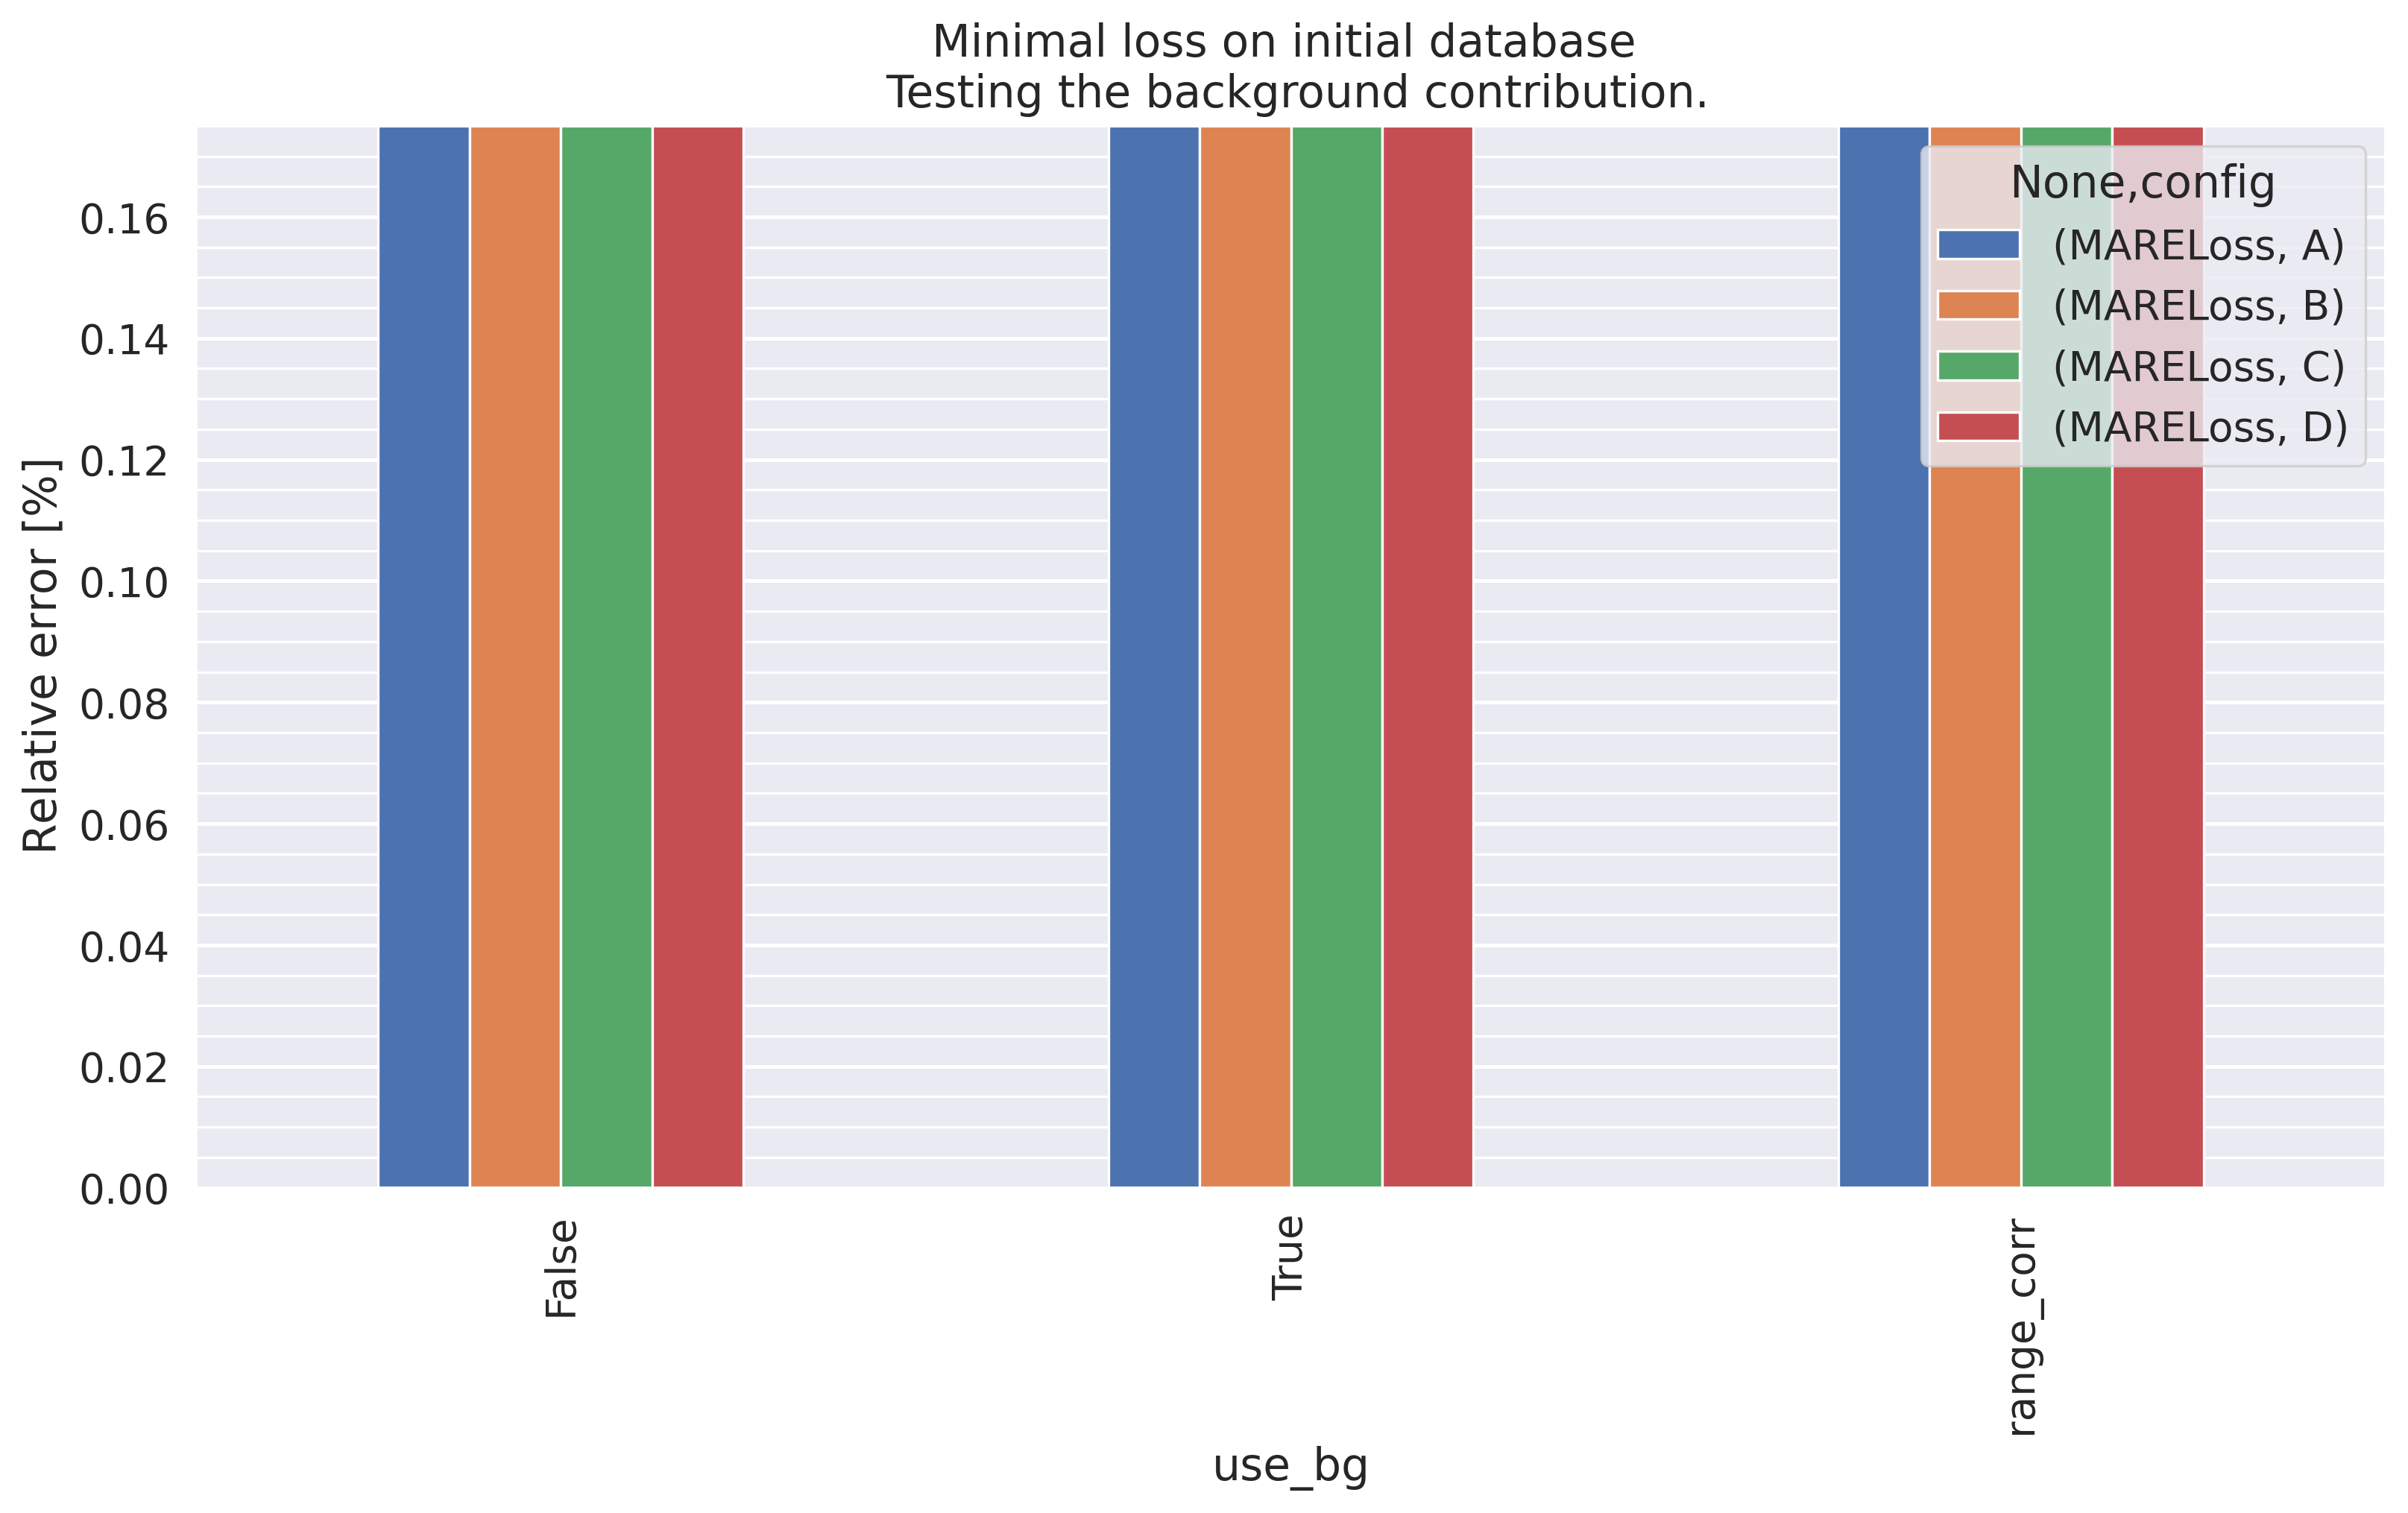

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the background contribution.')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.set_ylim([0.0, 0.175])
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-15-9bb2dd6716b6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],


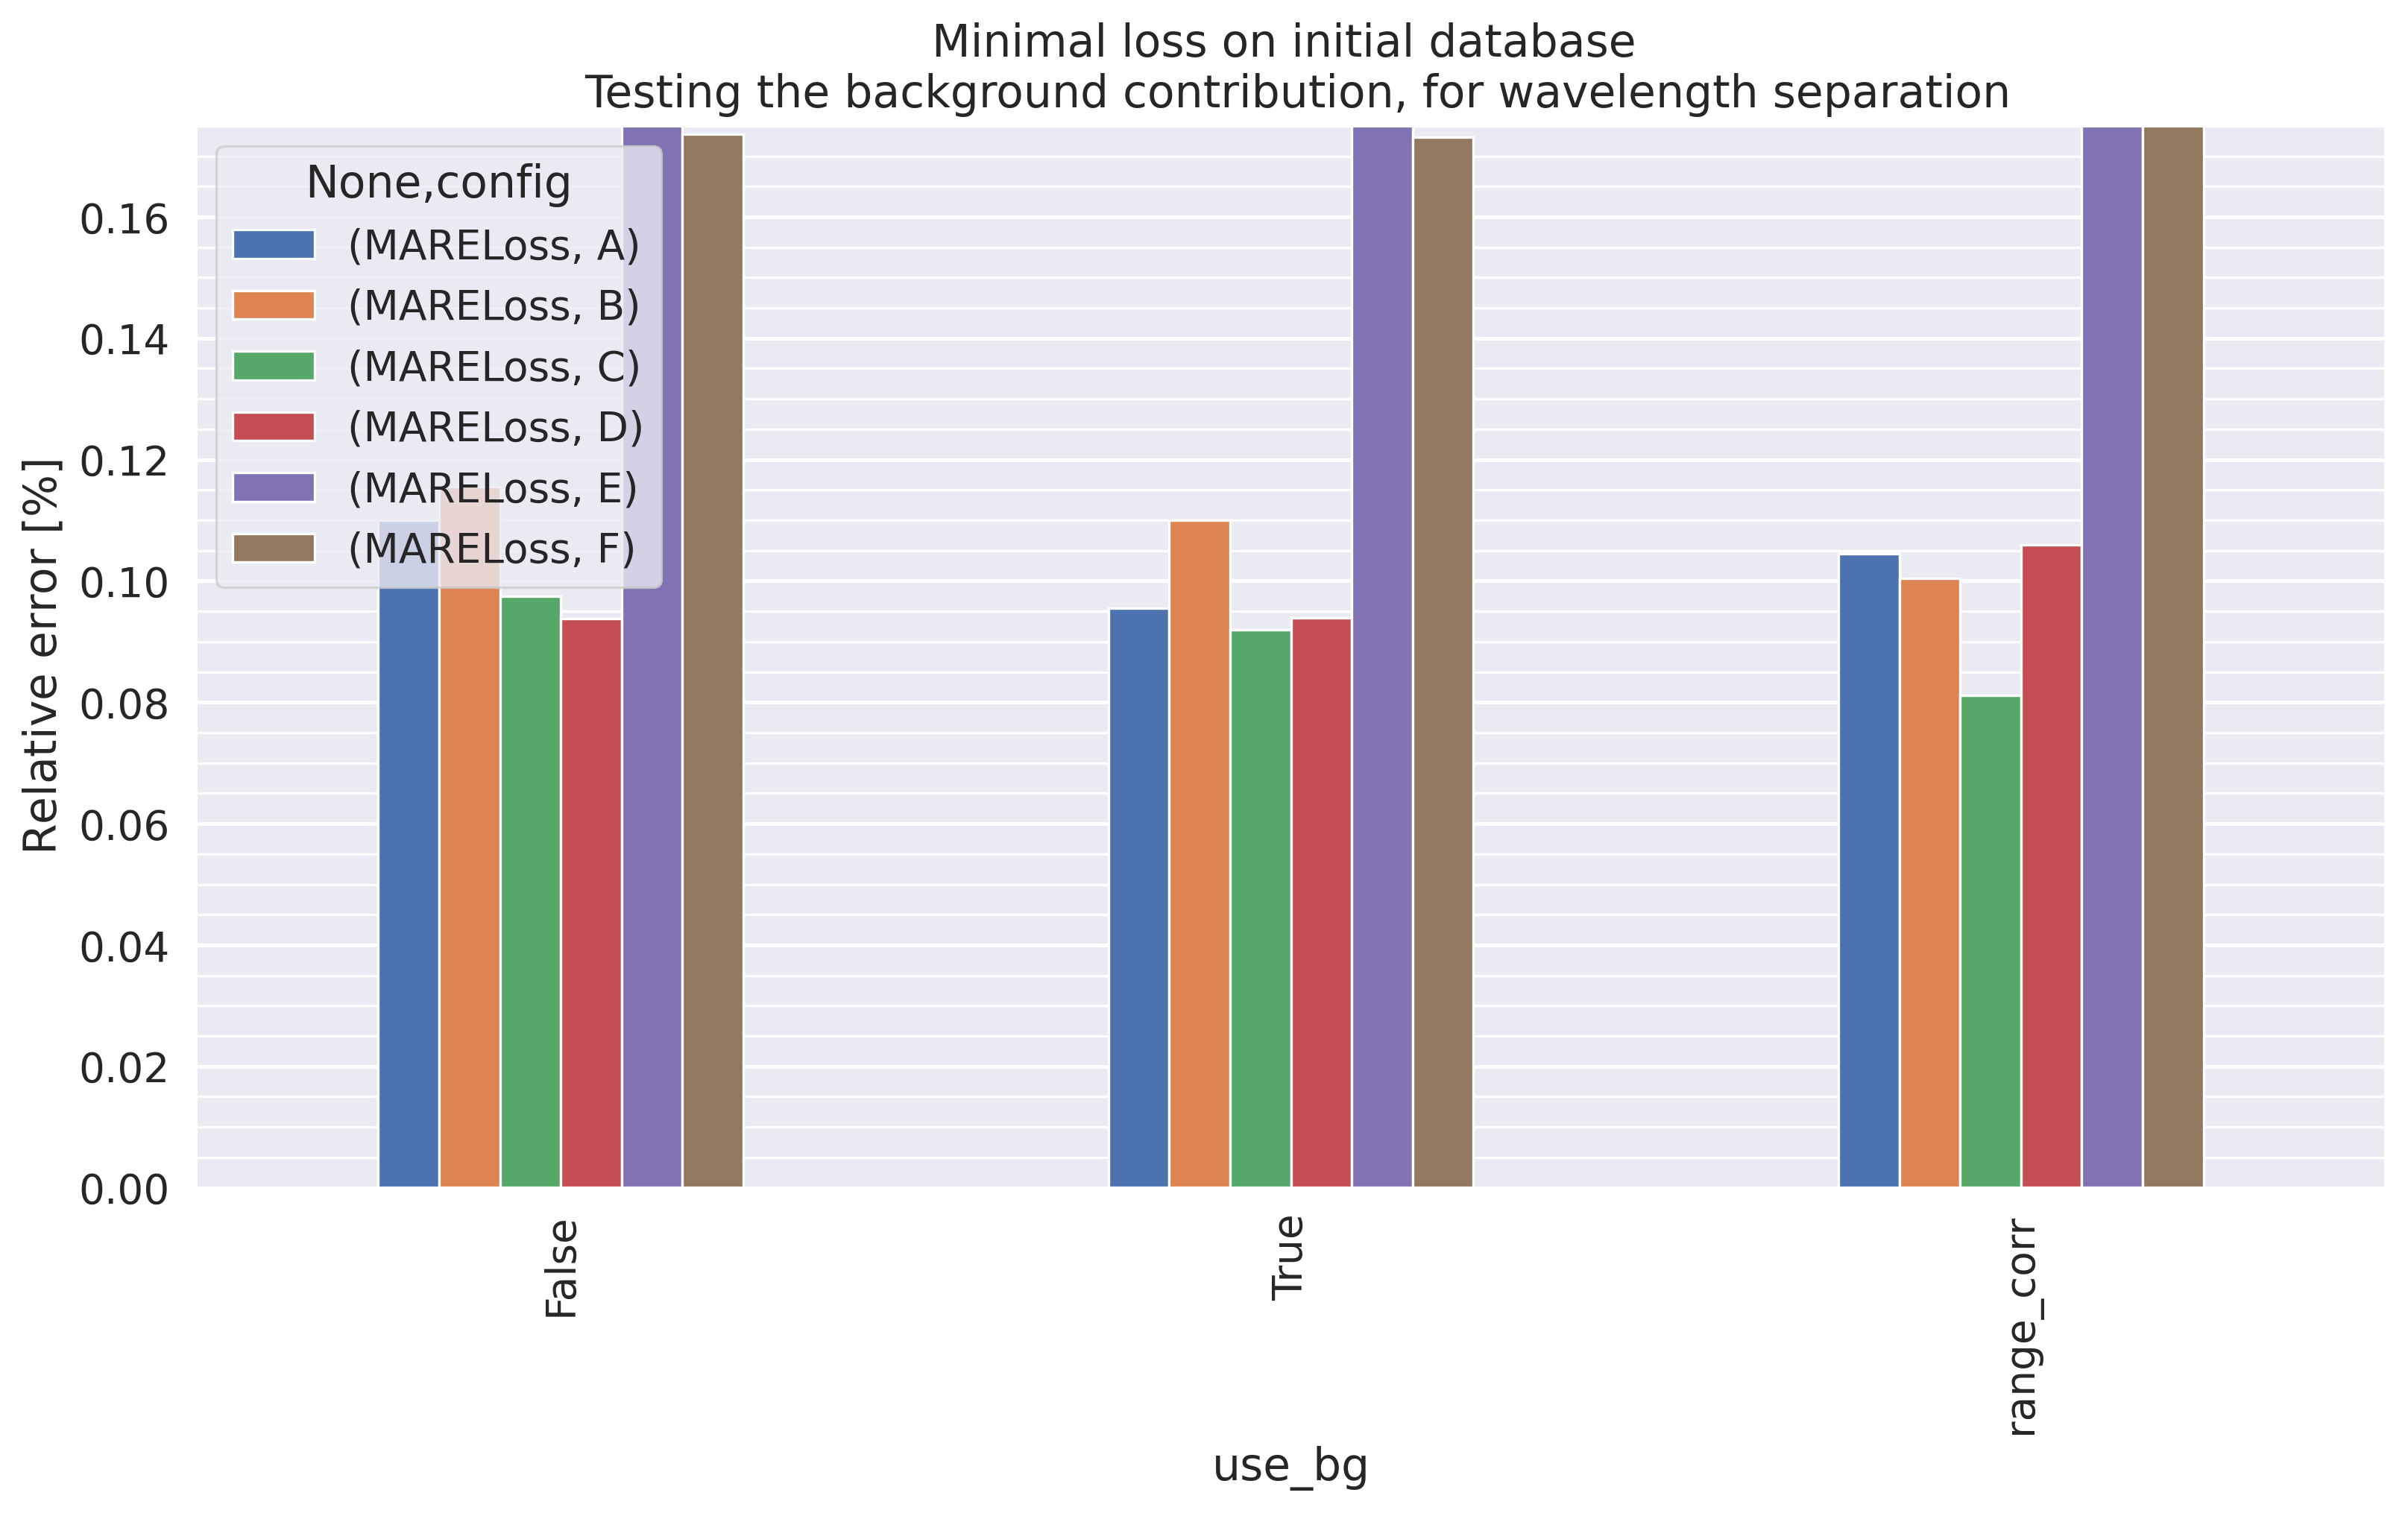

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the background contribution, for wavelength separation')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylim([0.0, 0.175])
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-16-b9fb5c6e891f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],


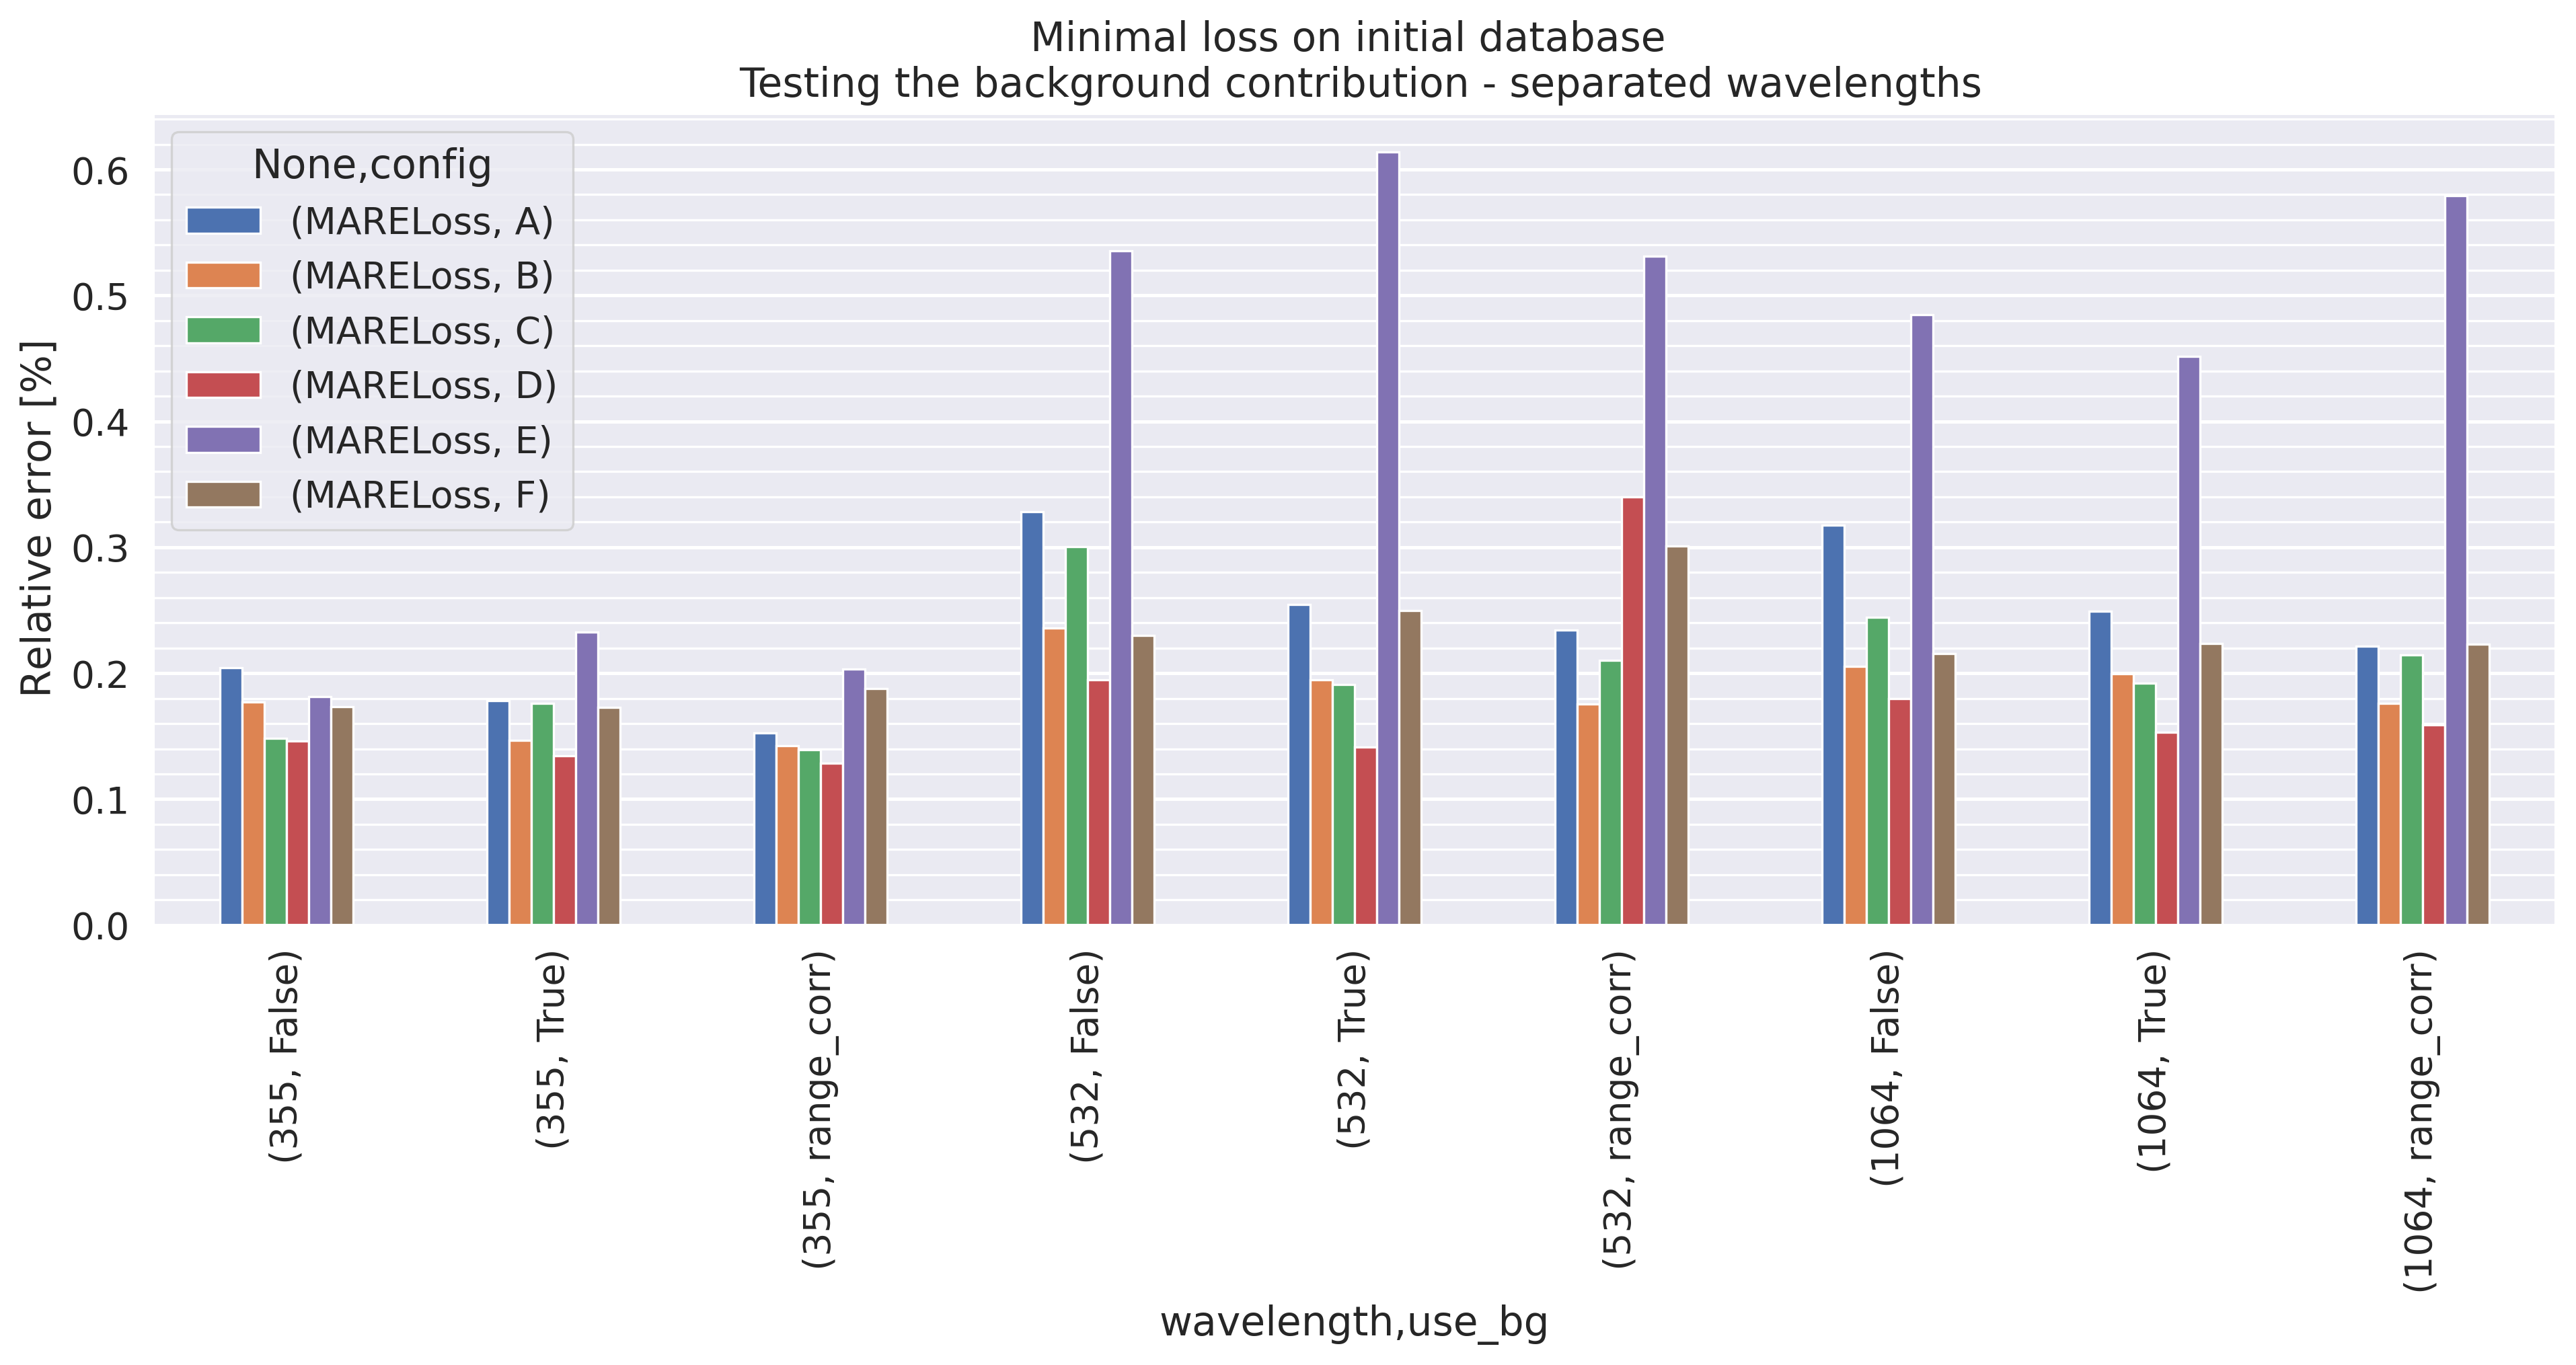

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','use_bg'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the background contribution - separated wavelengths')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()


<ipython-input-17-21731320a99d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


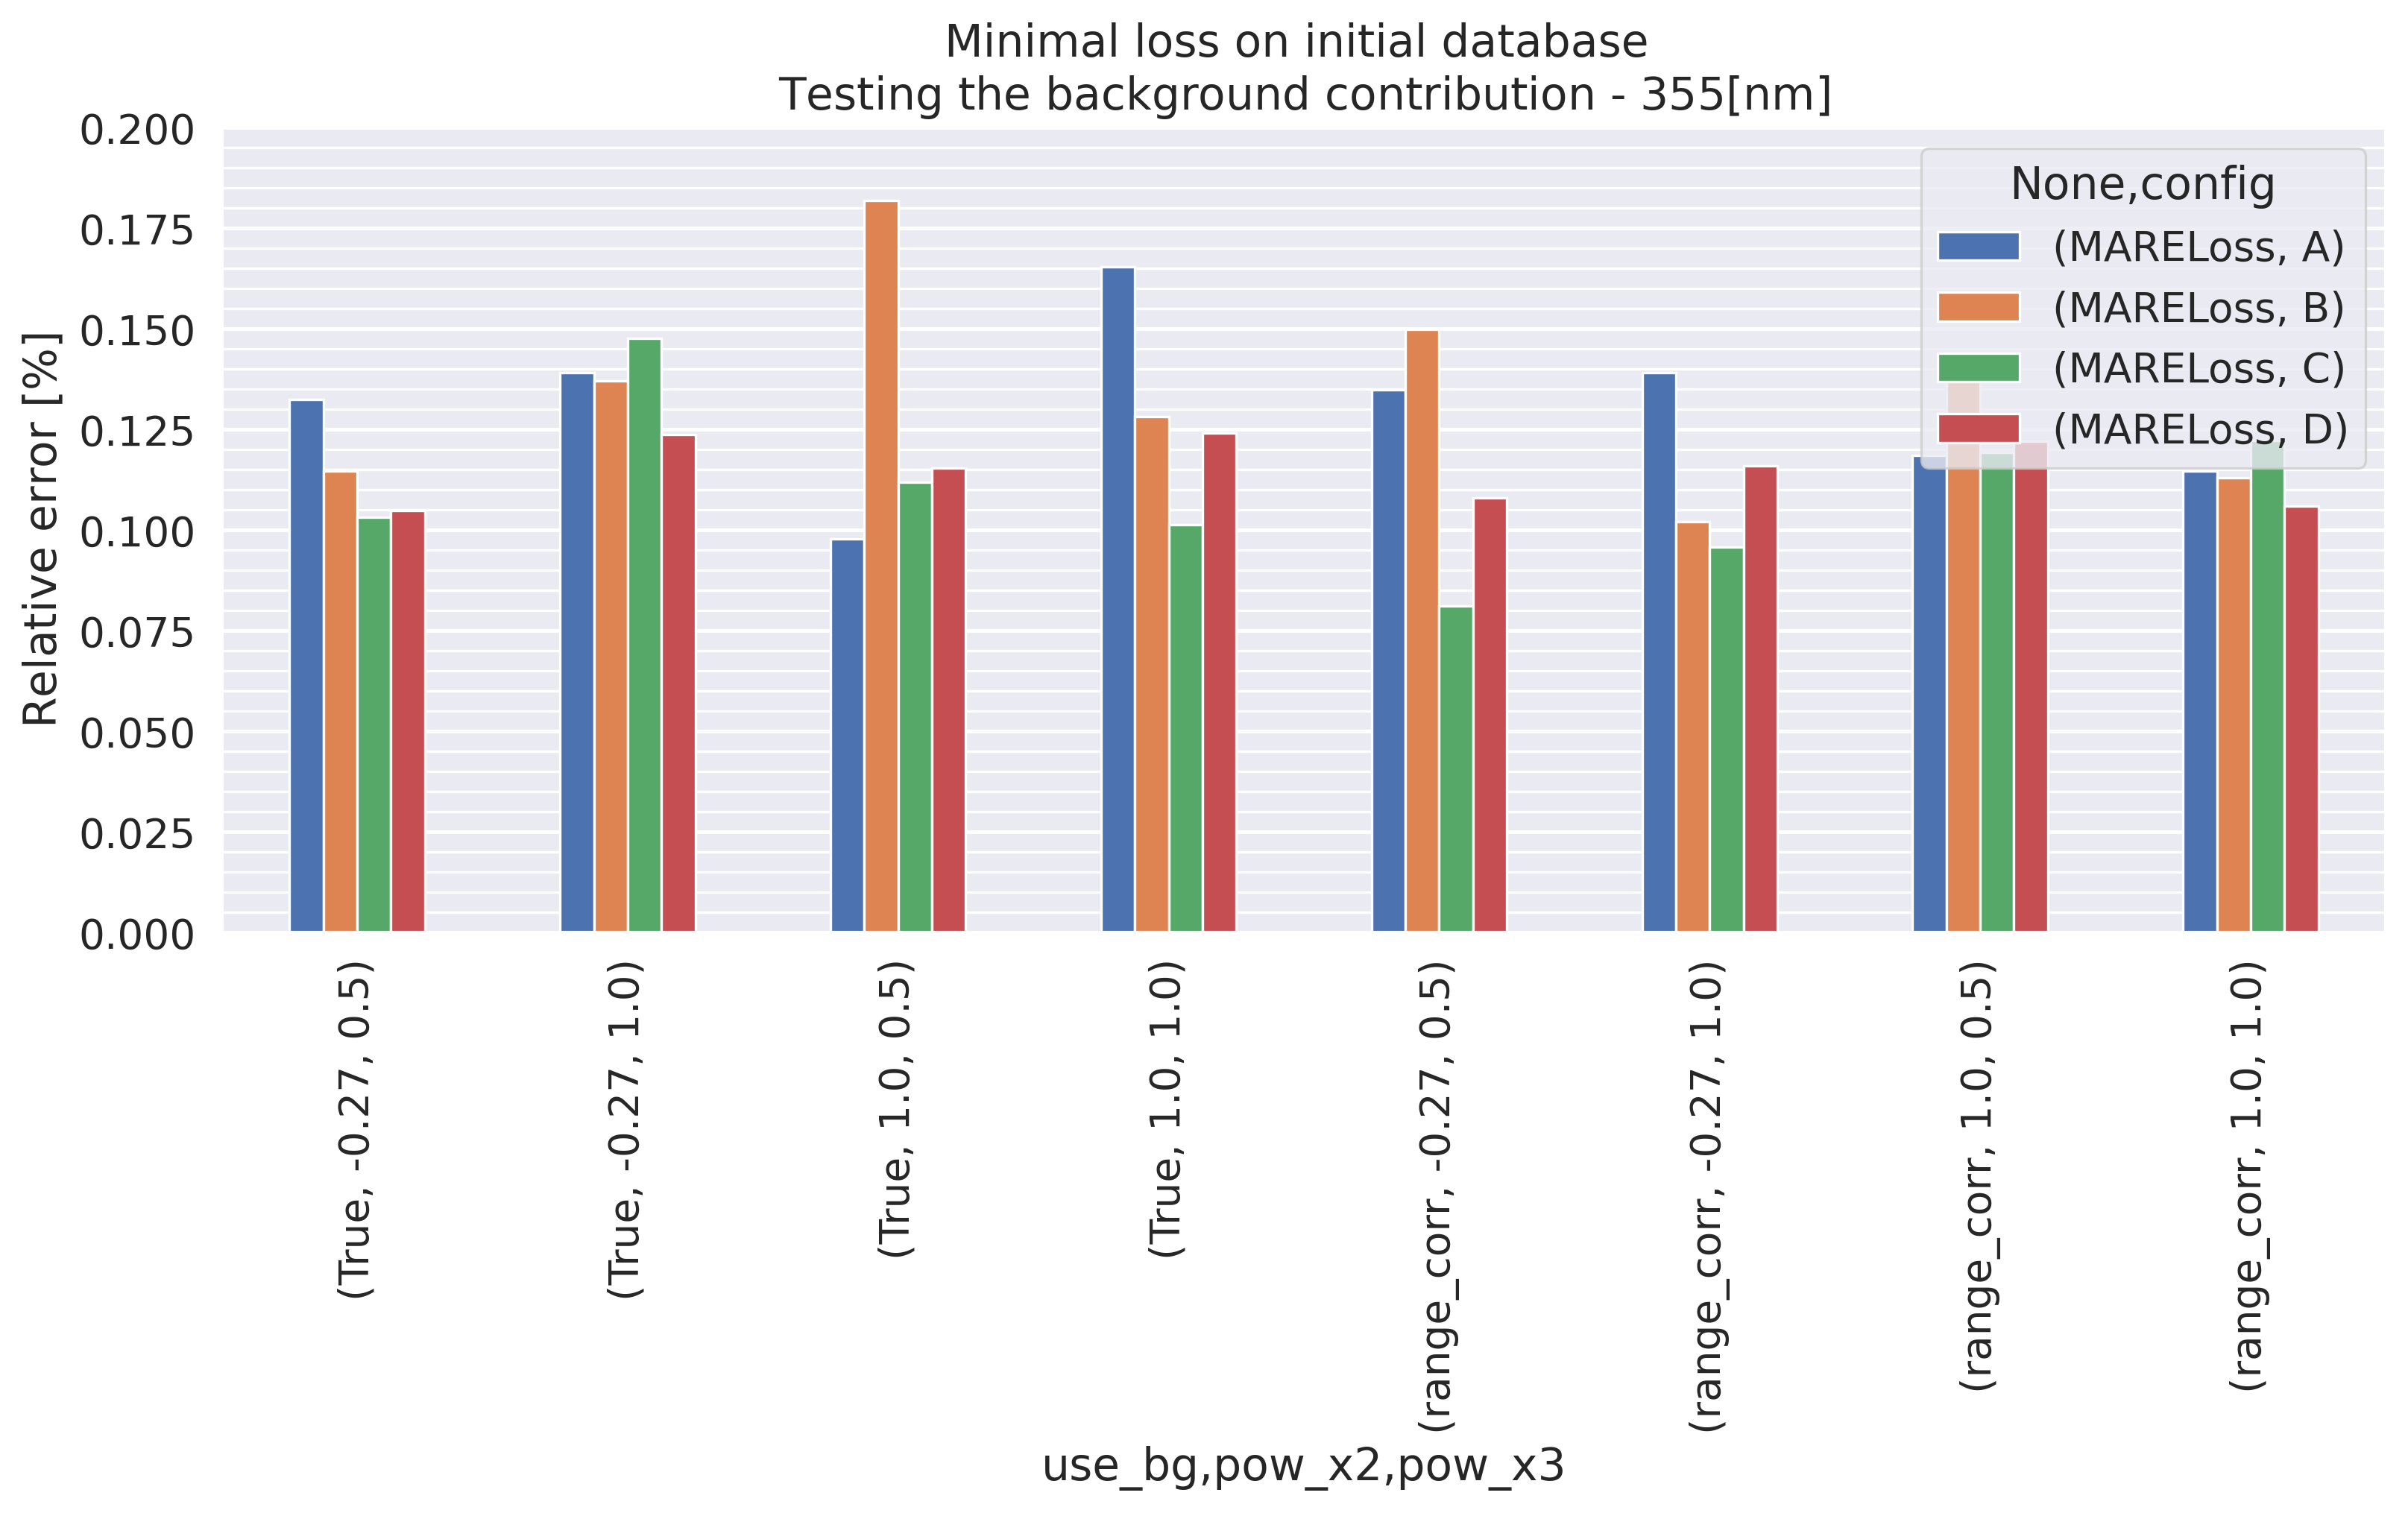

<ipython-input-17-21731320a99d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


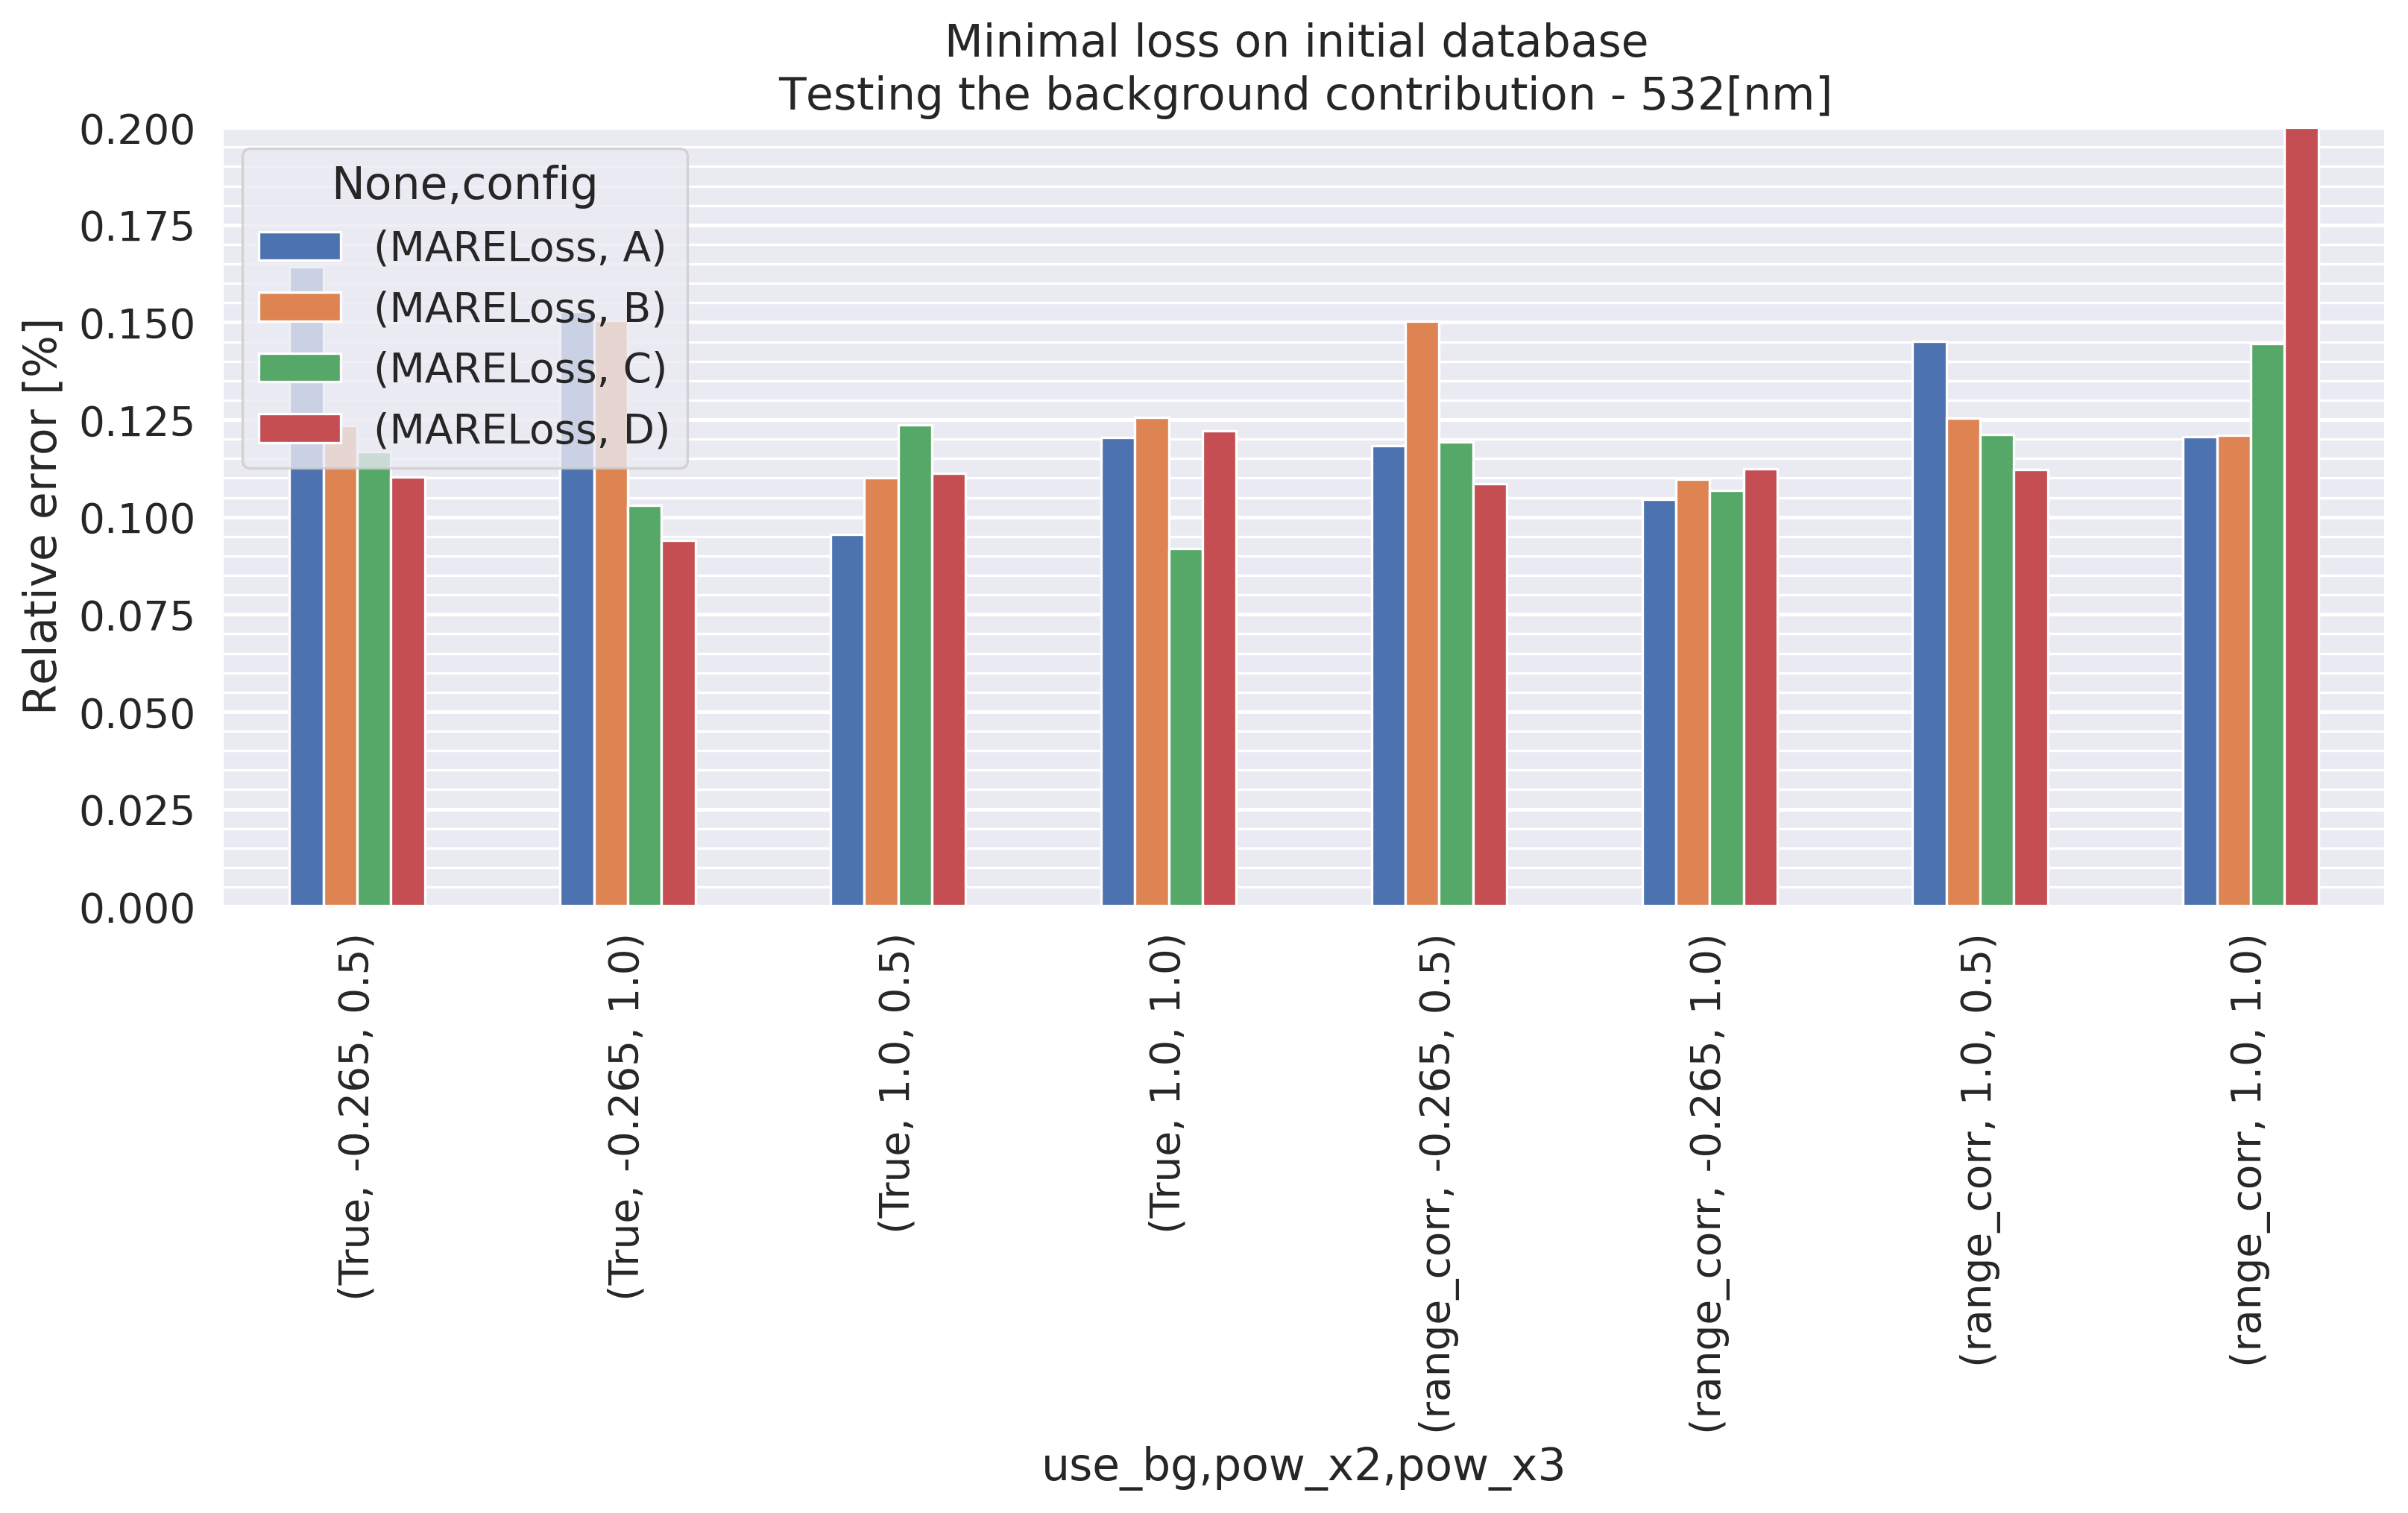

<ipython-input-17-21731320a99d>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']


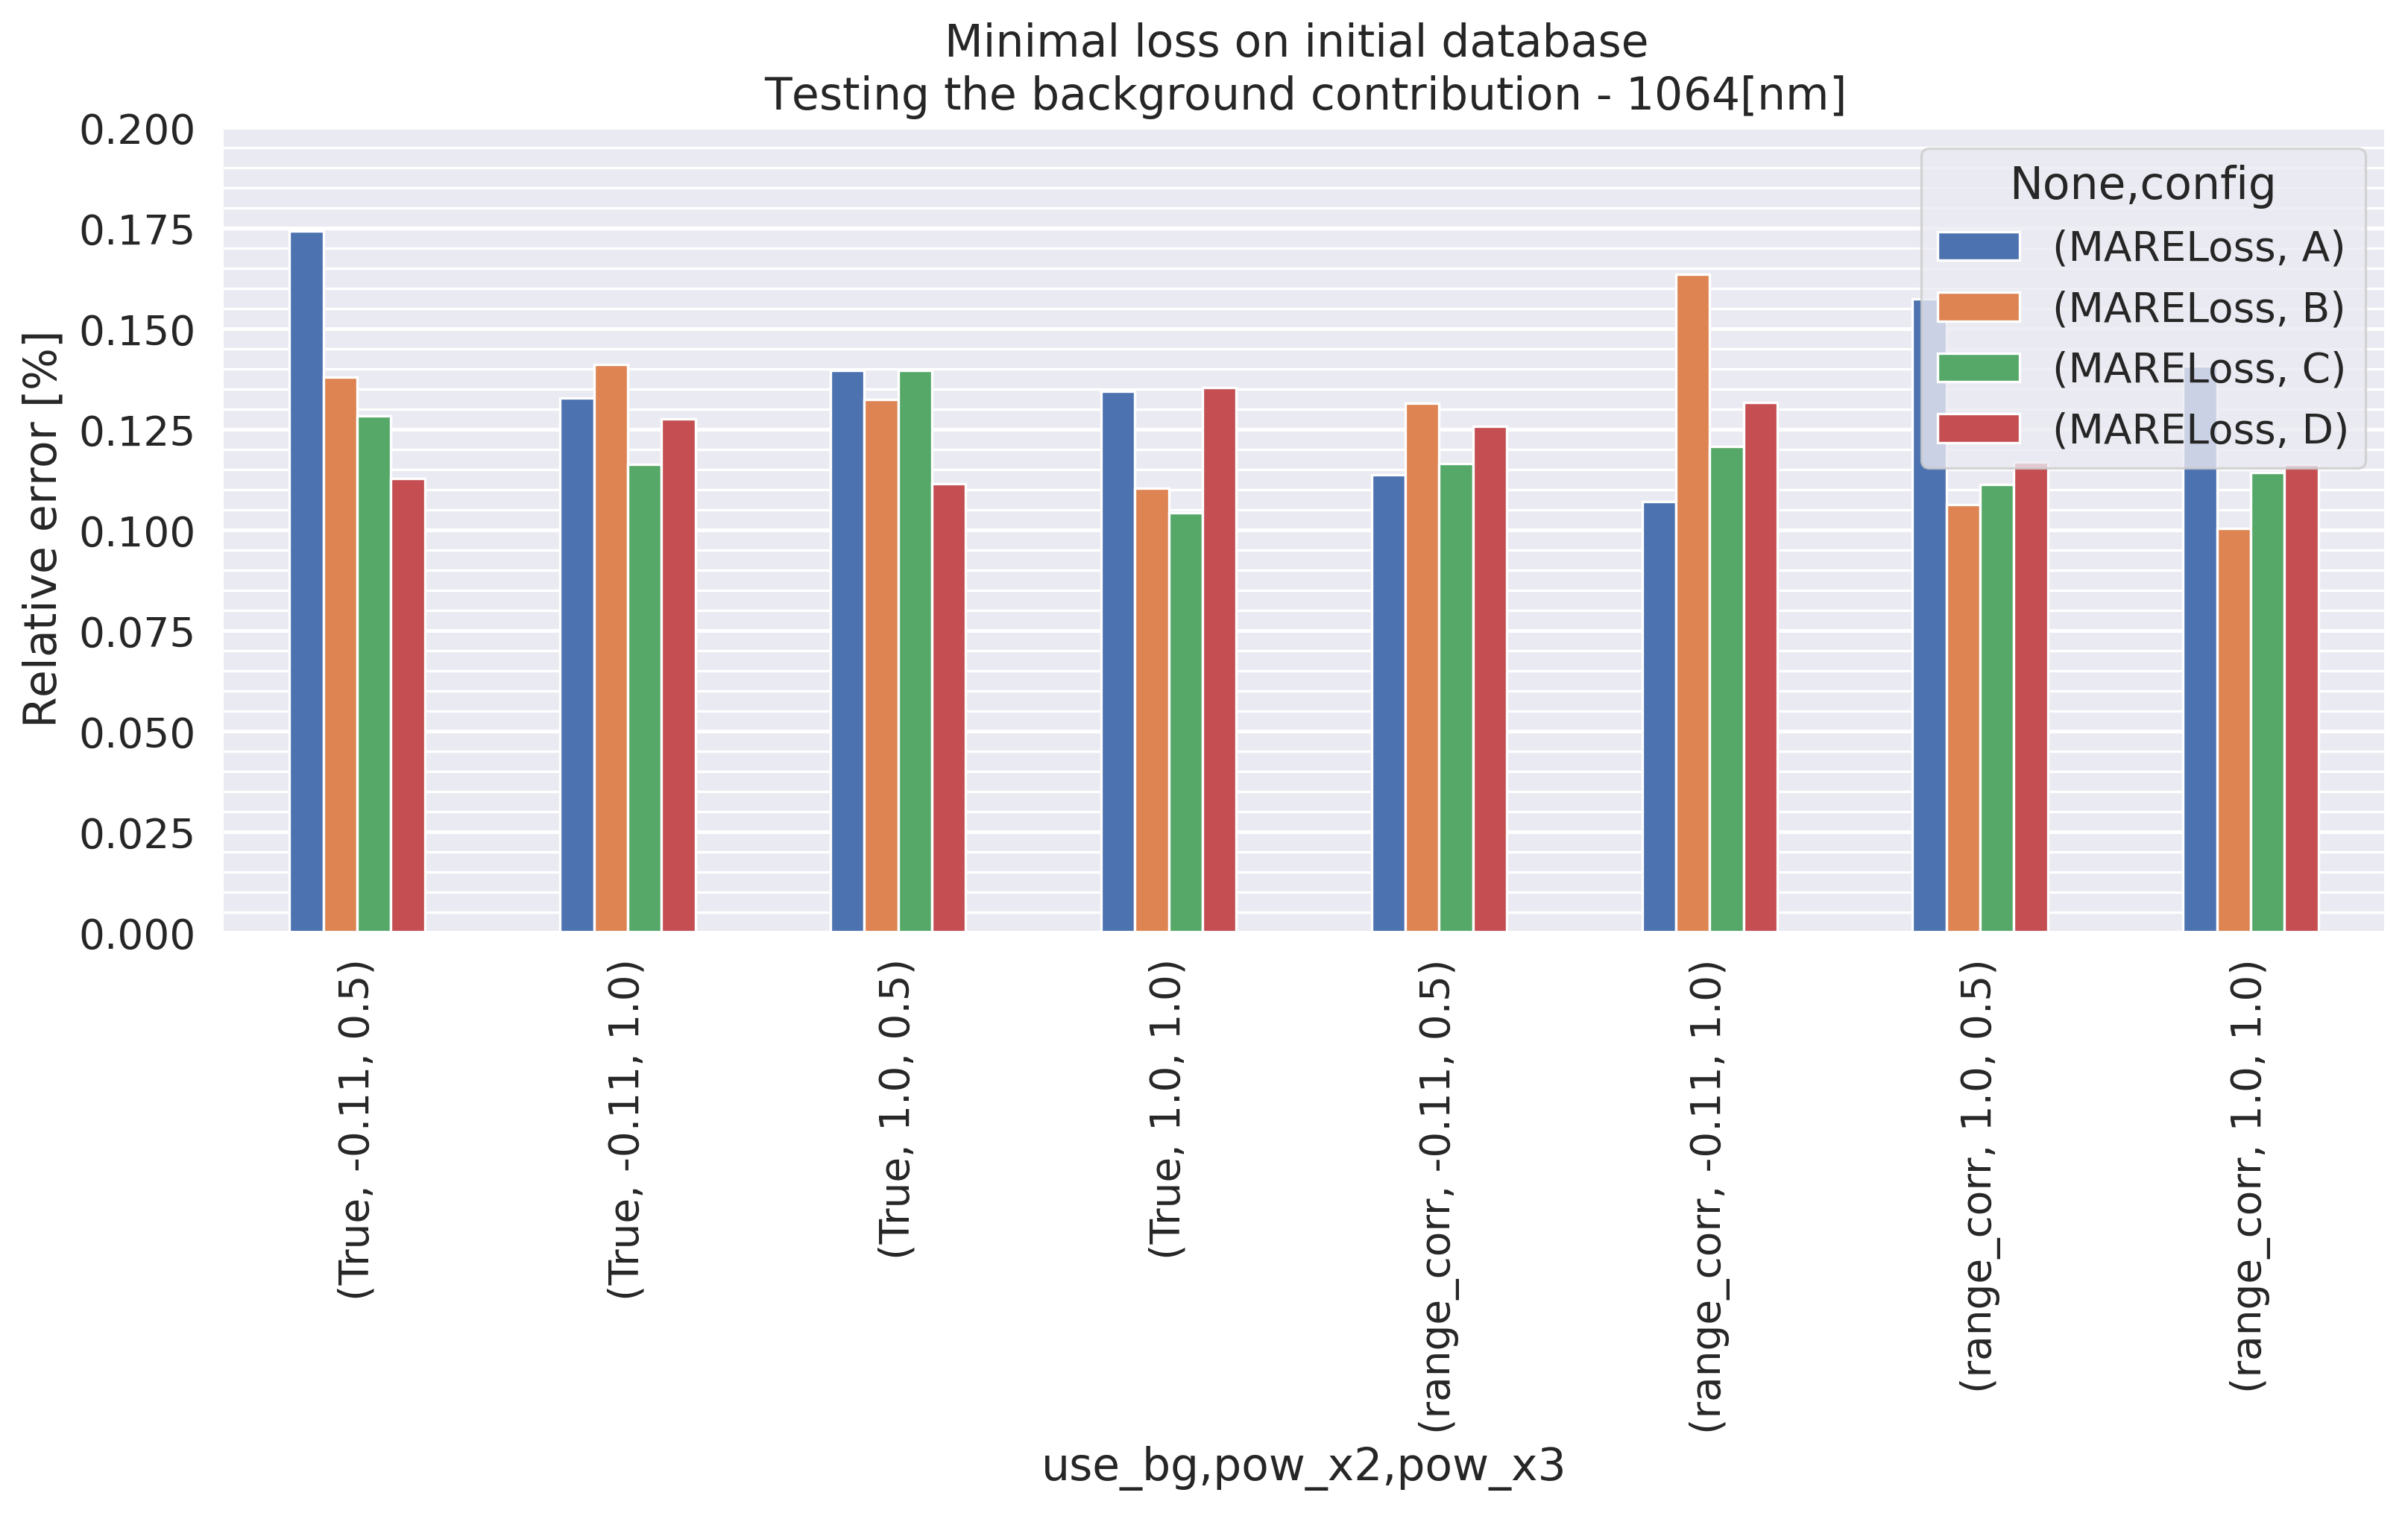

In [17]:
#wavelength =532
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

    pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='initial_db']
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'pow_x2','pow_x3'],
                   aggfunc=np.min).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on initial database \n'+fr'Testing the background contribution - ${wavelength}[\rm nm]$')
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    ax.set_ylim([0.0, 0.2])
    plt.tight_layout()
    plt.show()

<ipython-input-18-a5742928cd4f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr']


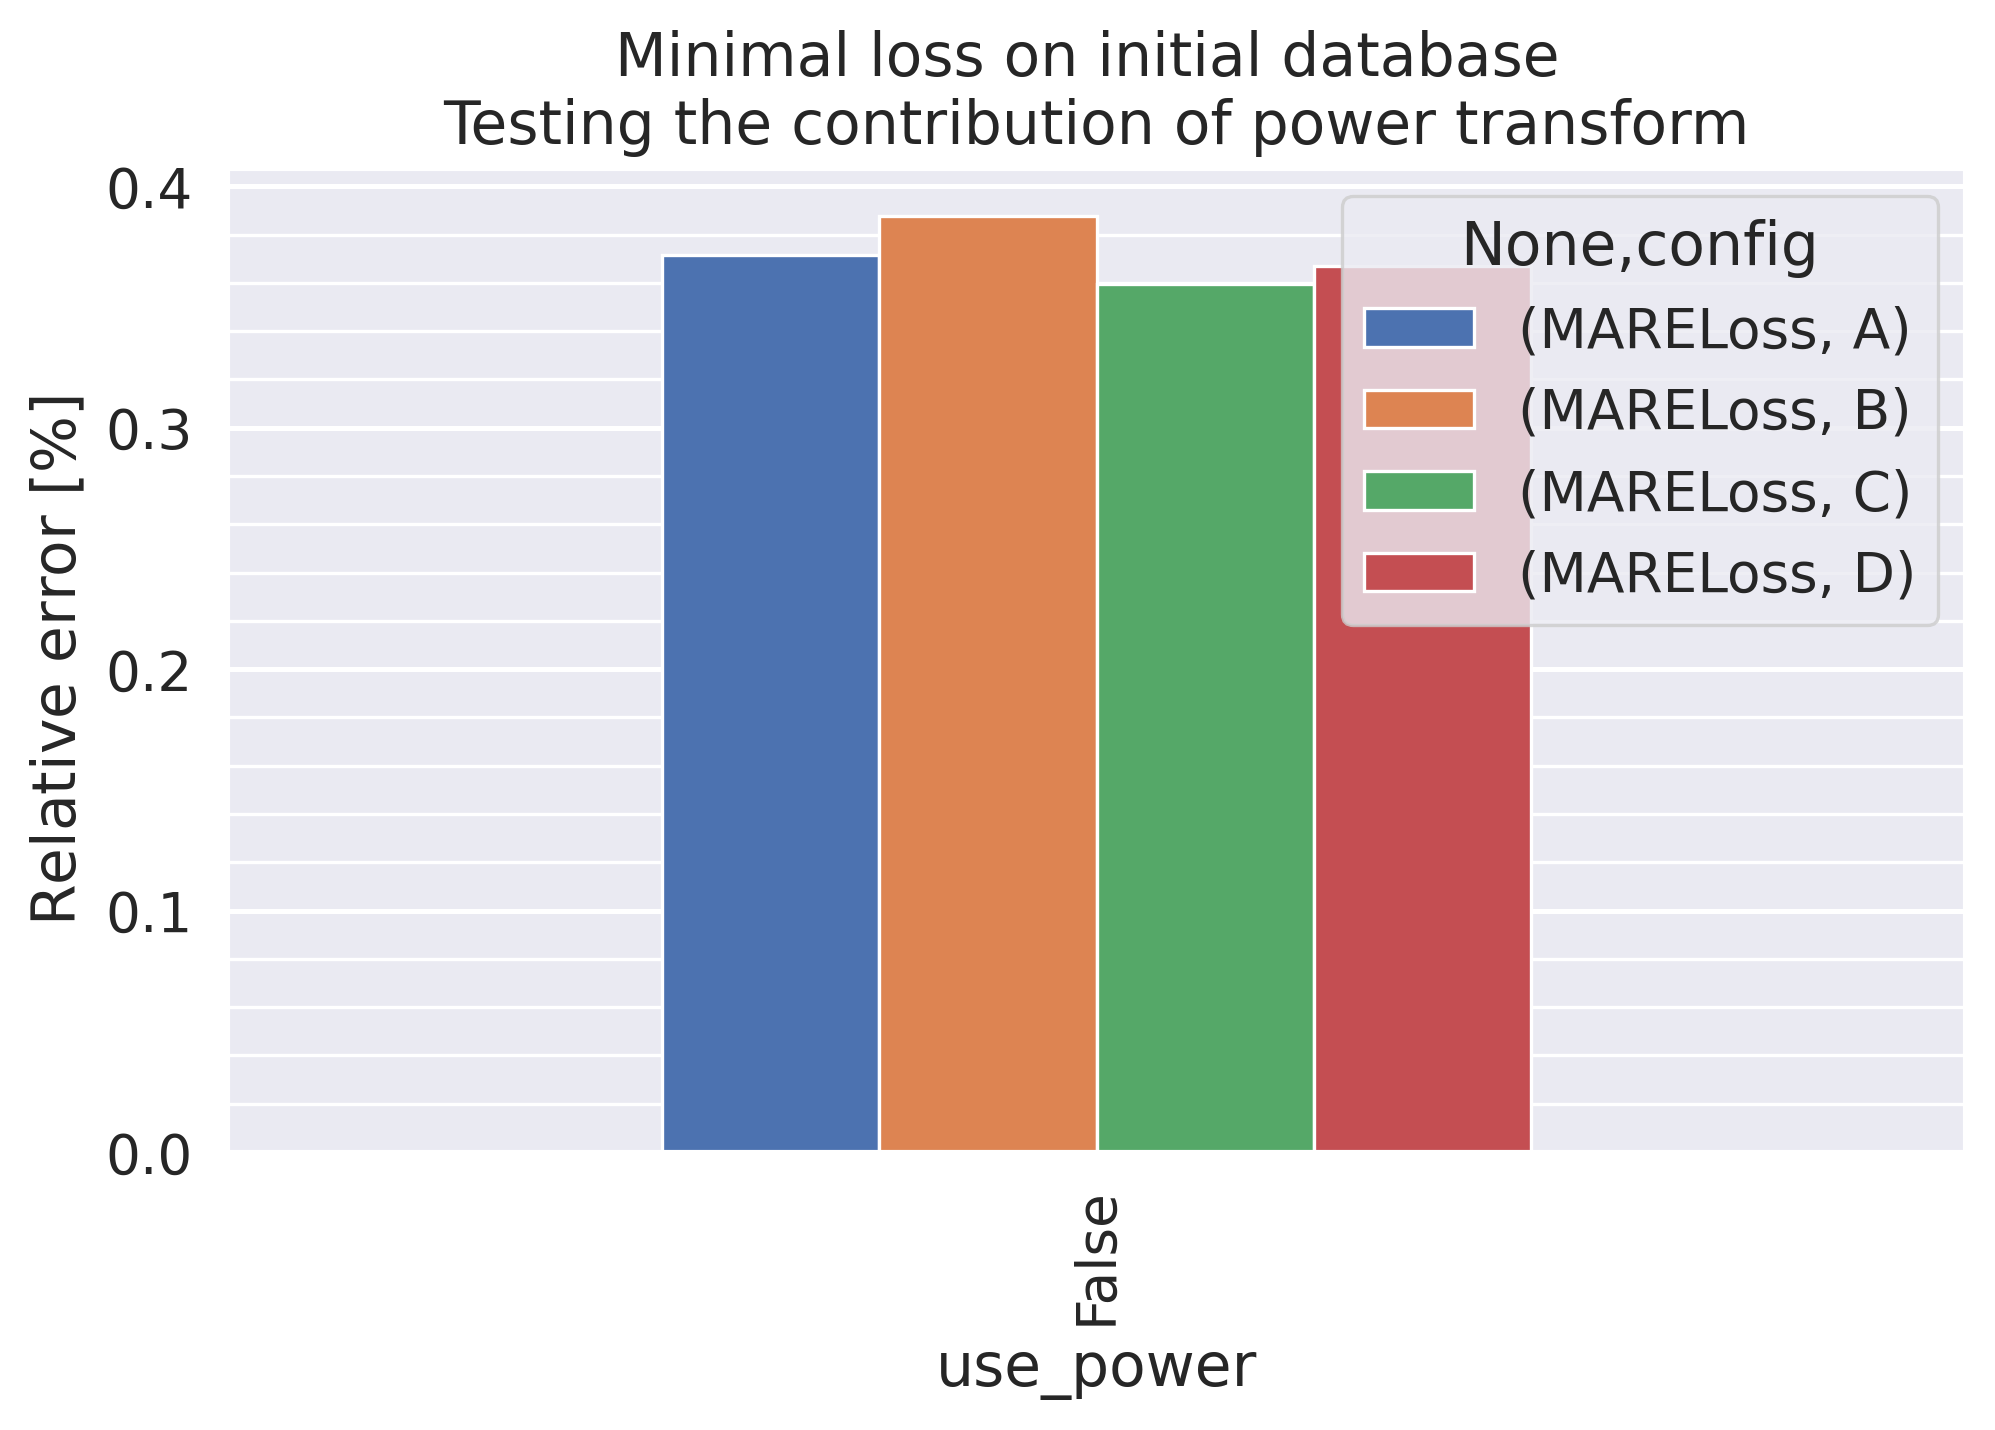

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg!=True][all_wavs_configABCD.use_bg!='range_corr']
               [all_wavs_configABCD.note=='extended_db'][all_wavs_configABCD.wavelength=='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_power'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on initial database \n Testing the contribution of power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-19-94cf29c27284>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


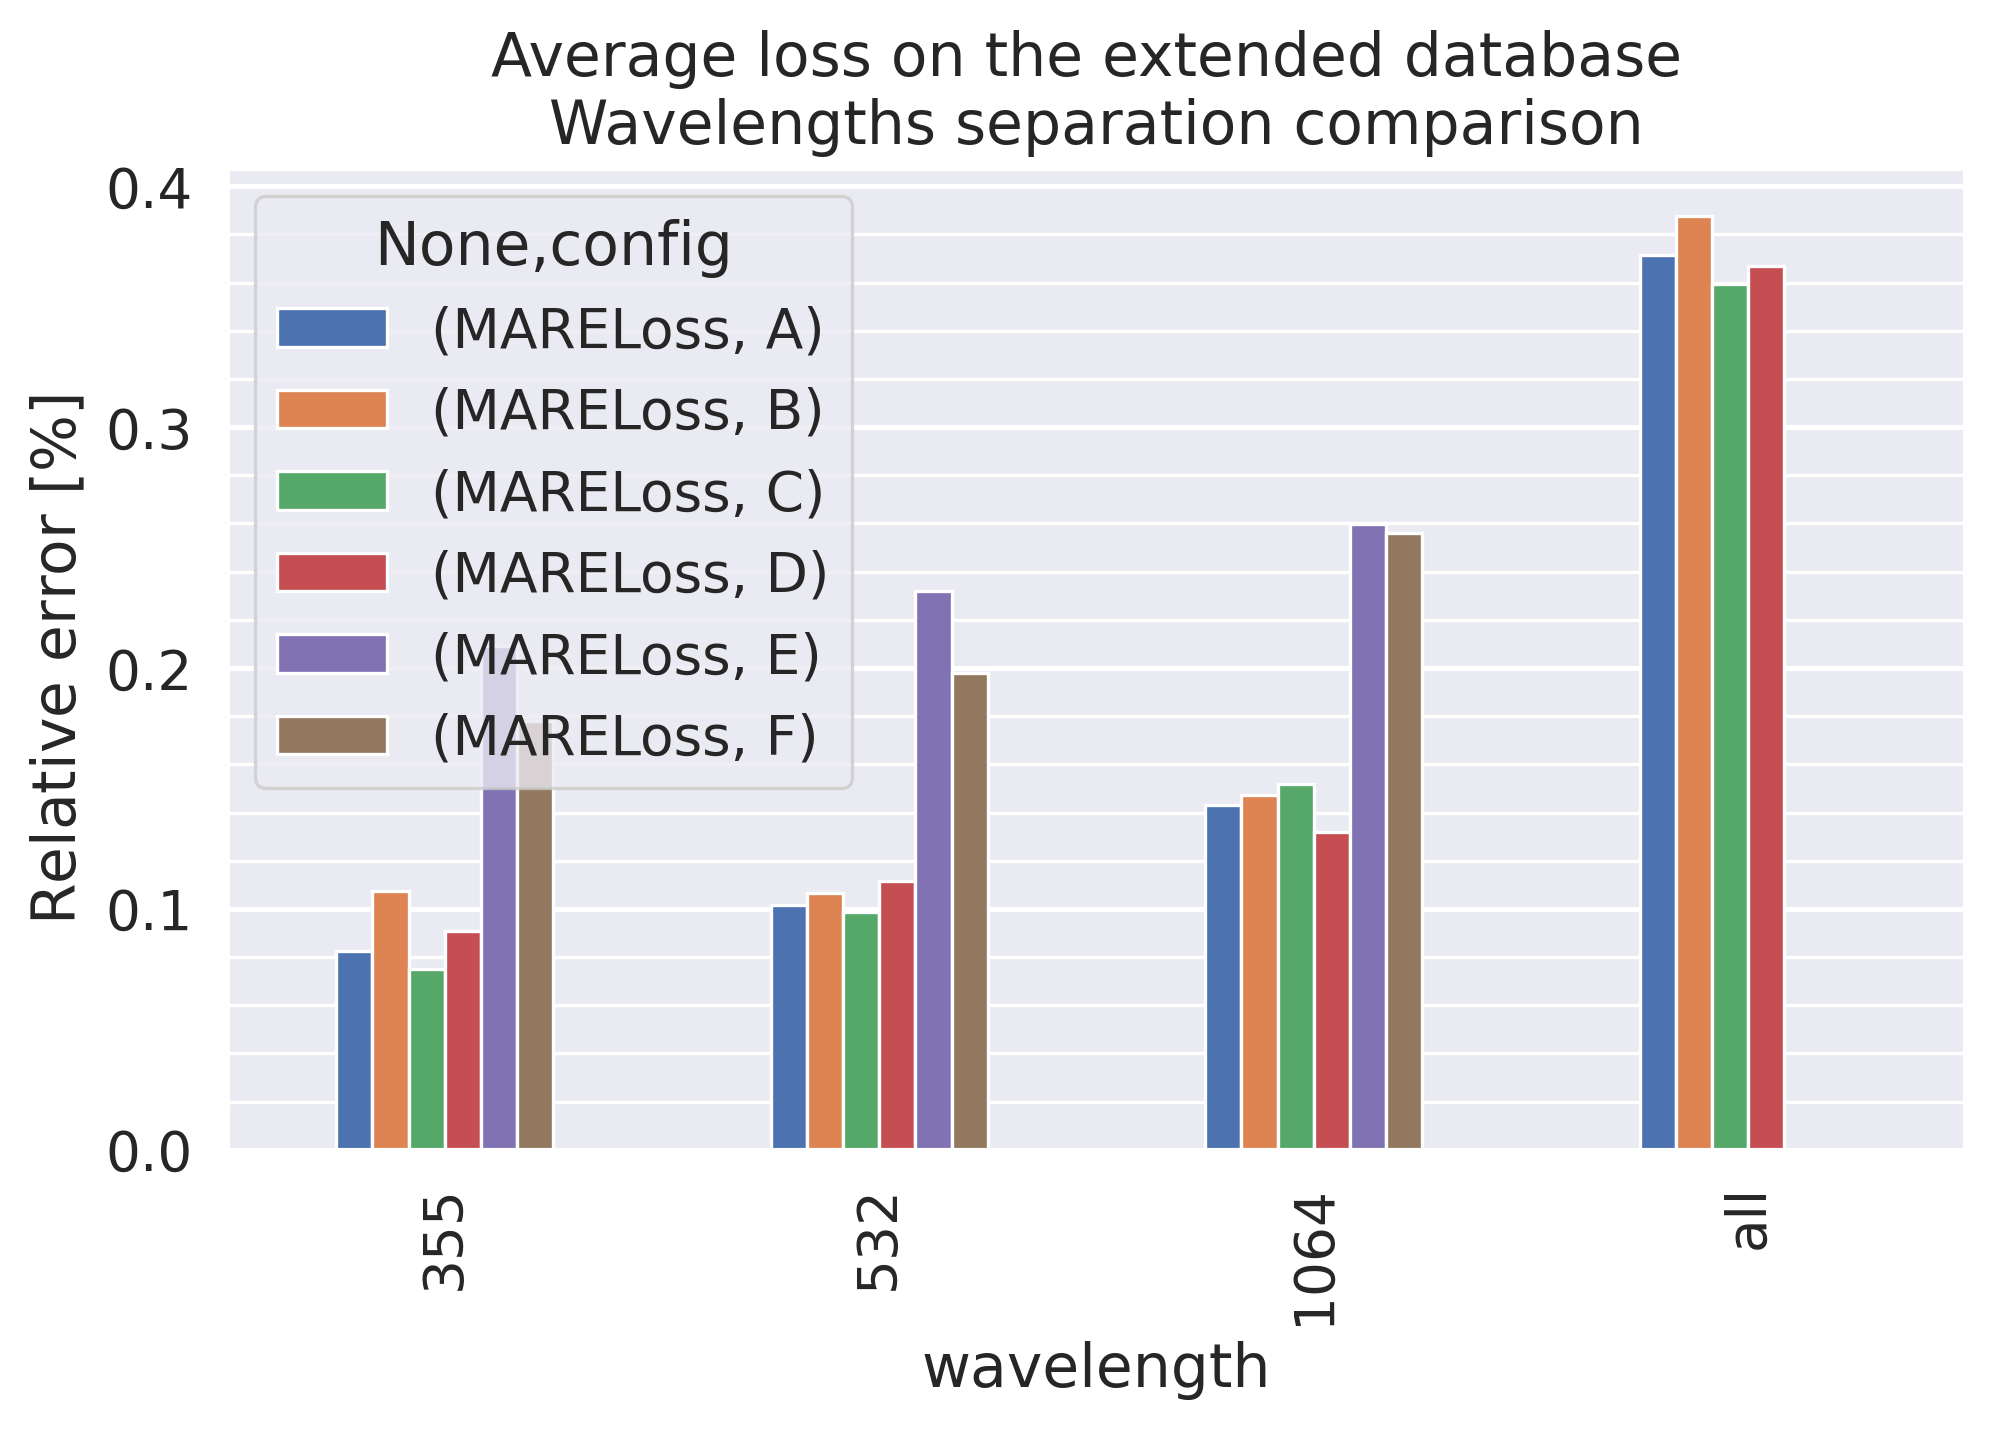

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Average loss on the extended database \n Wavelengths separation comparison ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-20-527ef60f31bd>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='extended_db'],


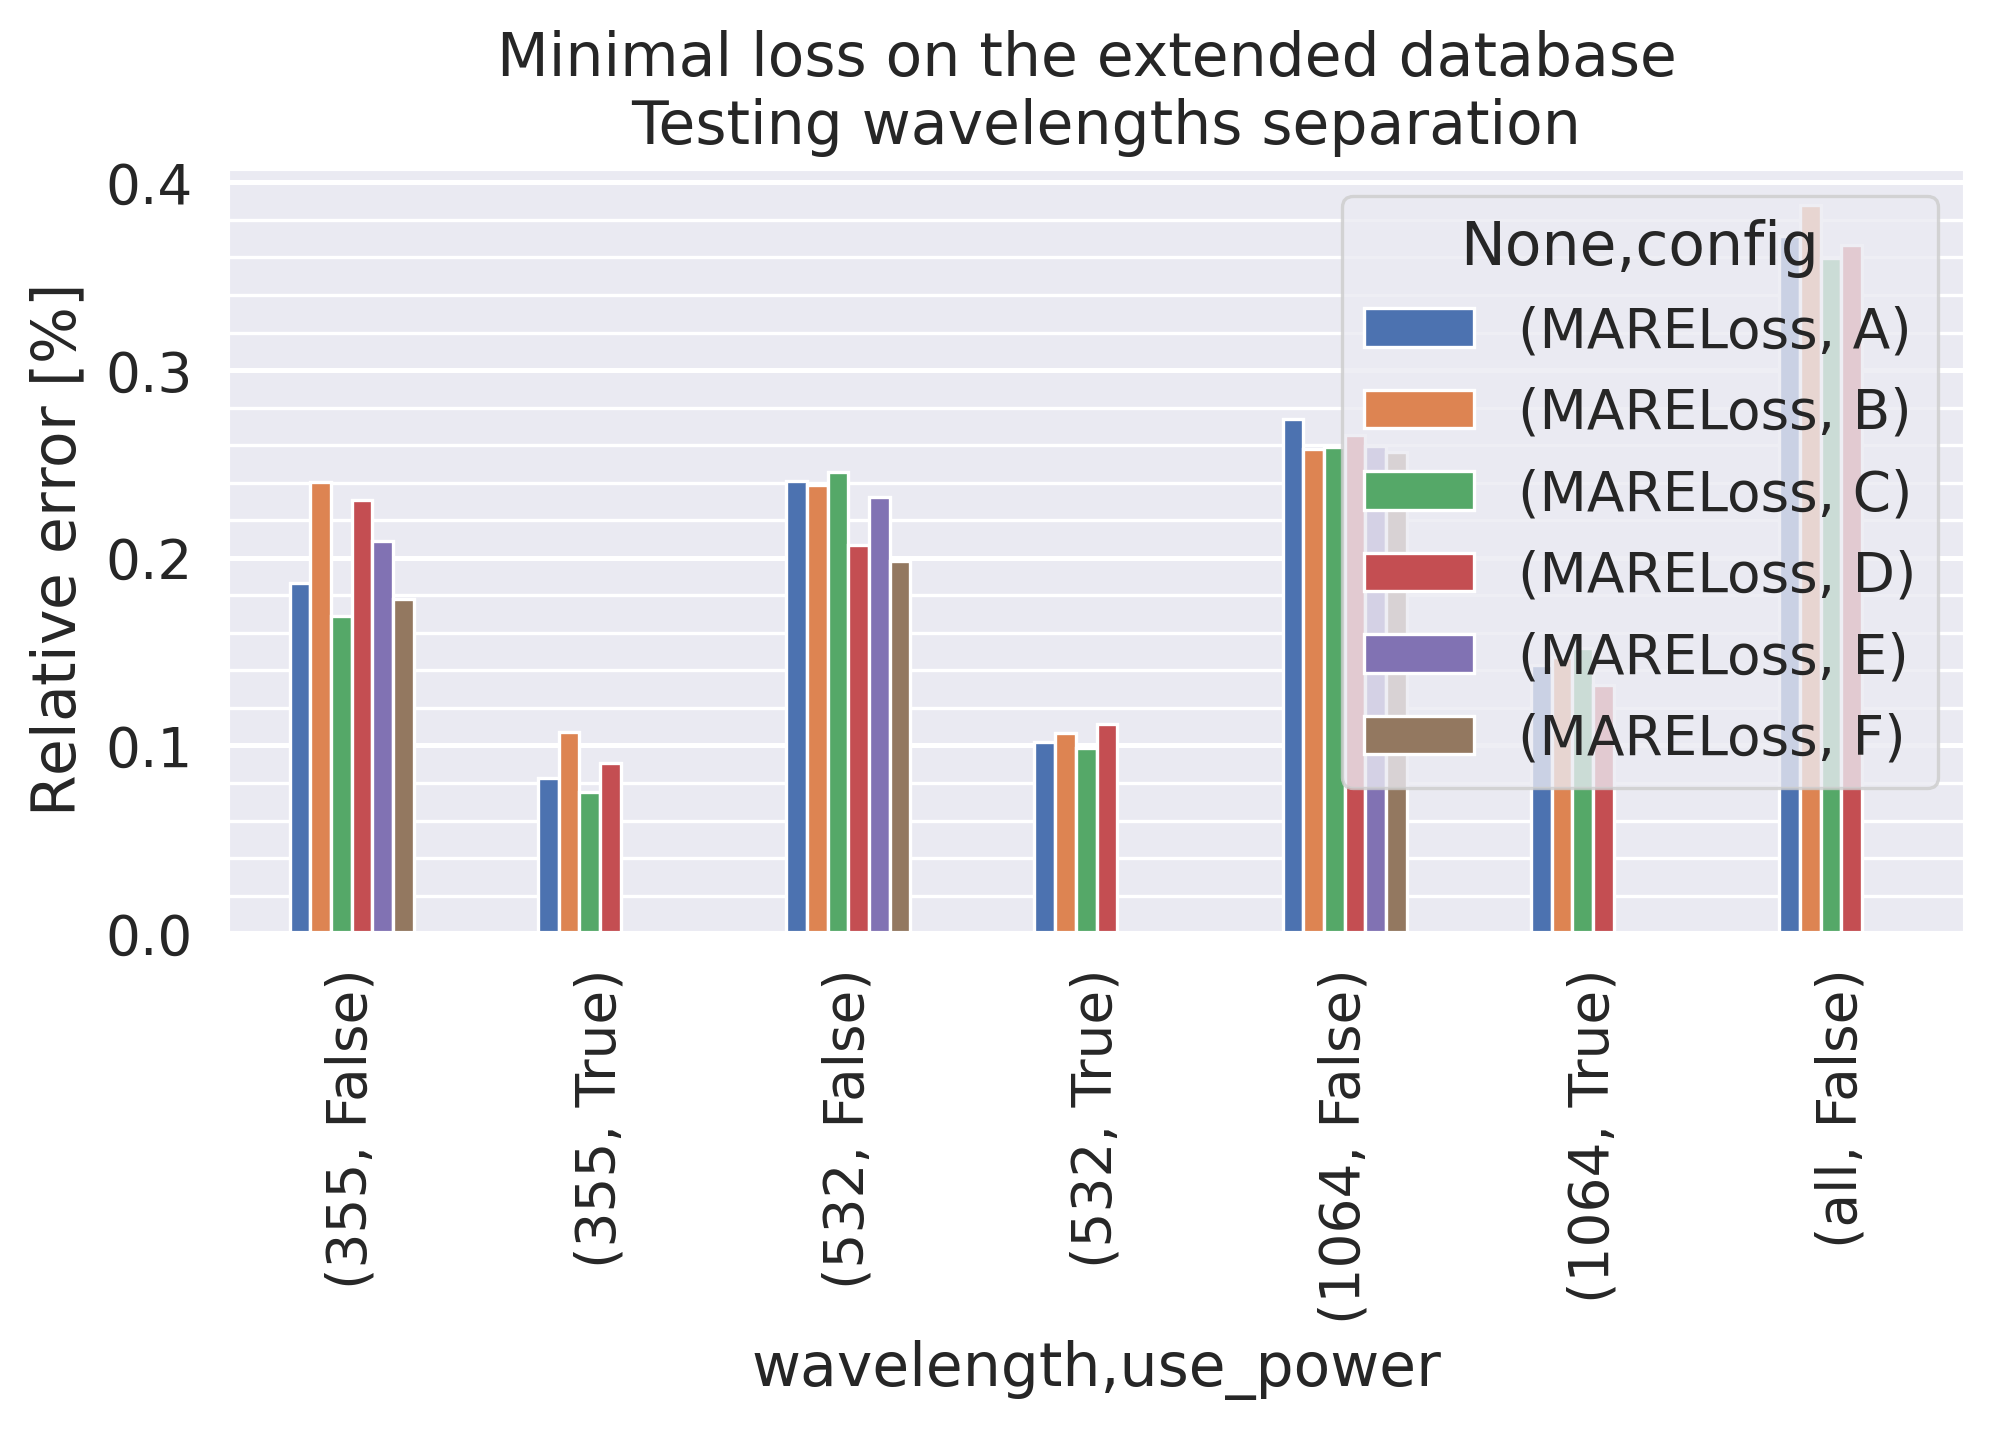

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','use_power'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on the extended database \n Testing wavelengths separation')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-21-1838f254c99e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]


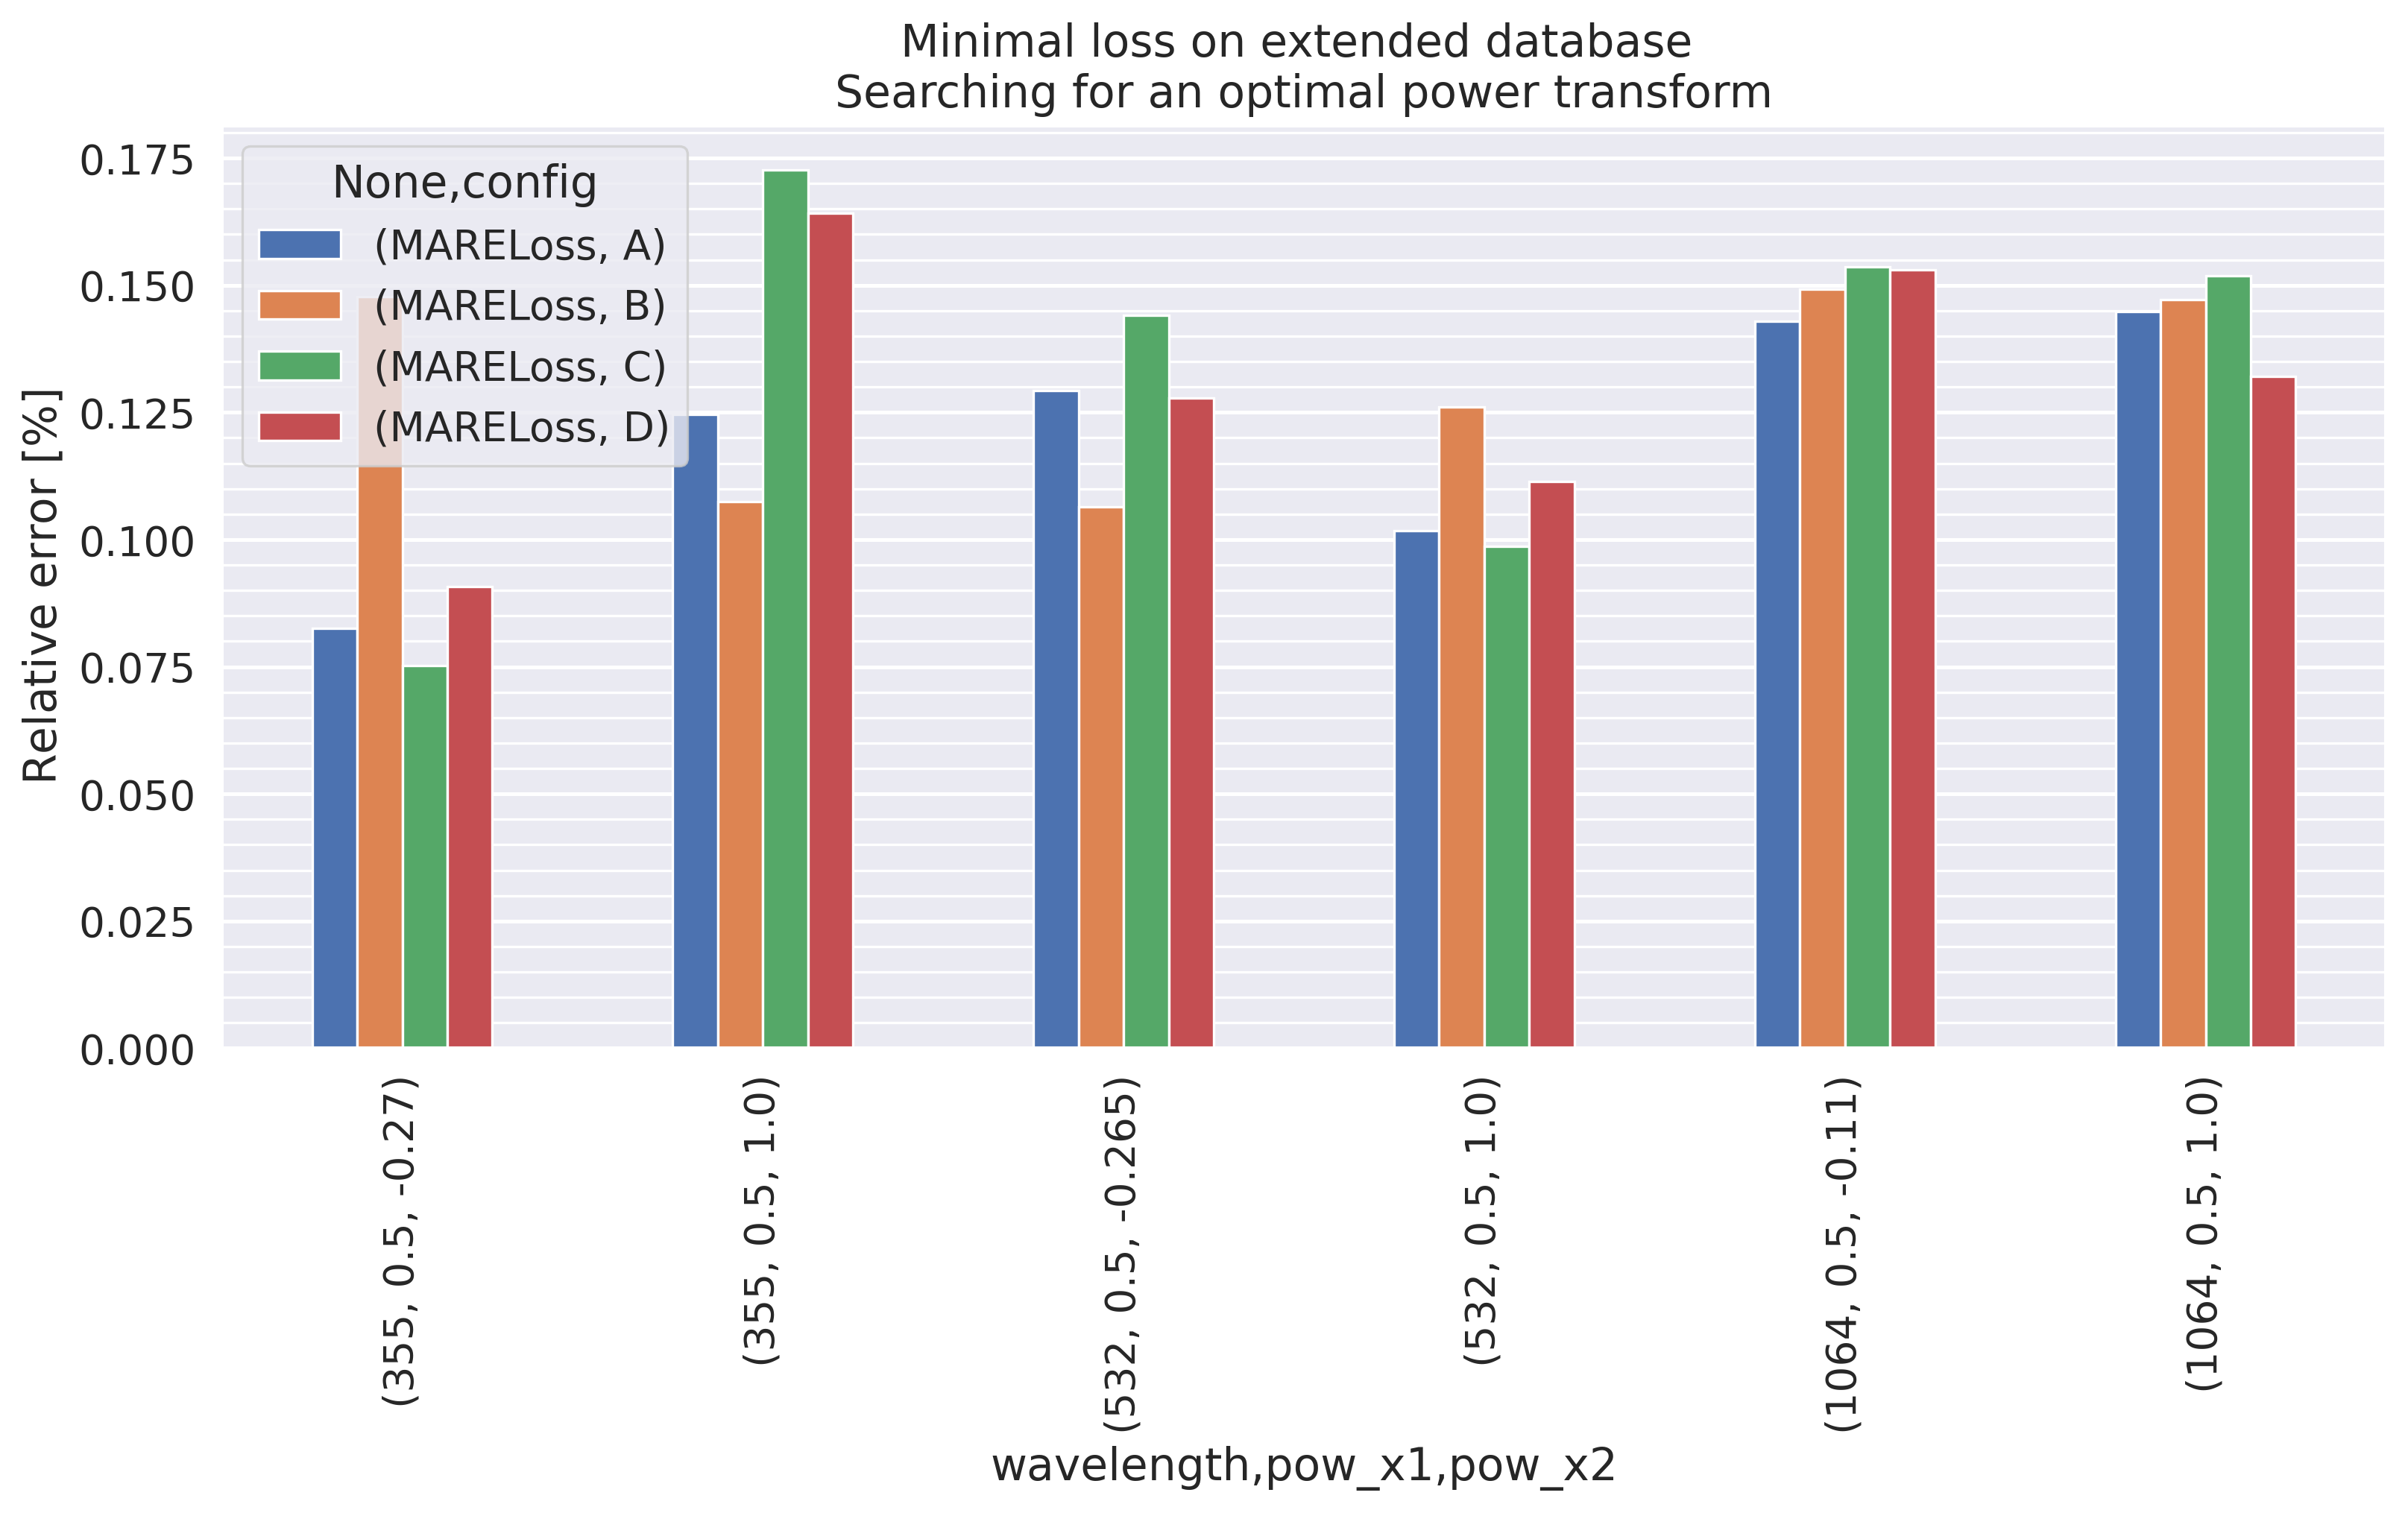

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False]
               [all_wavs_configABCD.note=='extended_db'][all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','pow_x1','pow_x2'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on extended database \n Searching for an optimal power transform ')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

In [22]:
all_wavs_configABCD[all_wavs_configABCD.wavelength==532][all_wavs_configABCD.use_bg==False].note

<ipython-input-22-88fa8e8ae773>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_wavs_configABCD[all_wavs_configABCD.wavelength==532][all_wavs_configABCD.use_bg==False].note


13      initial_db
14      initial_db
15      initial_db
16      initial_db
18      initial_db
20      initial_db
21      initial_db
22      initial_db
140    extended_db
141    extended_db
142    extended_db
143    extended_db
144    extended_db
145    extended_db
146    extended_db
147    extended_db
260     initial_db
265     initial_db
266     initial_db
267     initial_db
284     initial_db
295     initial_db
314    extended_db
319    extended_db
320    extended_db
324    extended_db
326    extended_db
349    extended_db
Name: note, dtype: object

<ipython-input-23-ee92460ba052>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],


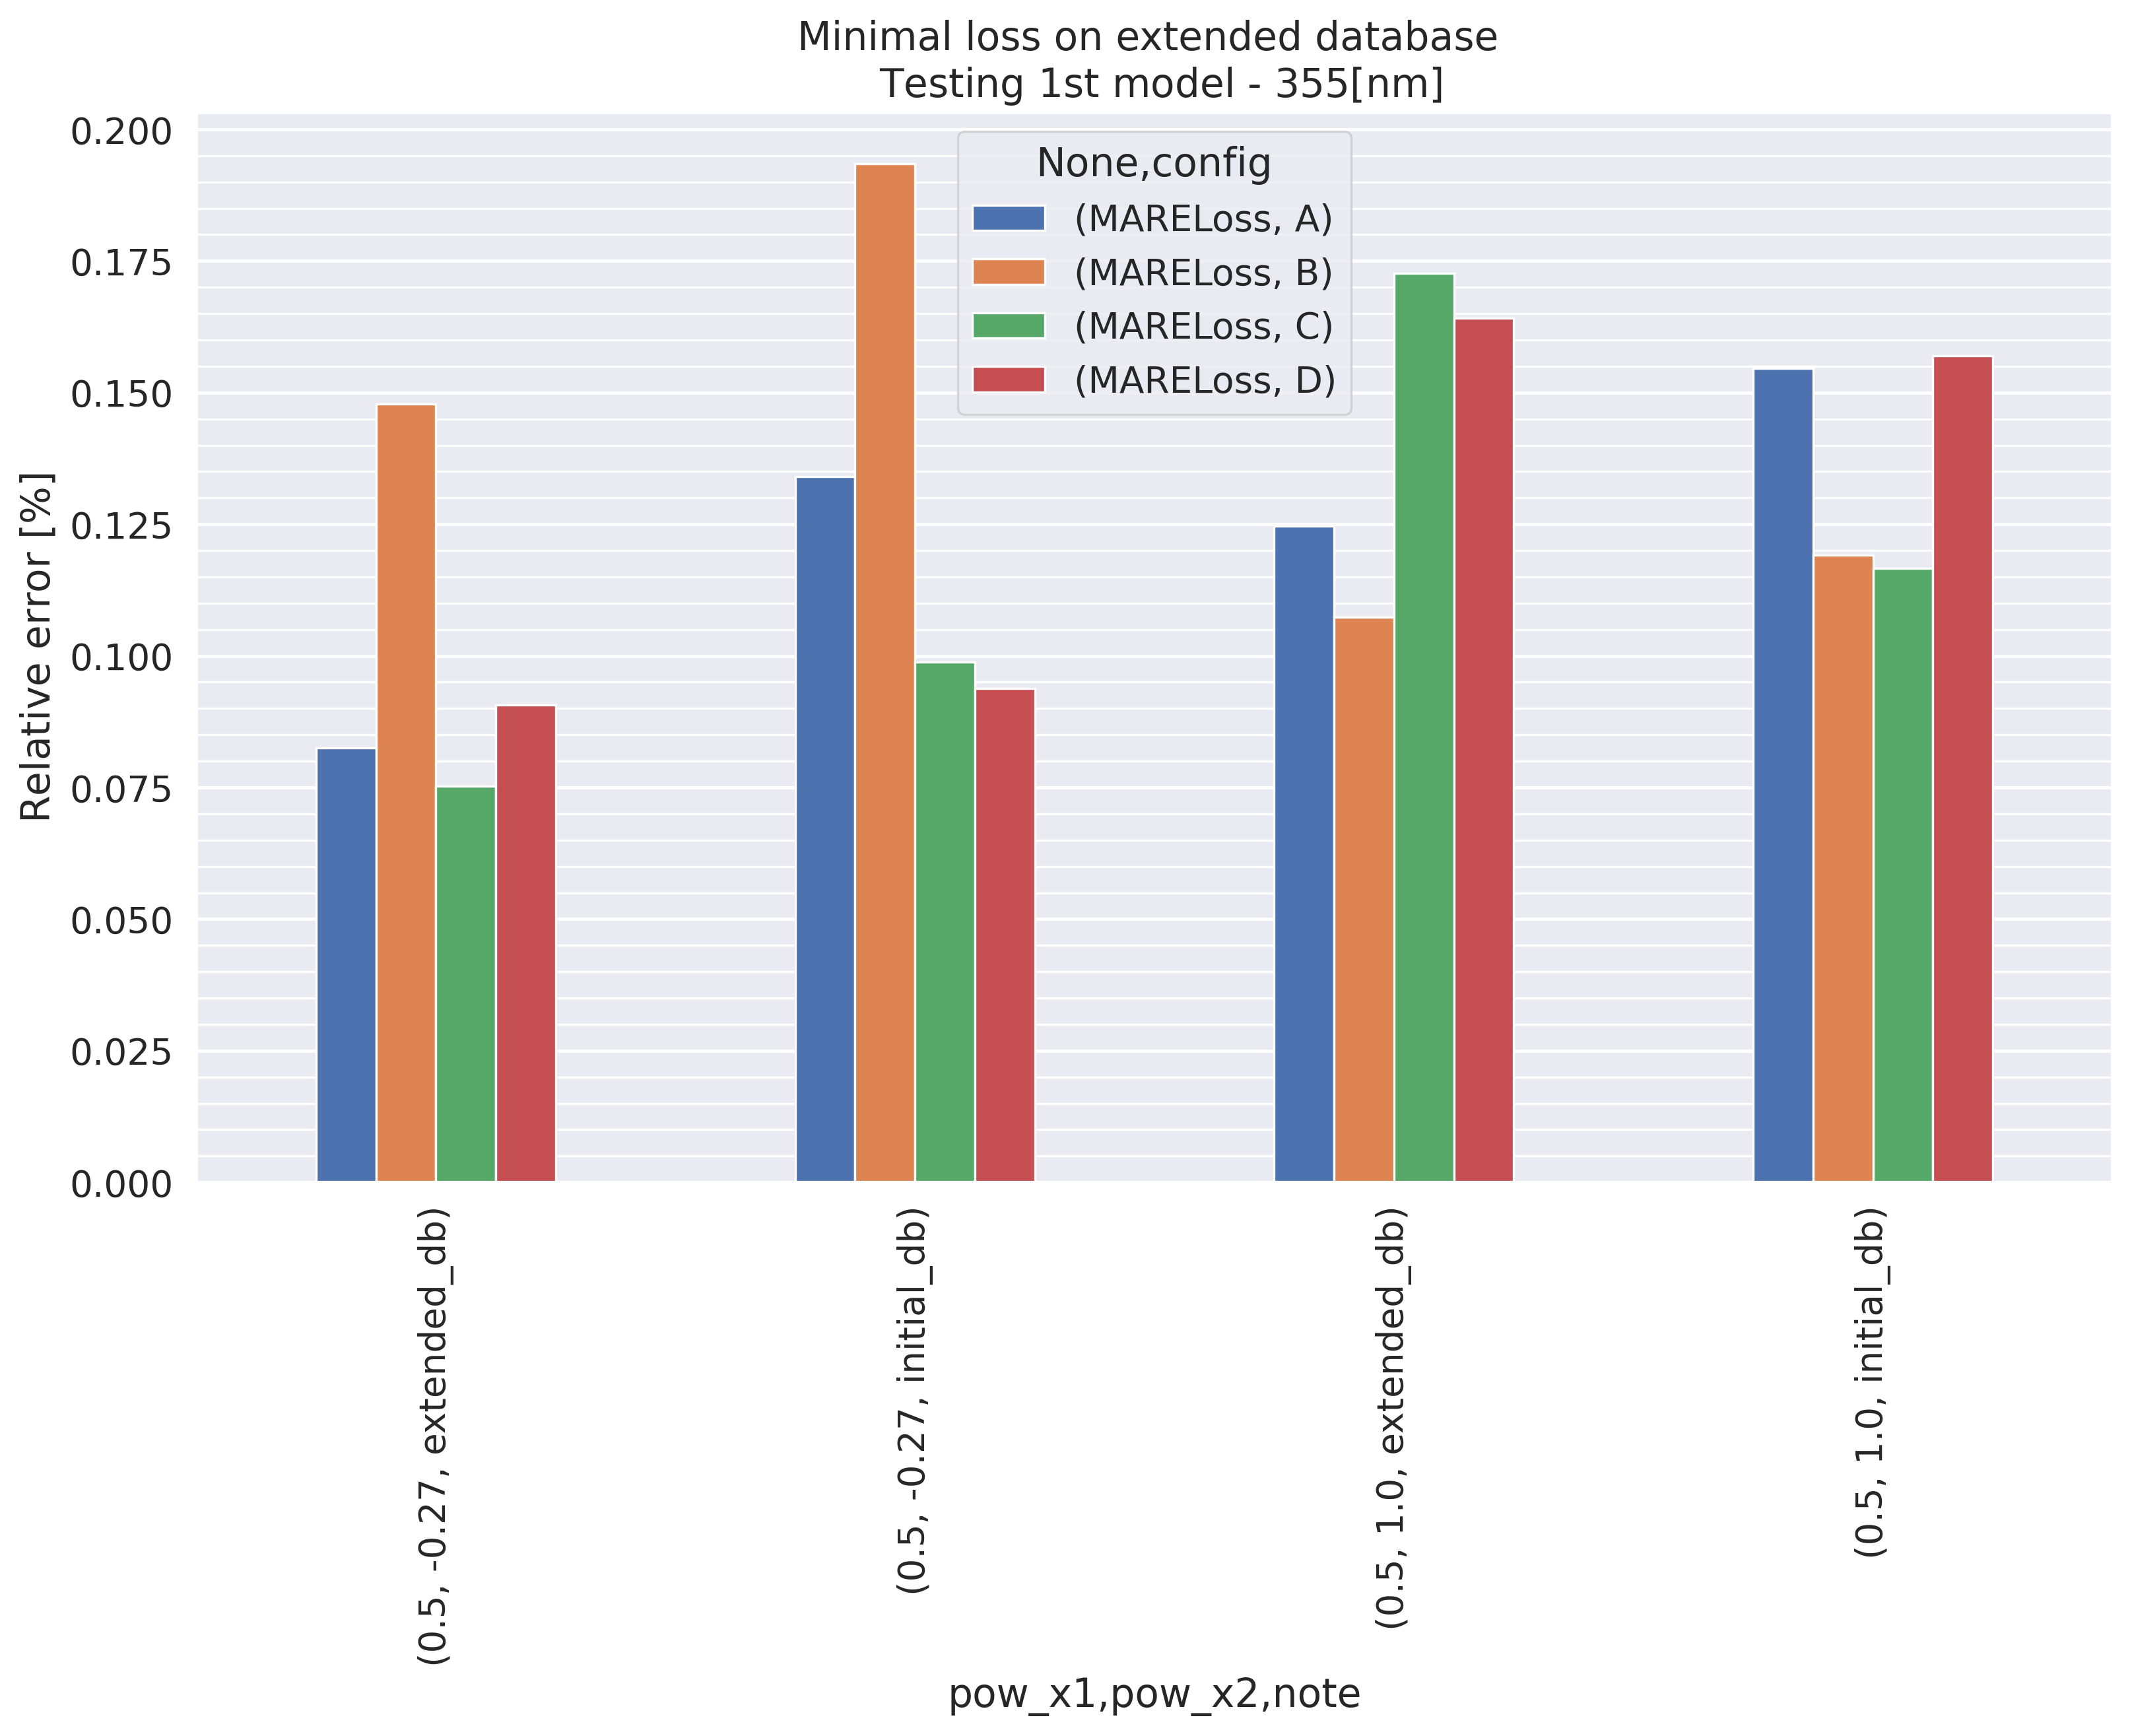

<ipython-input-23-ee92460ba052>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],


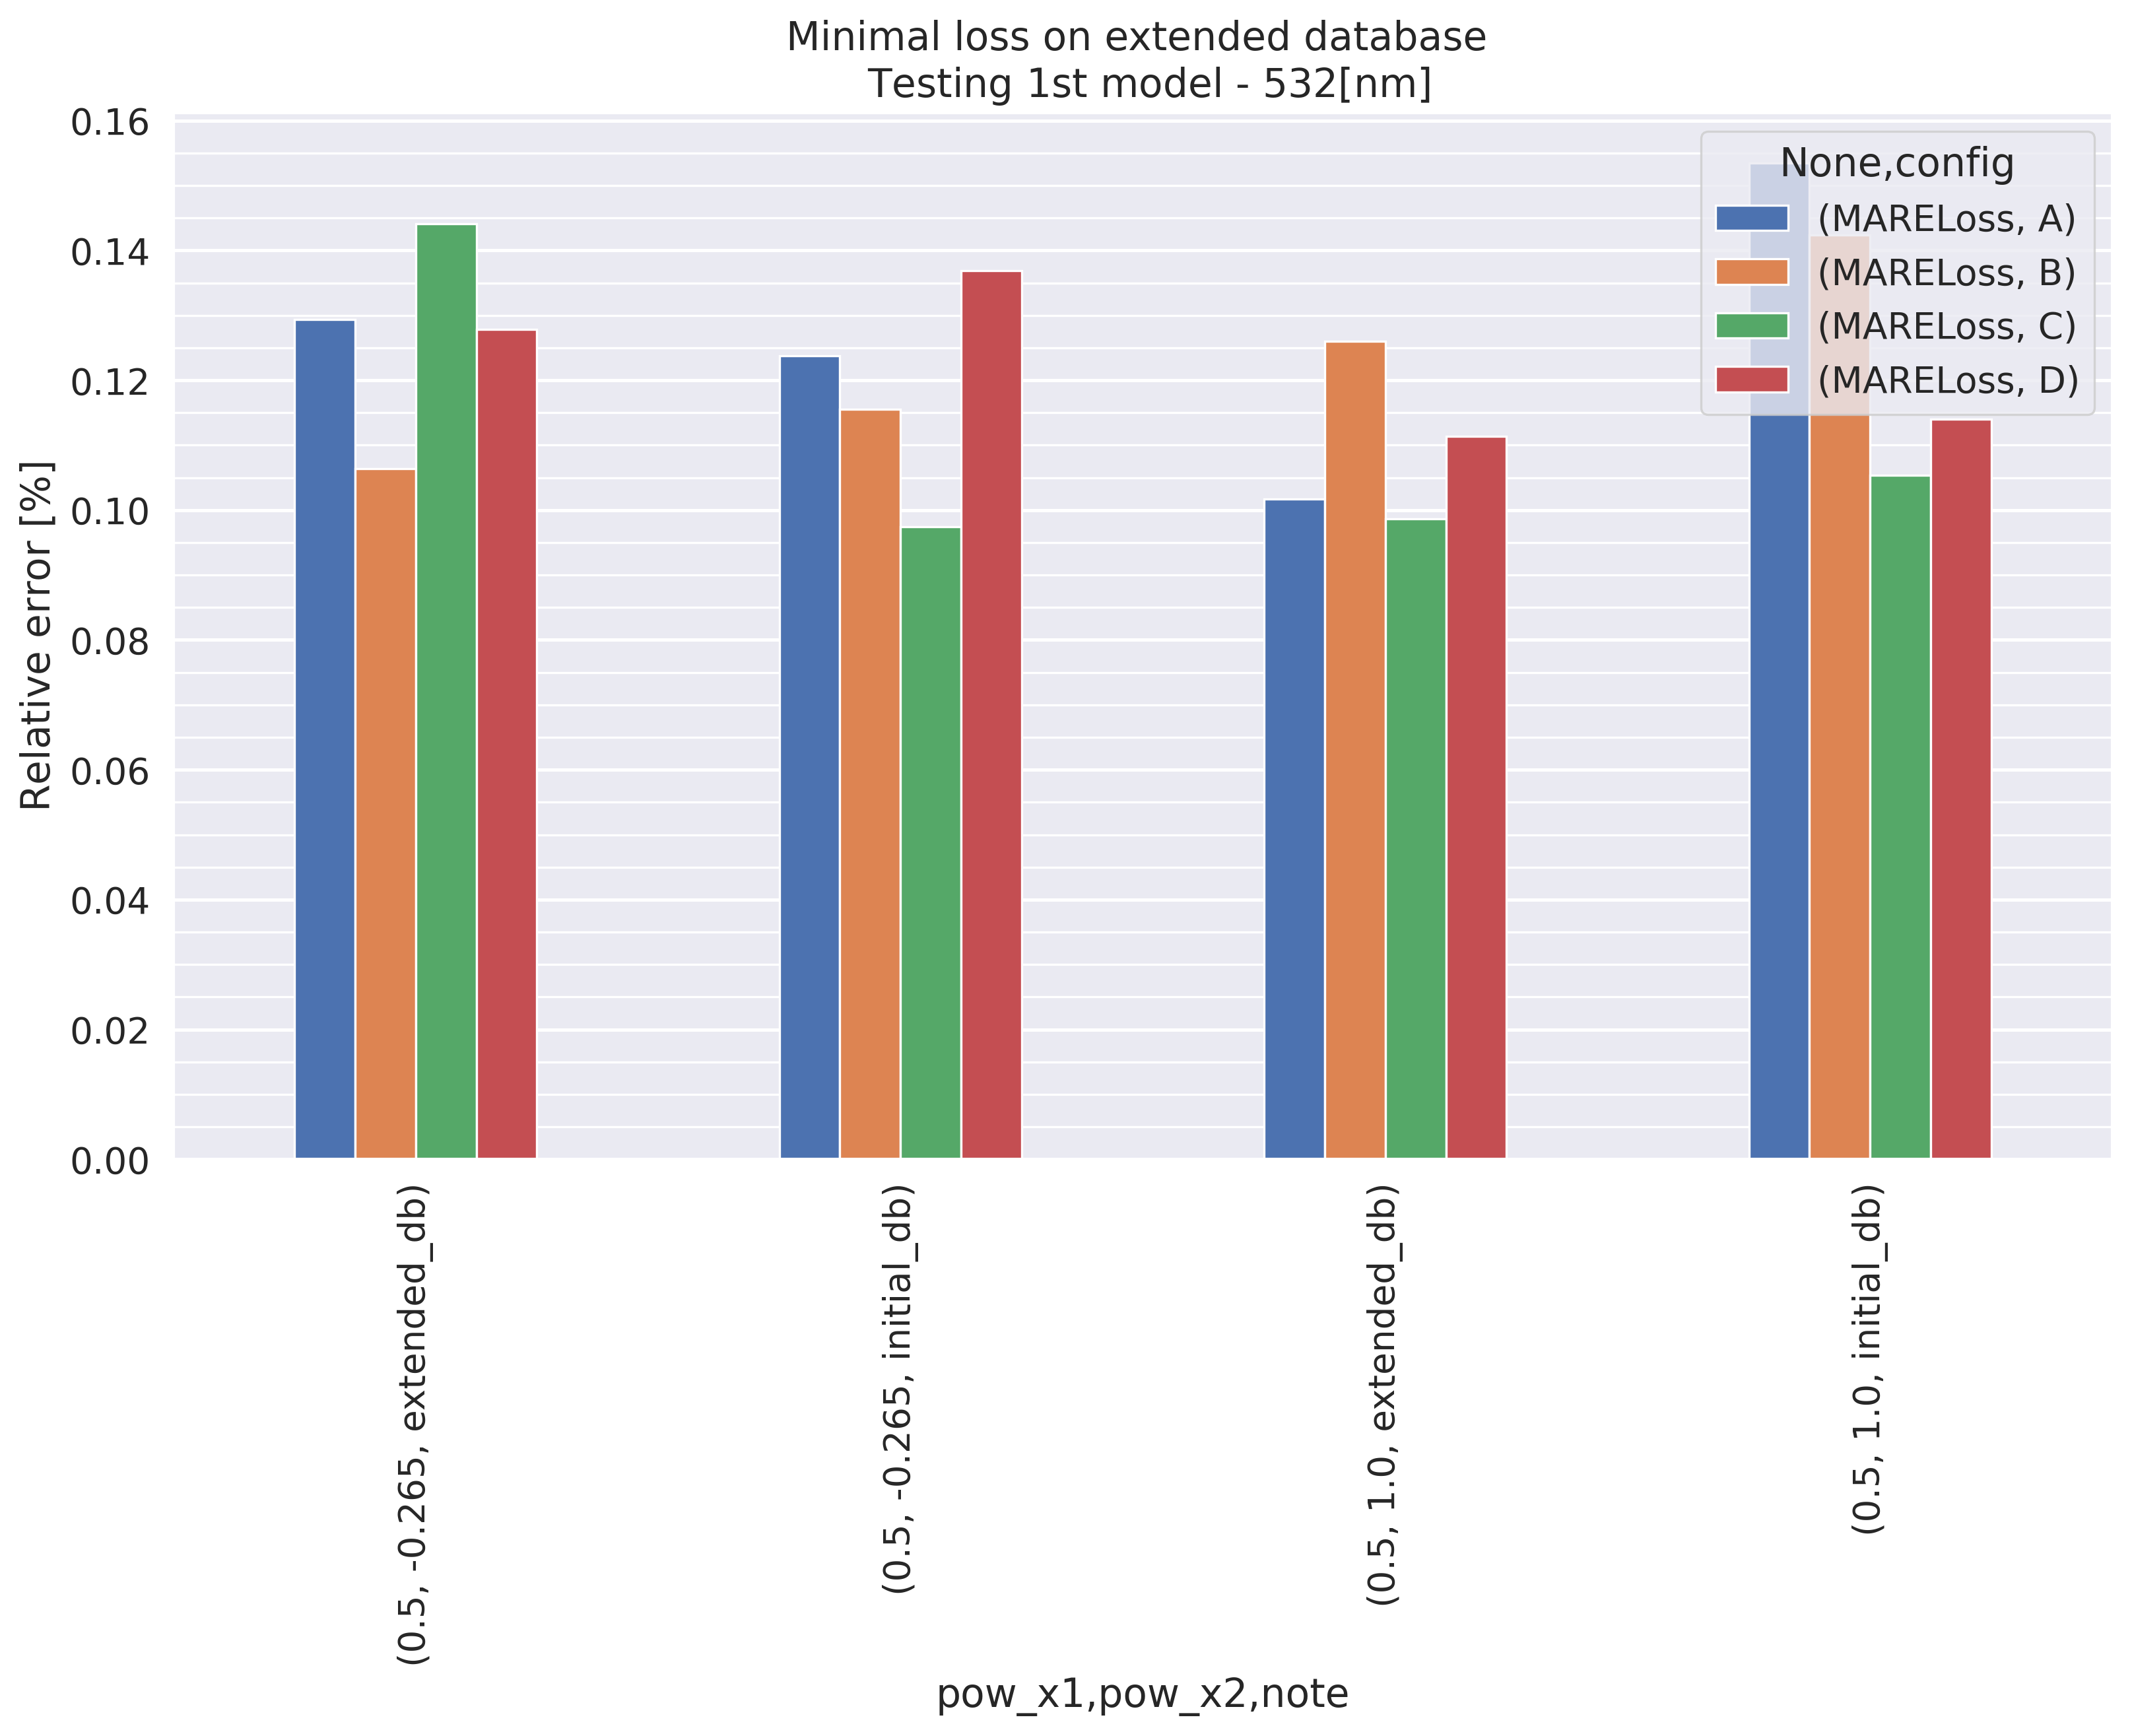

<ipython-input-23-ee92460ba052>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],


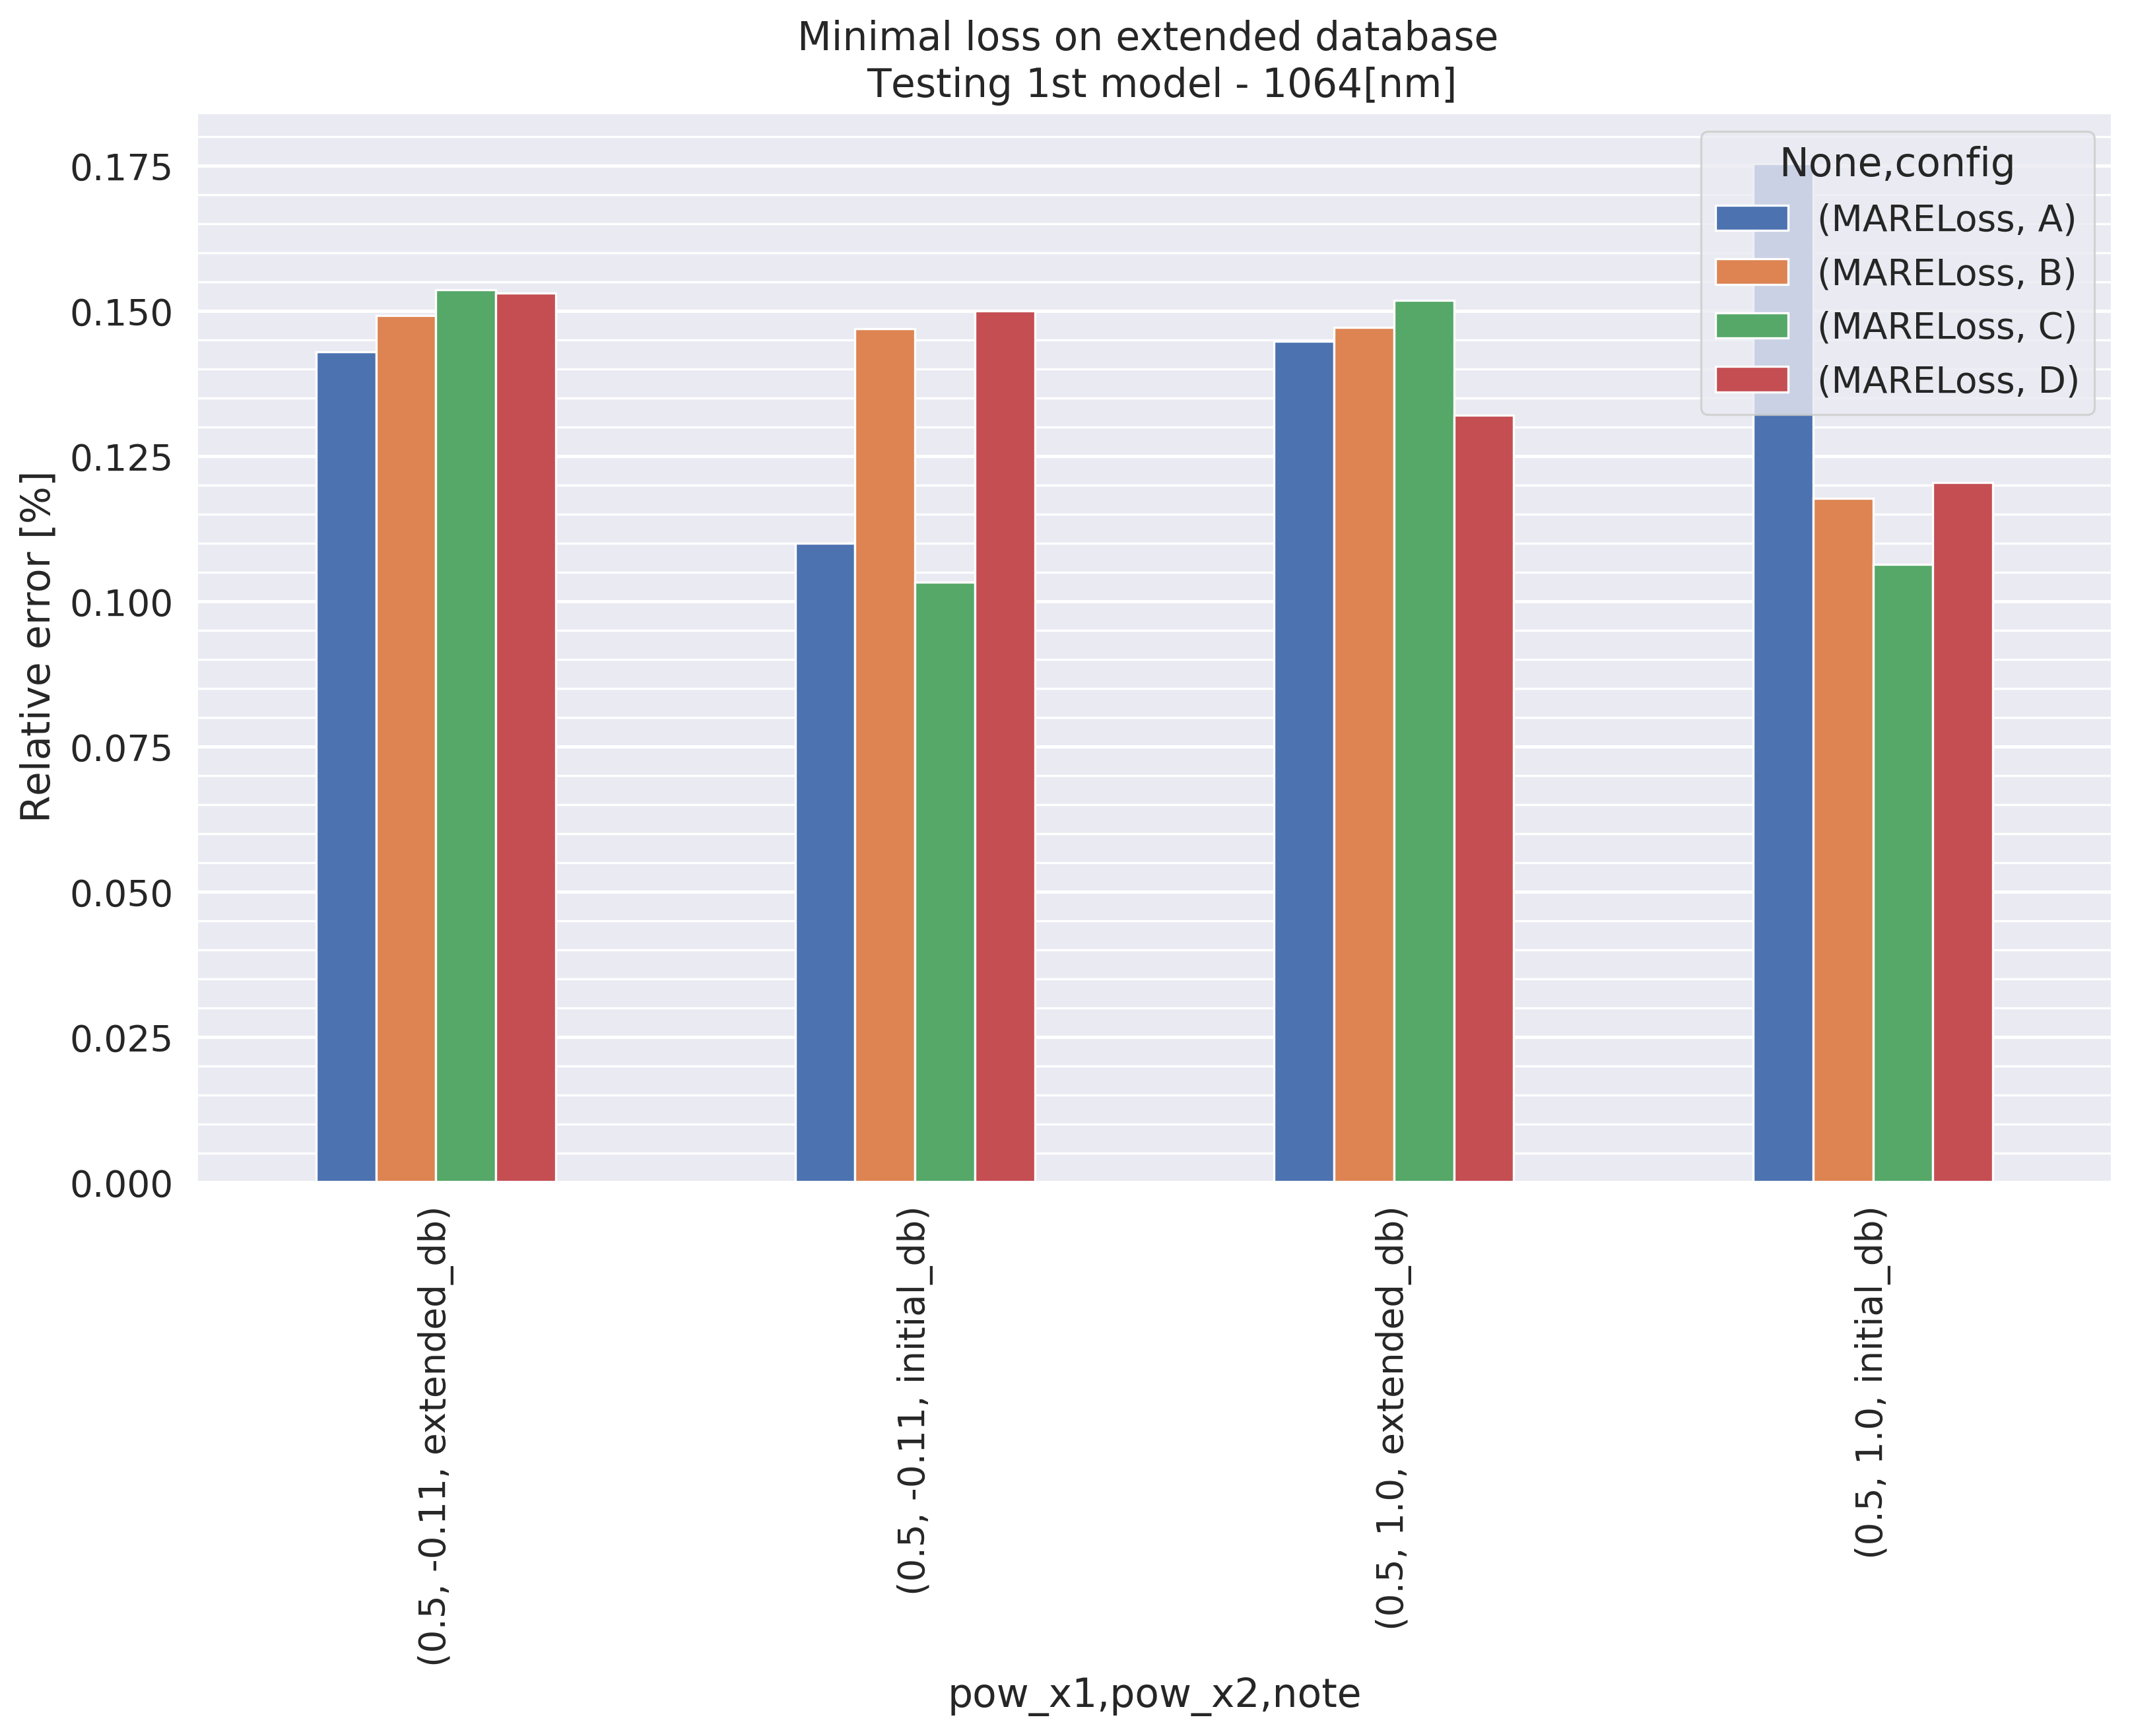

In [23]:
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 9))
    pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_bg==False][all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['pow_x1','pow_x2','note'],
                   aggfunc=np.mean).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on extended database \n Testing 1st model - '+ fr'${wavelength}[\rm nm]$' )
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    plt.tight_layout()
    plt.show()

<ipython-input-24-1ade521e2fb3>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']


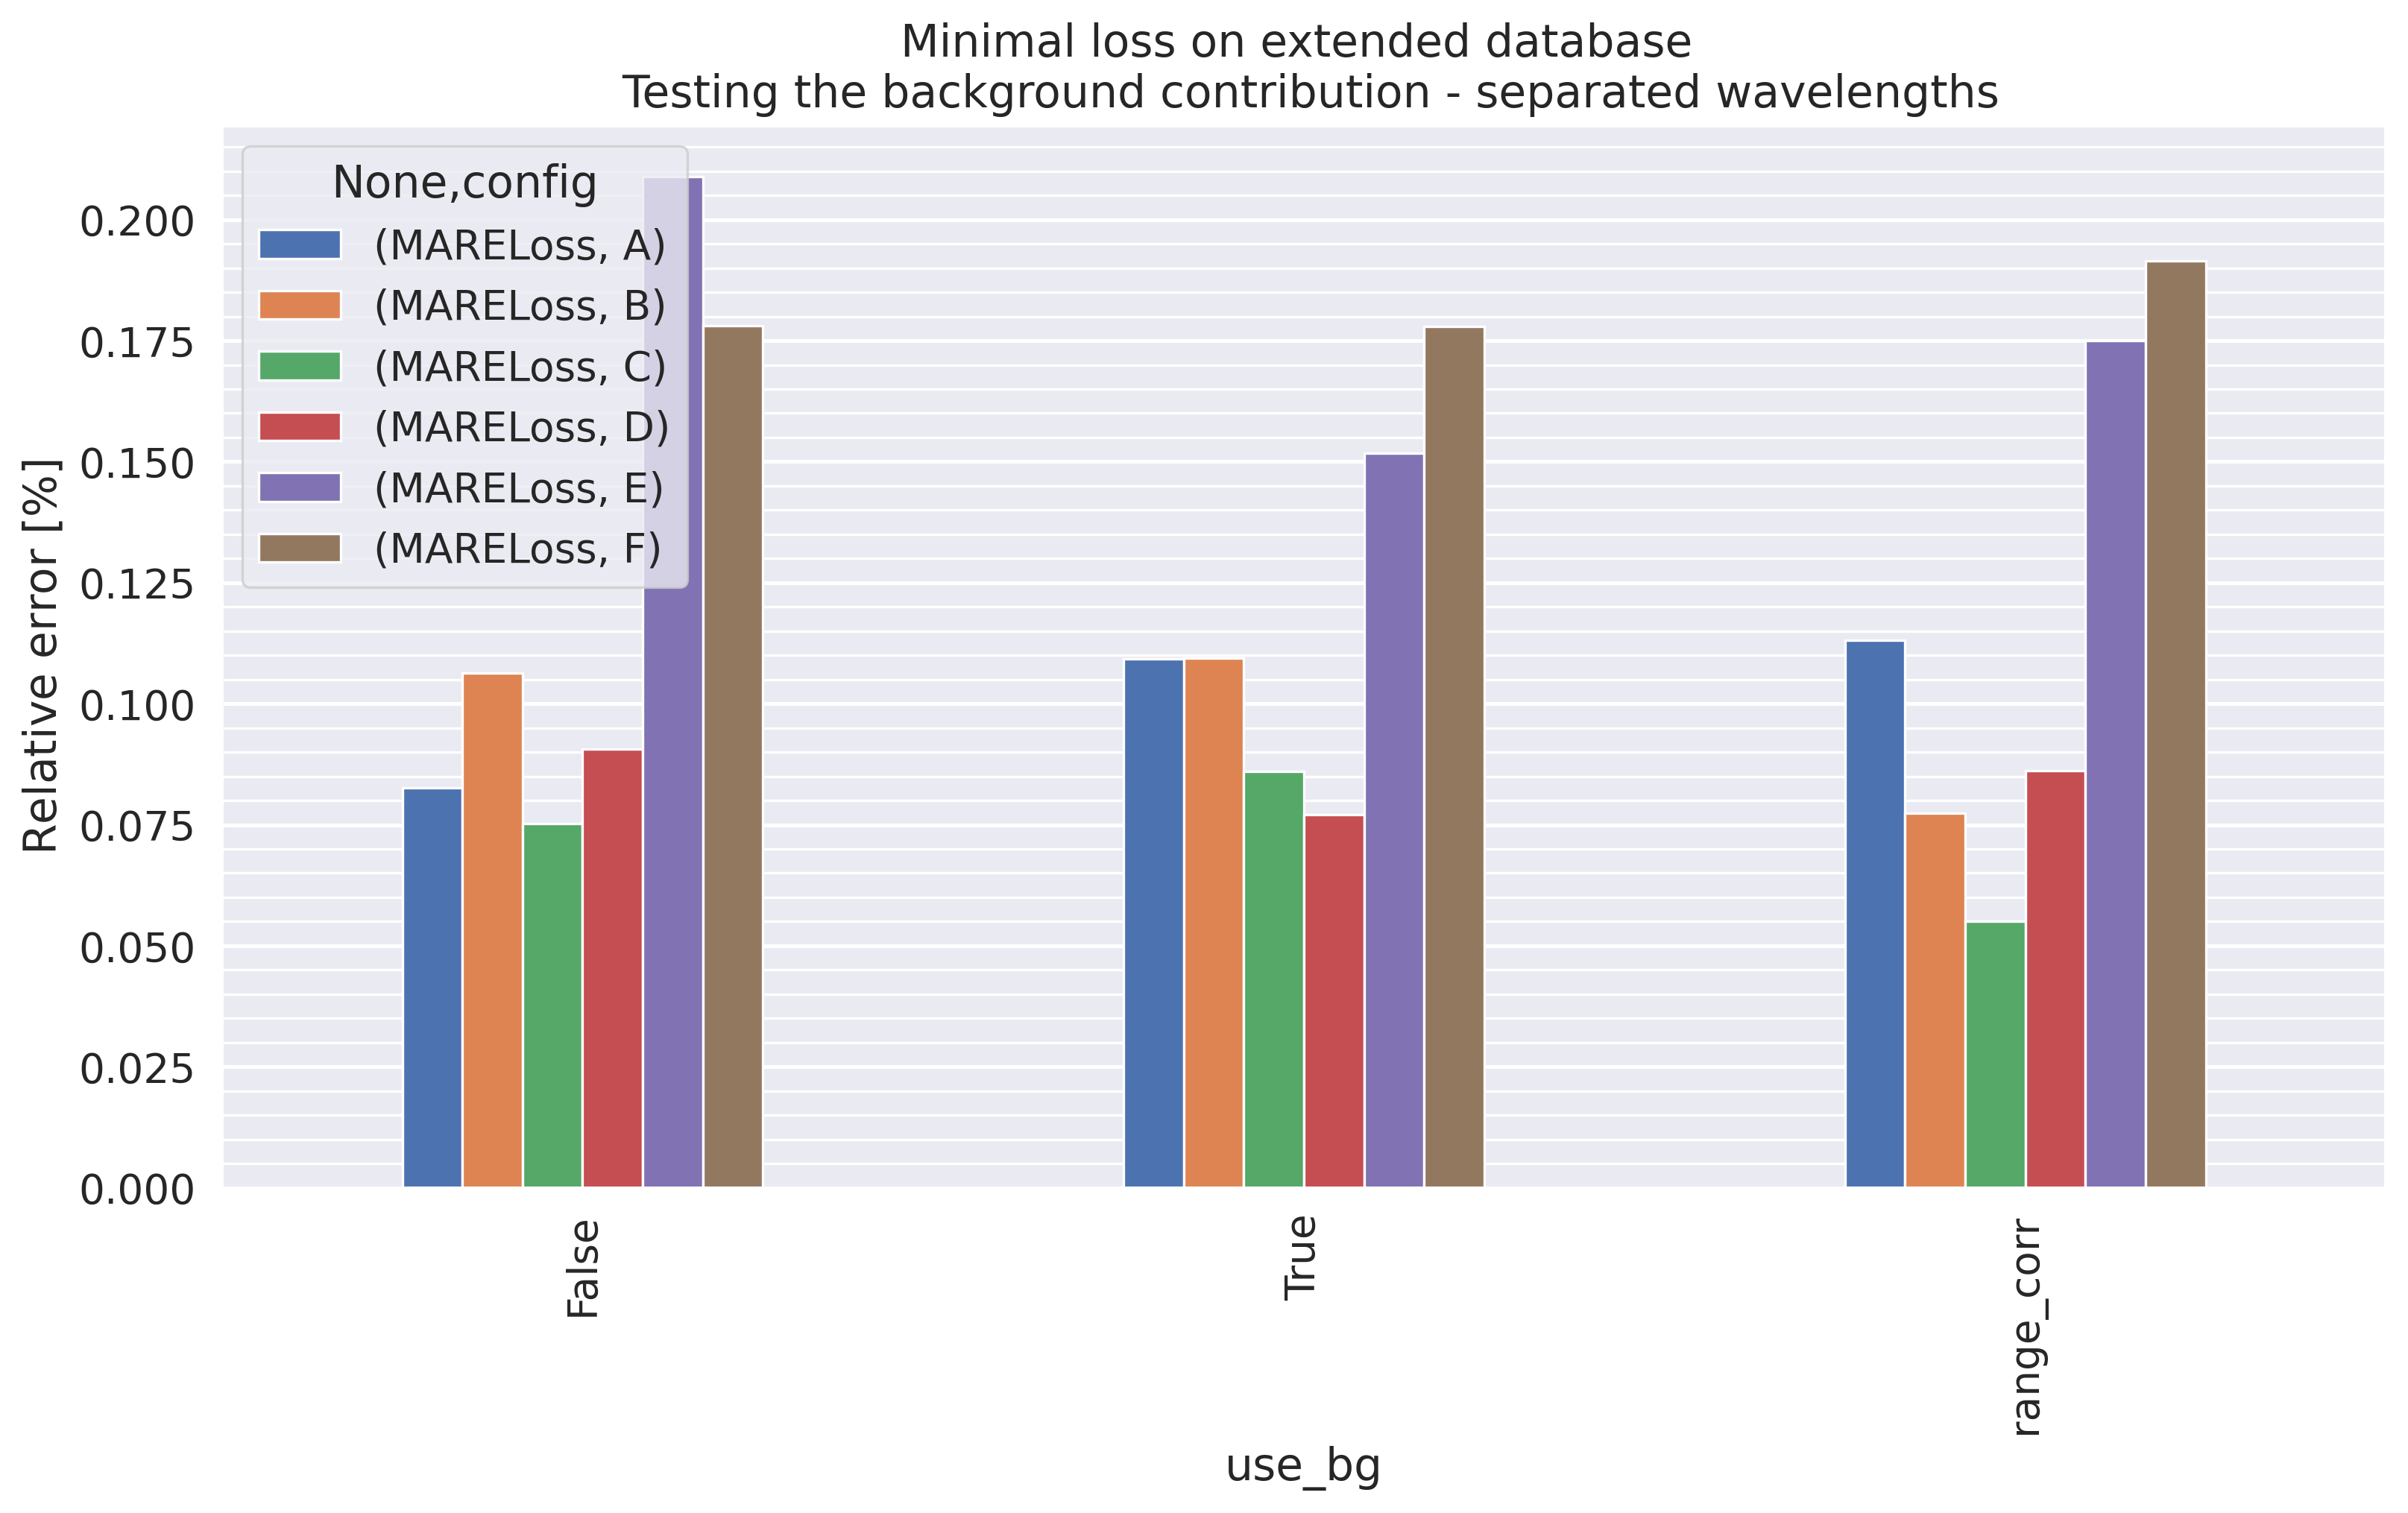

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.note=='extended_db']
               [all_wavs_configABCD.wavelength!='all'],
               values=['MARELoss'],
               columns= ['config'],
               index=['use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on extended database \n Testing the background contribution - separated wavelengths')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-25-b4baf008d0ee>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power][all_wavs_configABCD.wavelength==wavelength],#[all_wavs_configABCD.note!='initial_db_overlap'],


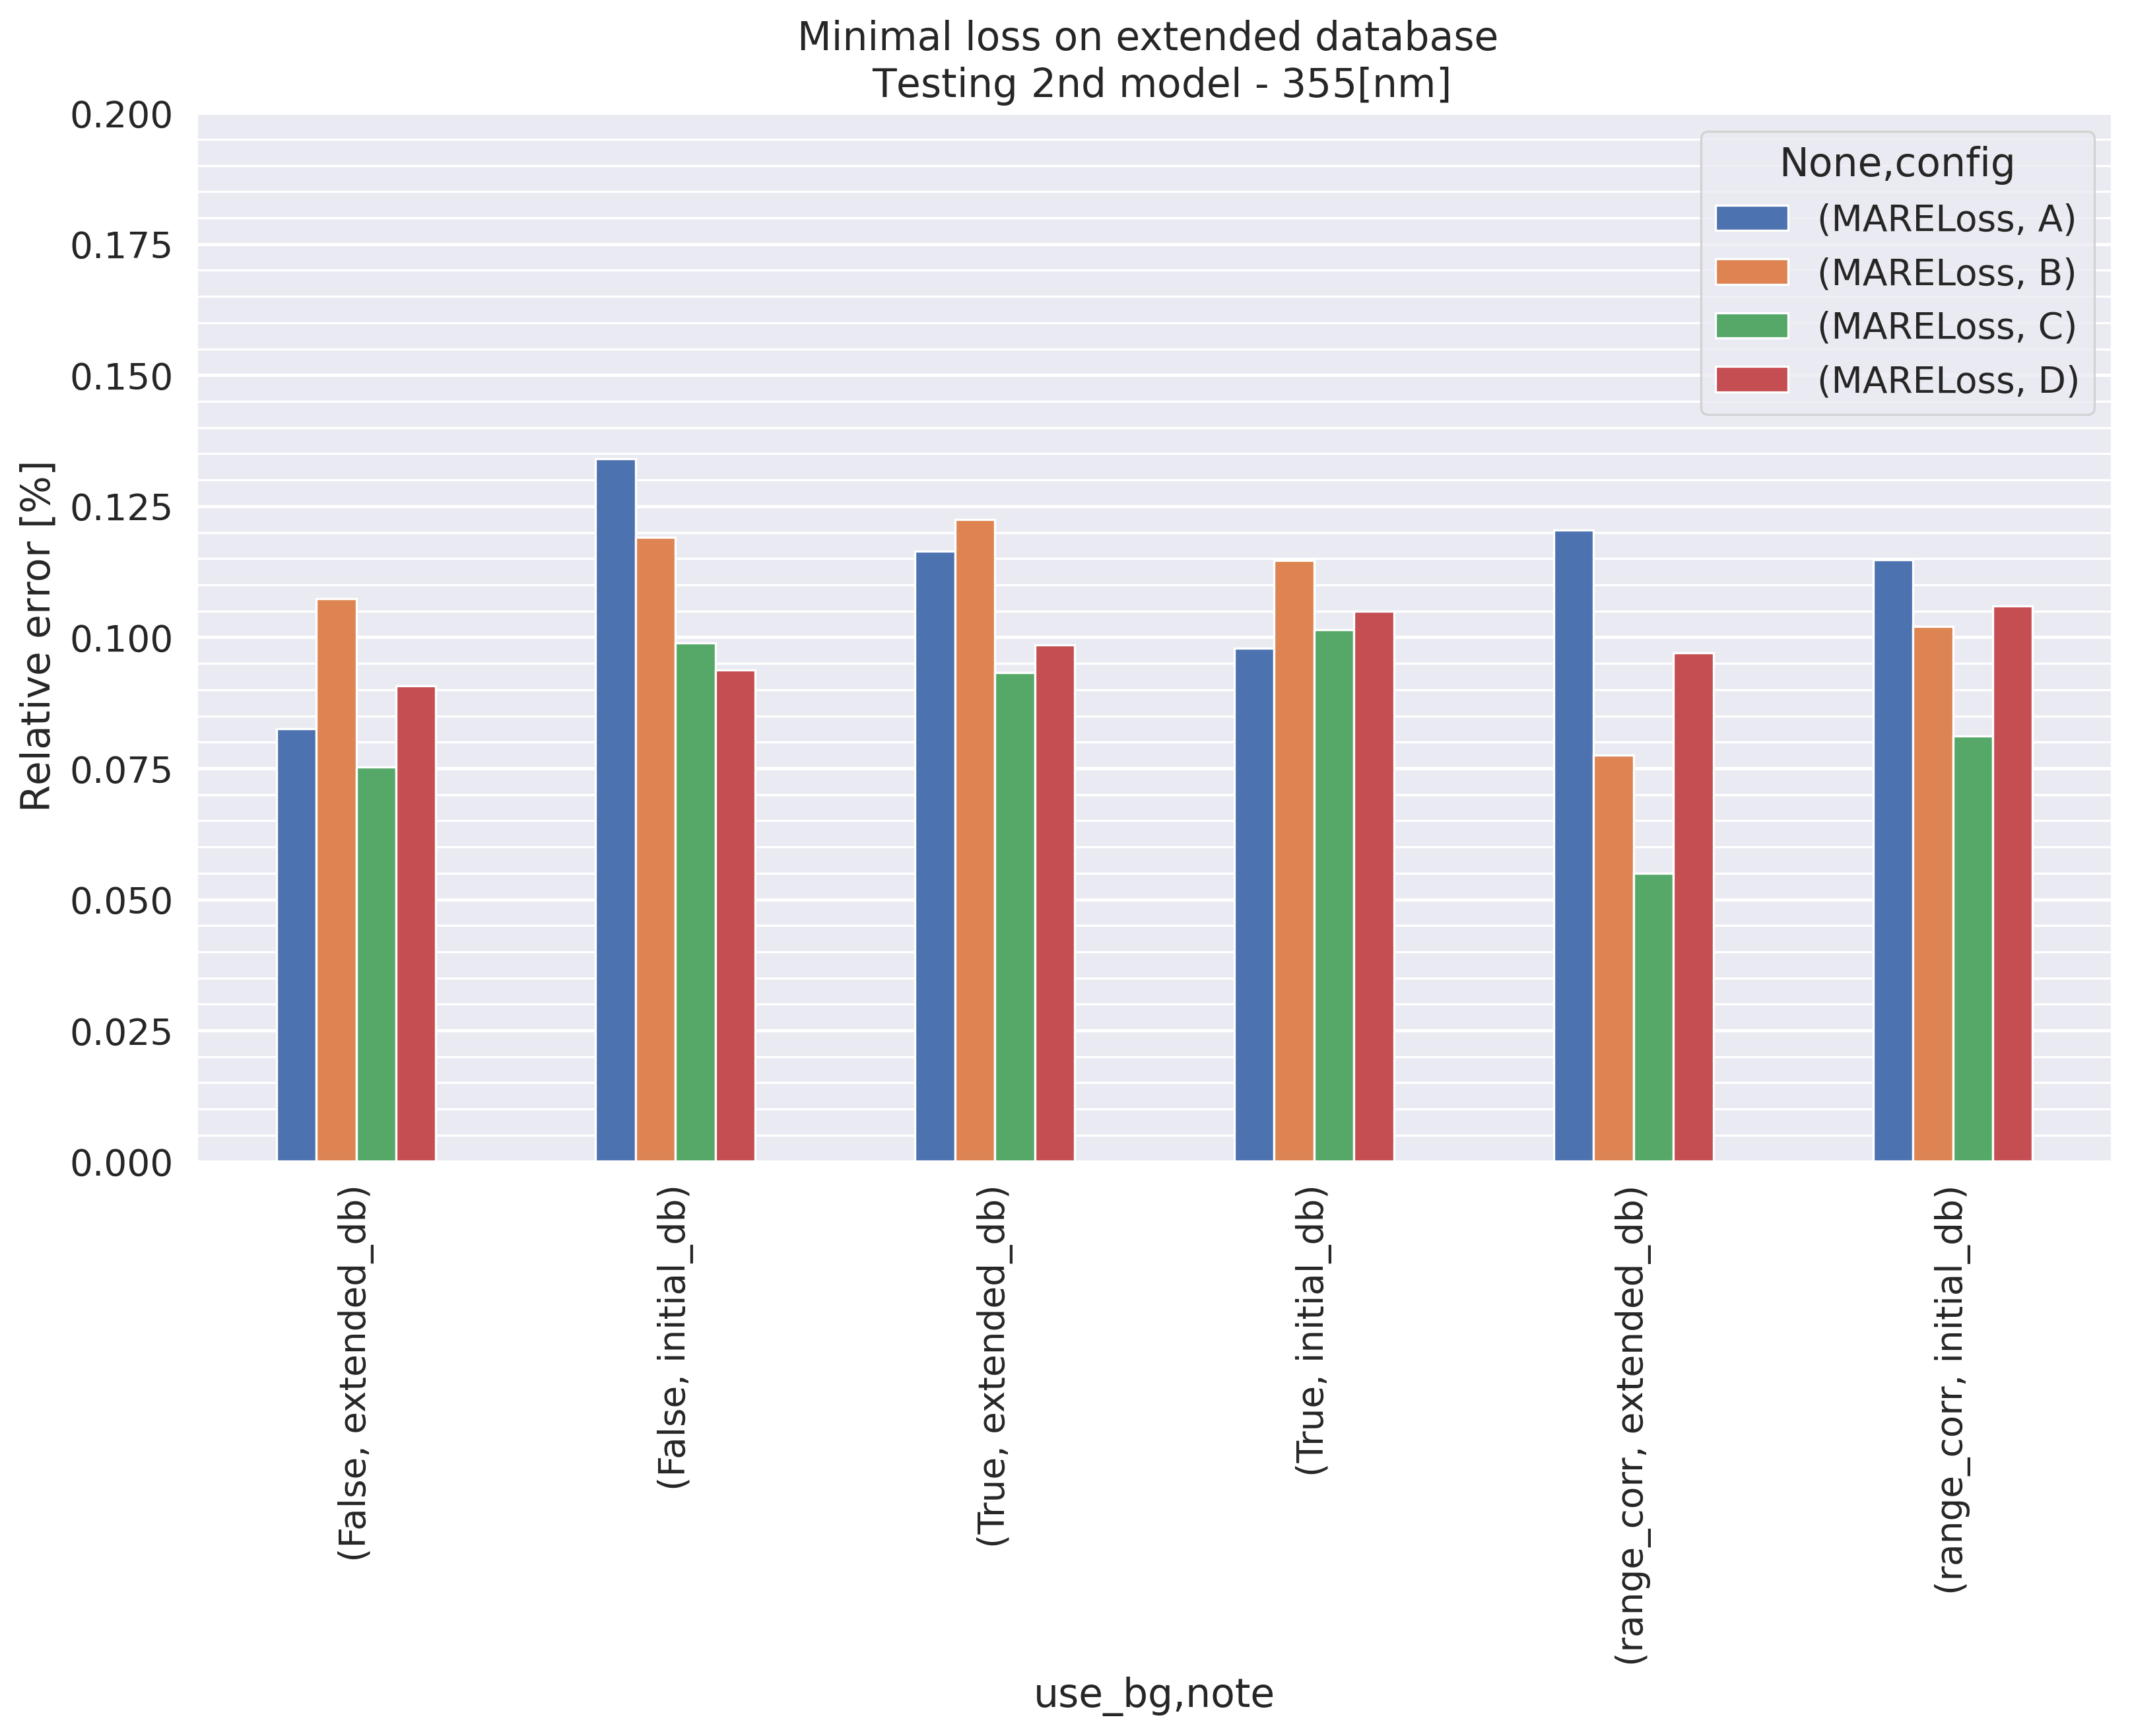

<ipython-input-25-b4baf008d0ee>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power][all_wavs_configABCD.wavelength==wavelength],#[all_wavs_configABCD.note!='initial_db_overlap'],


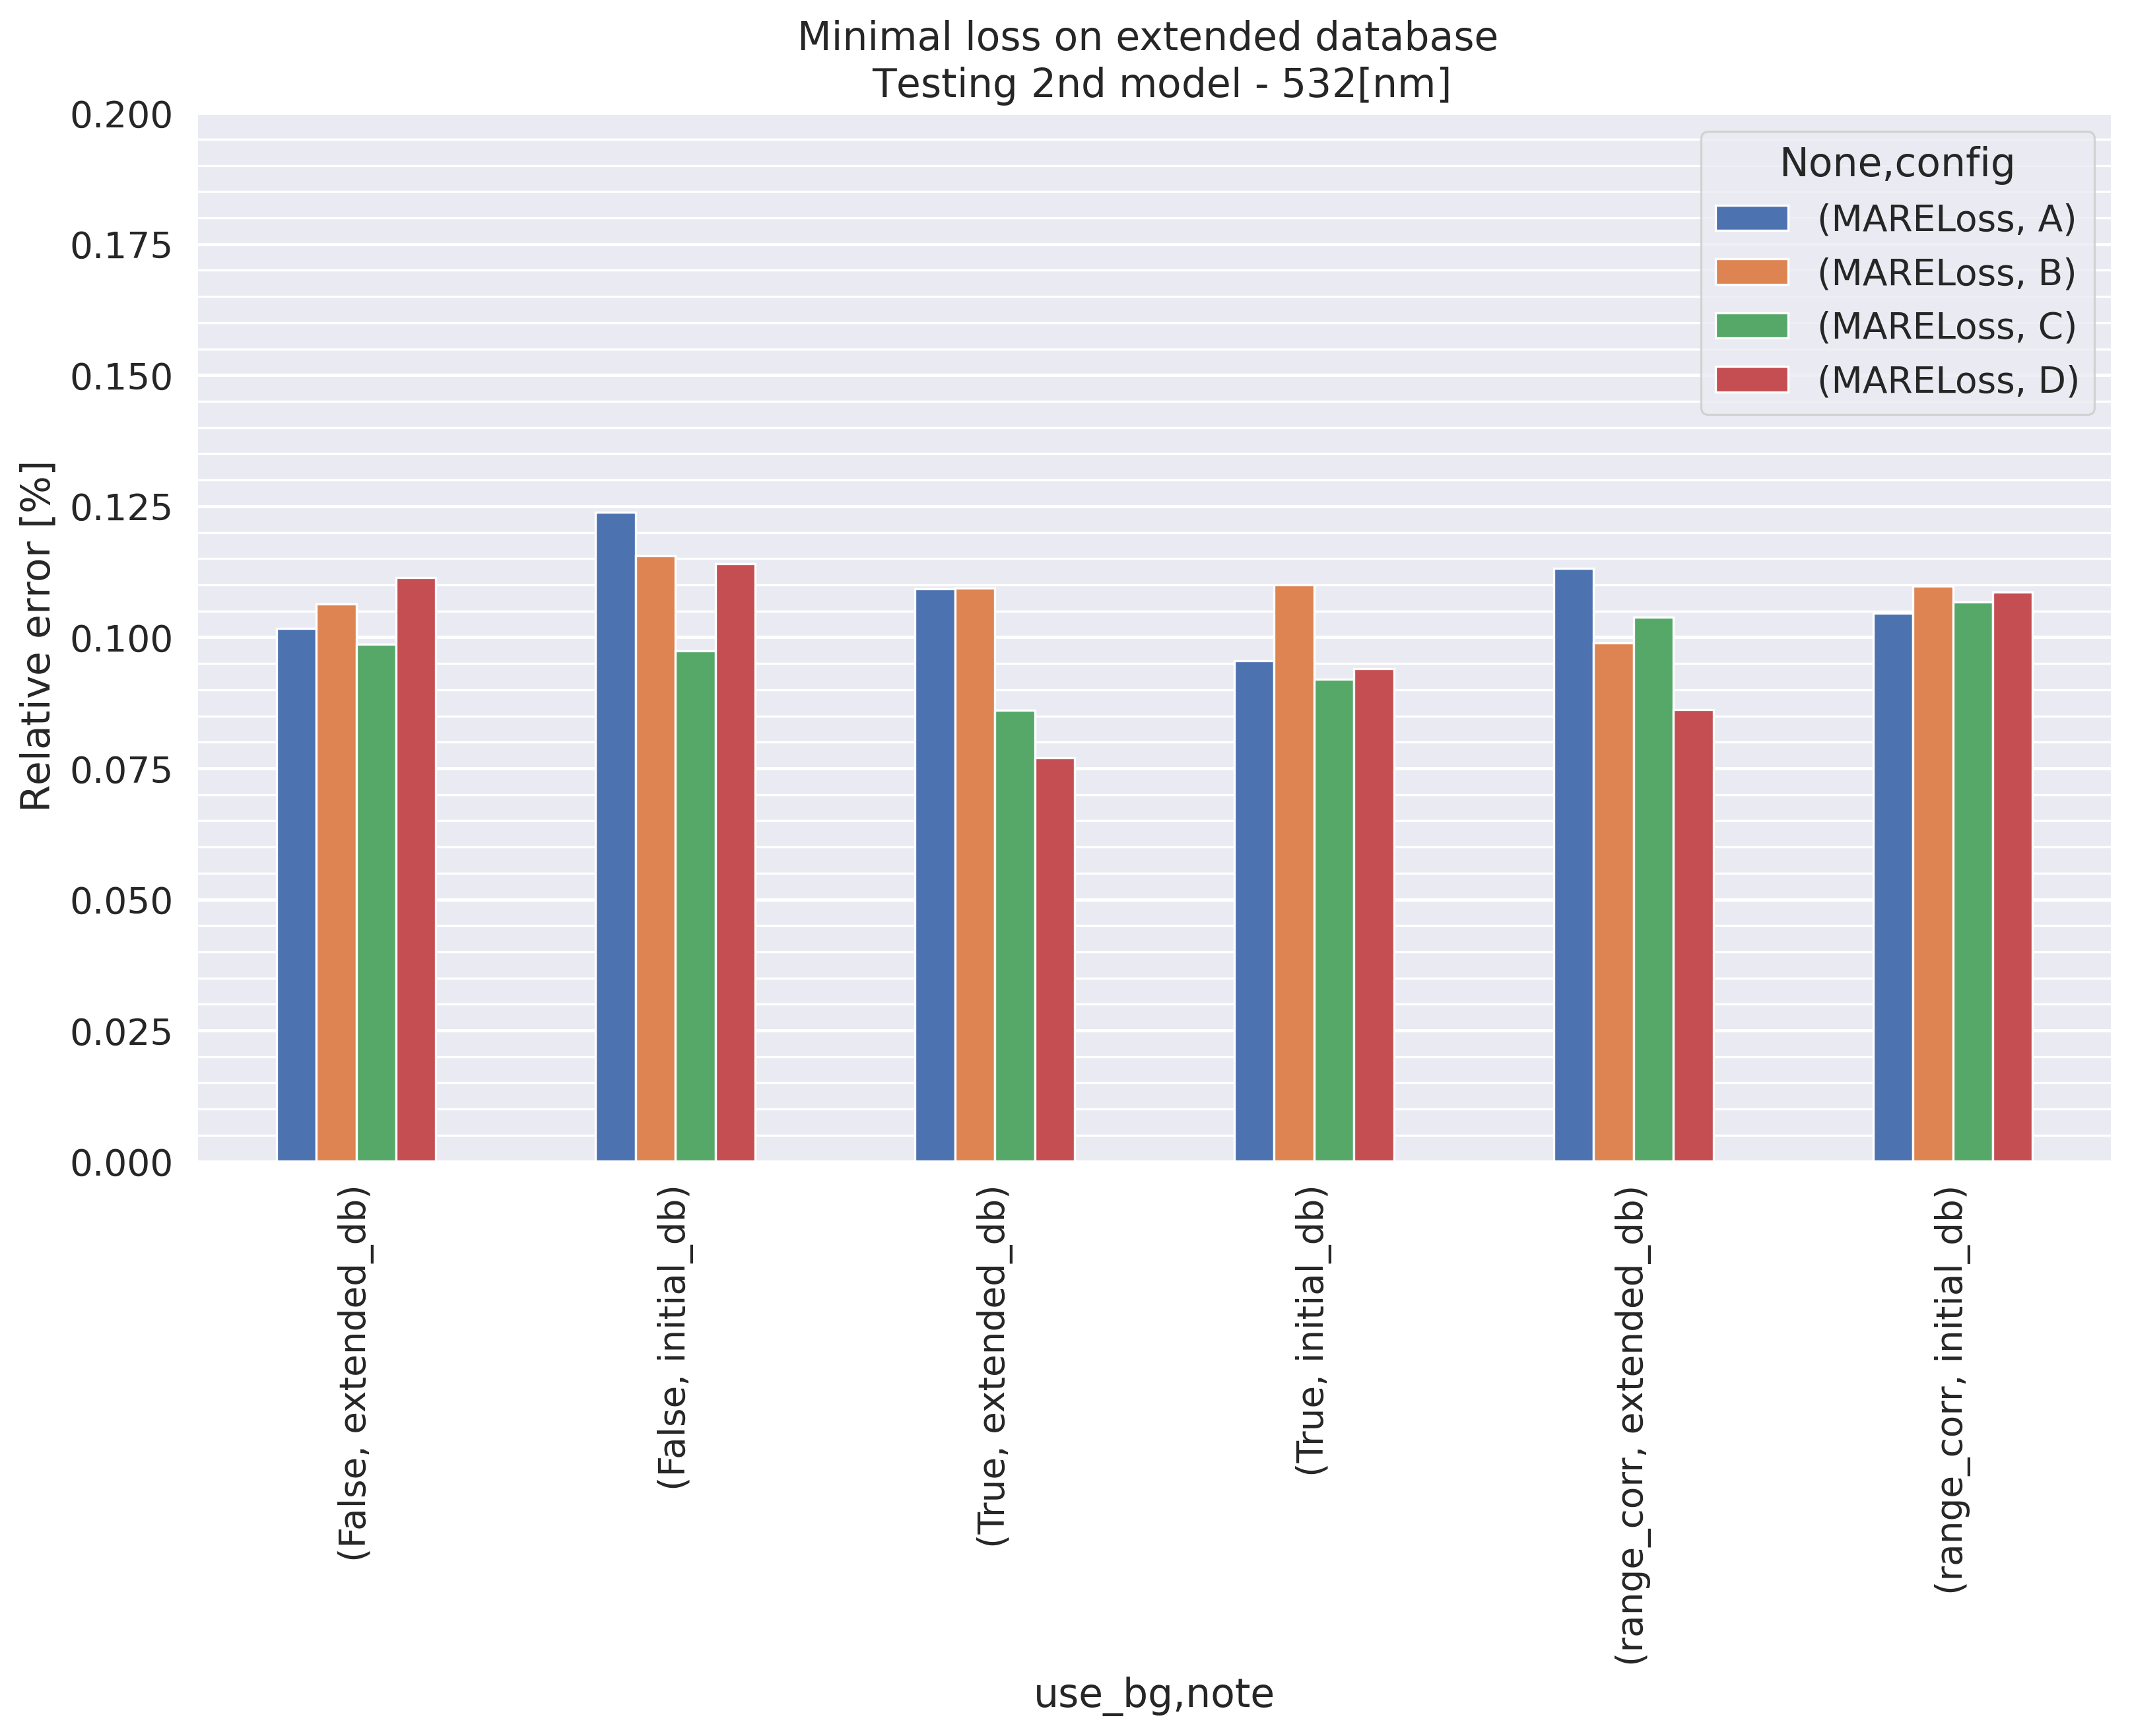

<ipython-input-25-b4baf008d0ee>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power][all_wavs_configABCD.wavelength==wavelength],#[all_wavs_configABCD.note!='initial_db_overlap'],


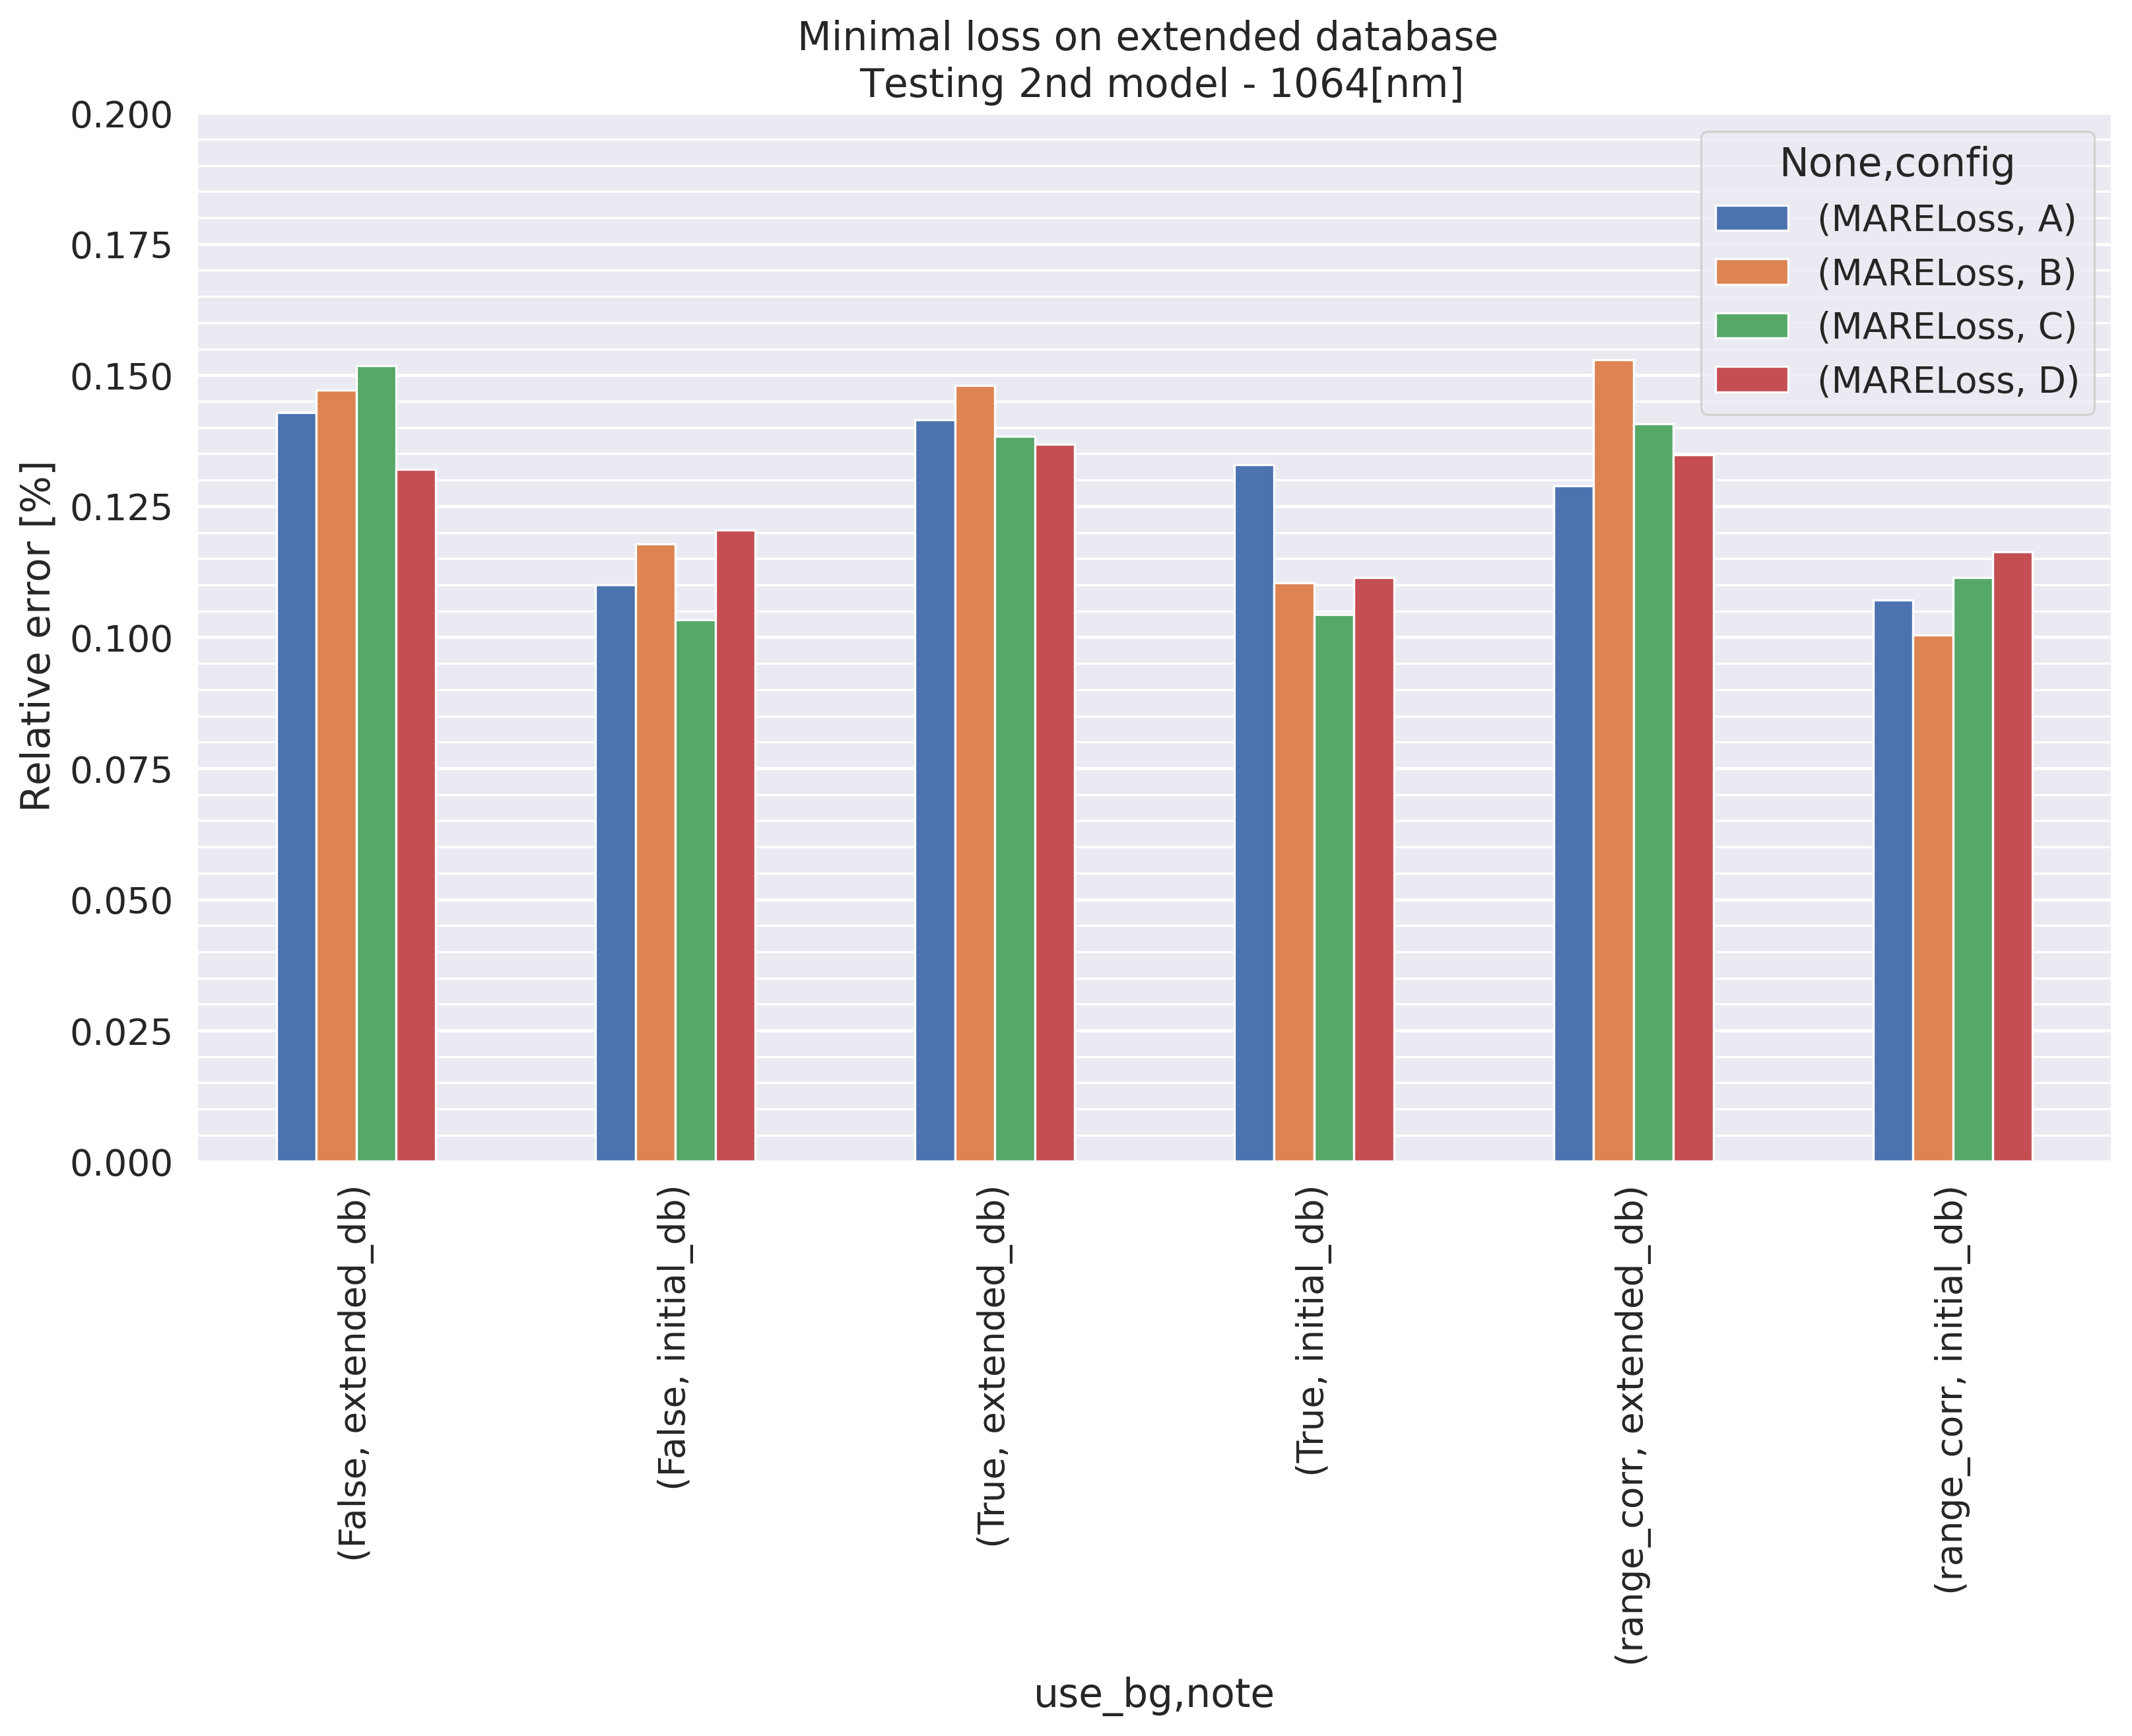

In [25]:
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 9))
    pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power][all_wavs_configABCD.wavelength==wavelength],#[all_wavs_configABCD.note!='initial_db_overlap'],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'note'],
                   aggfunc=np.min).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on extended database \n Testing 2nd model - '+ fr'${wavelength}[\rm nm]$' )
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    ax.set_ylim([0.0, 0.2])
    plt.tight_layout()
    plt.show()


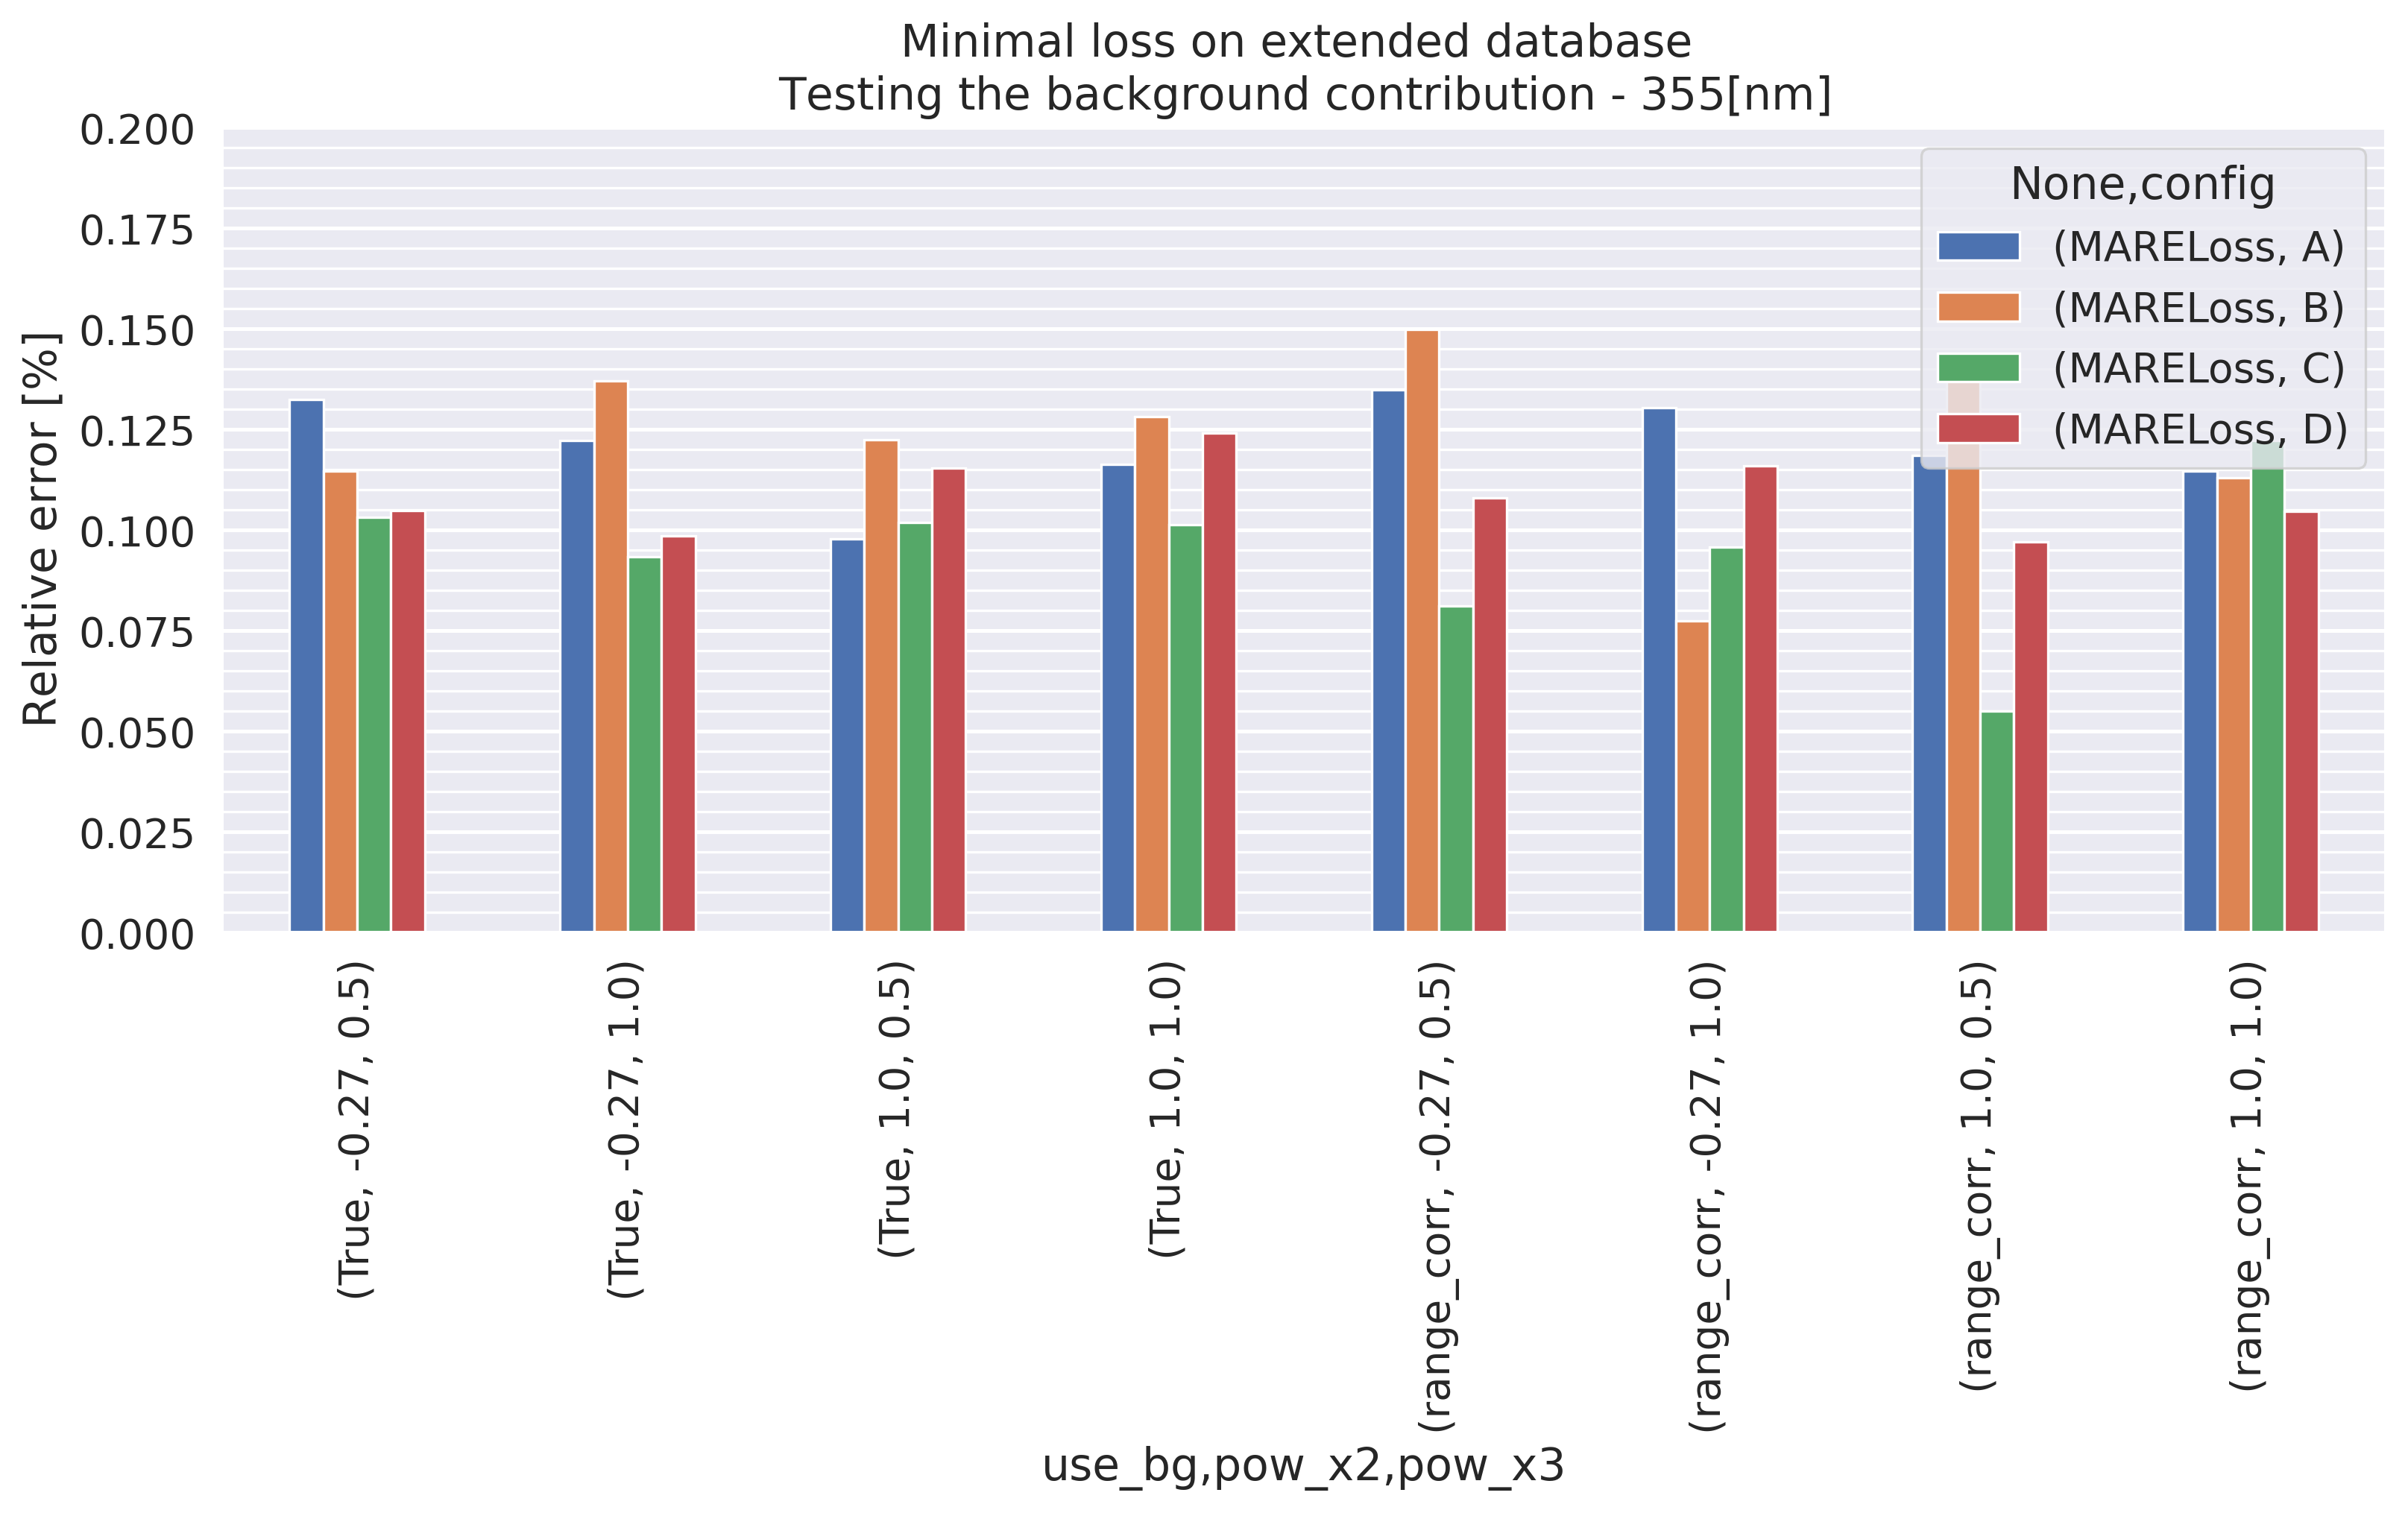

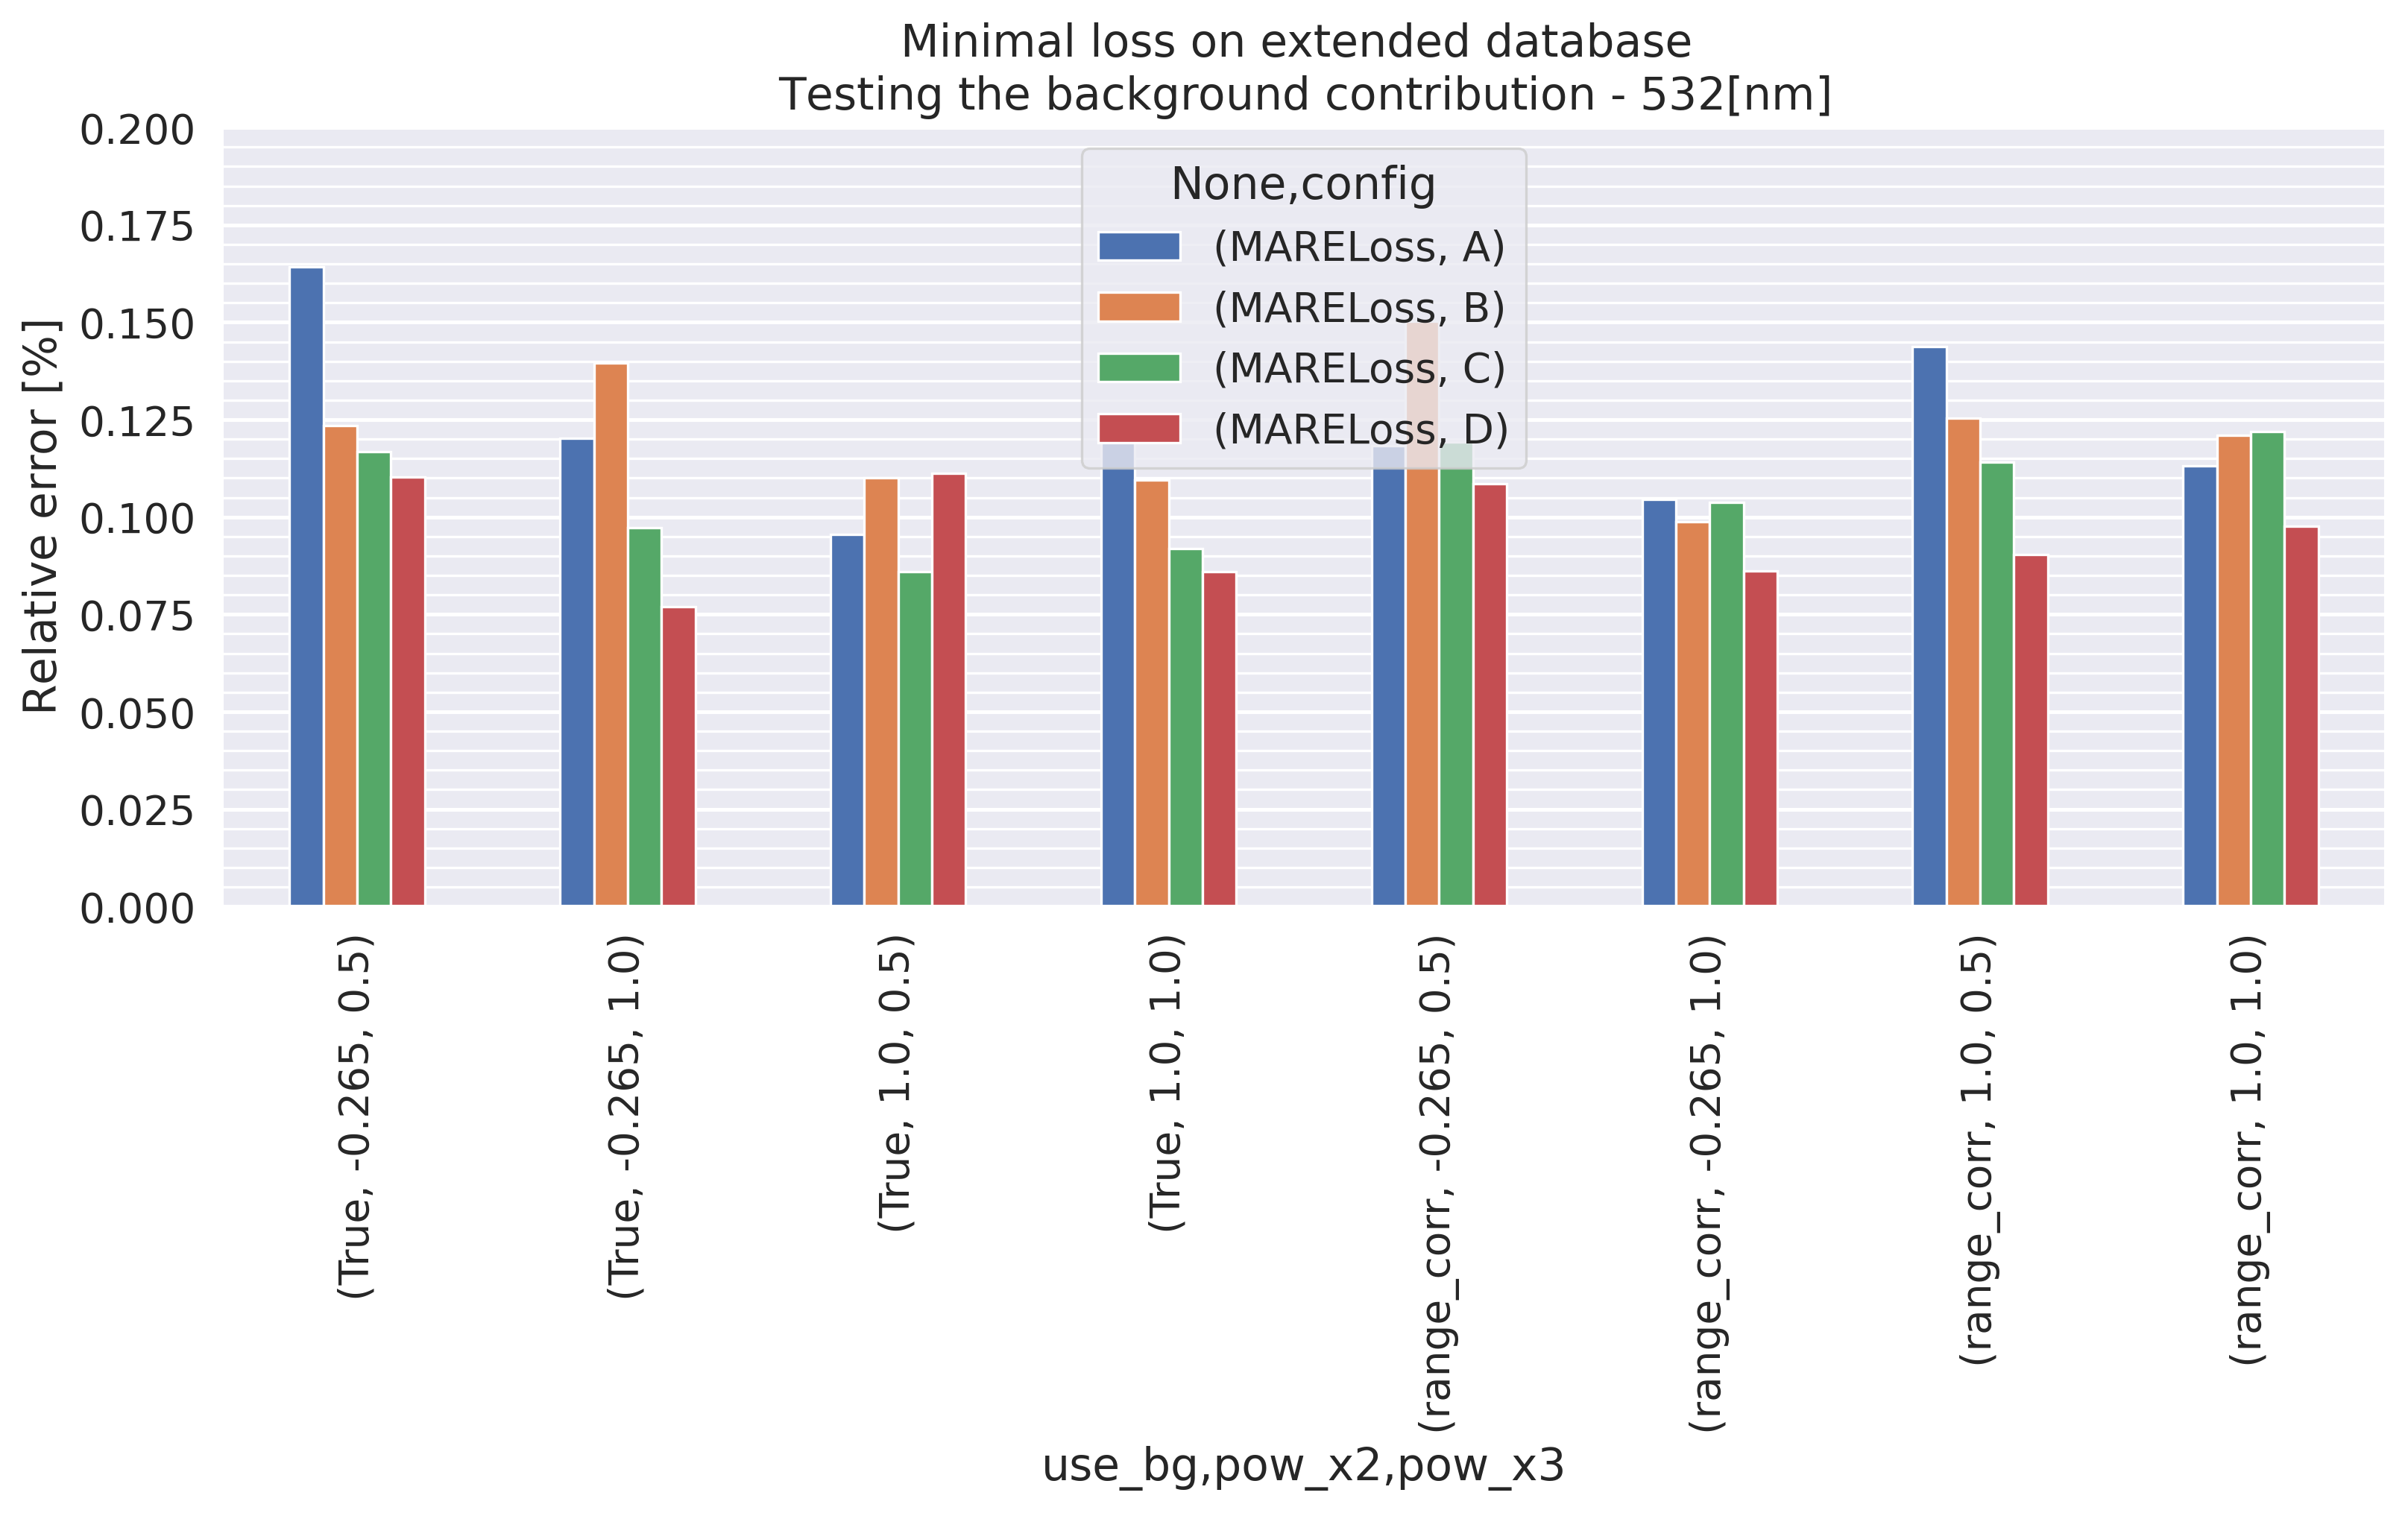

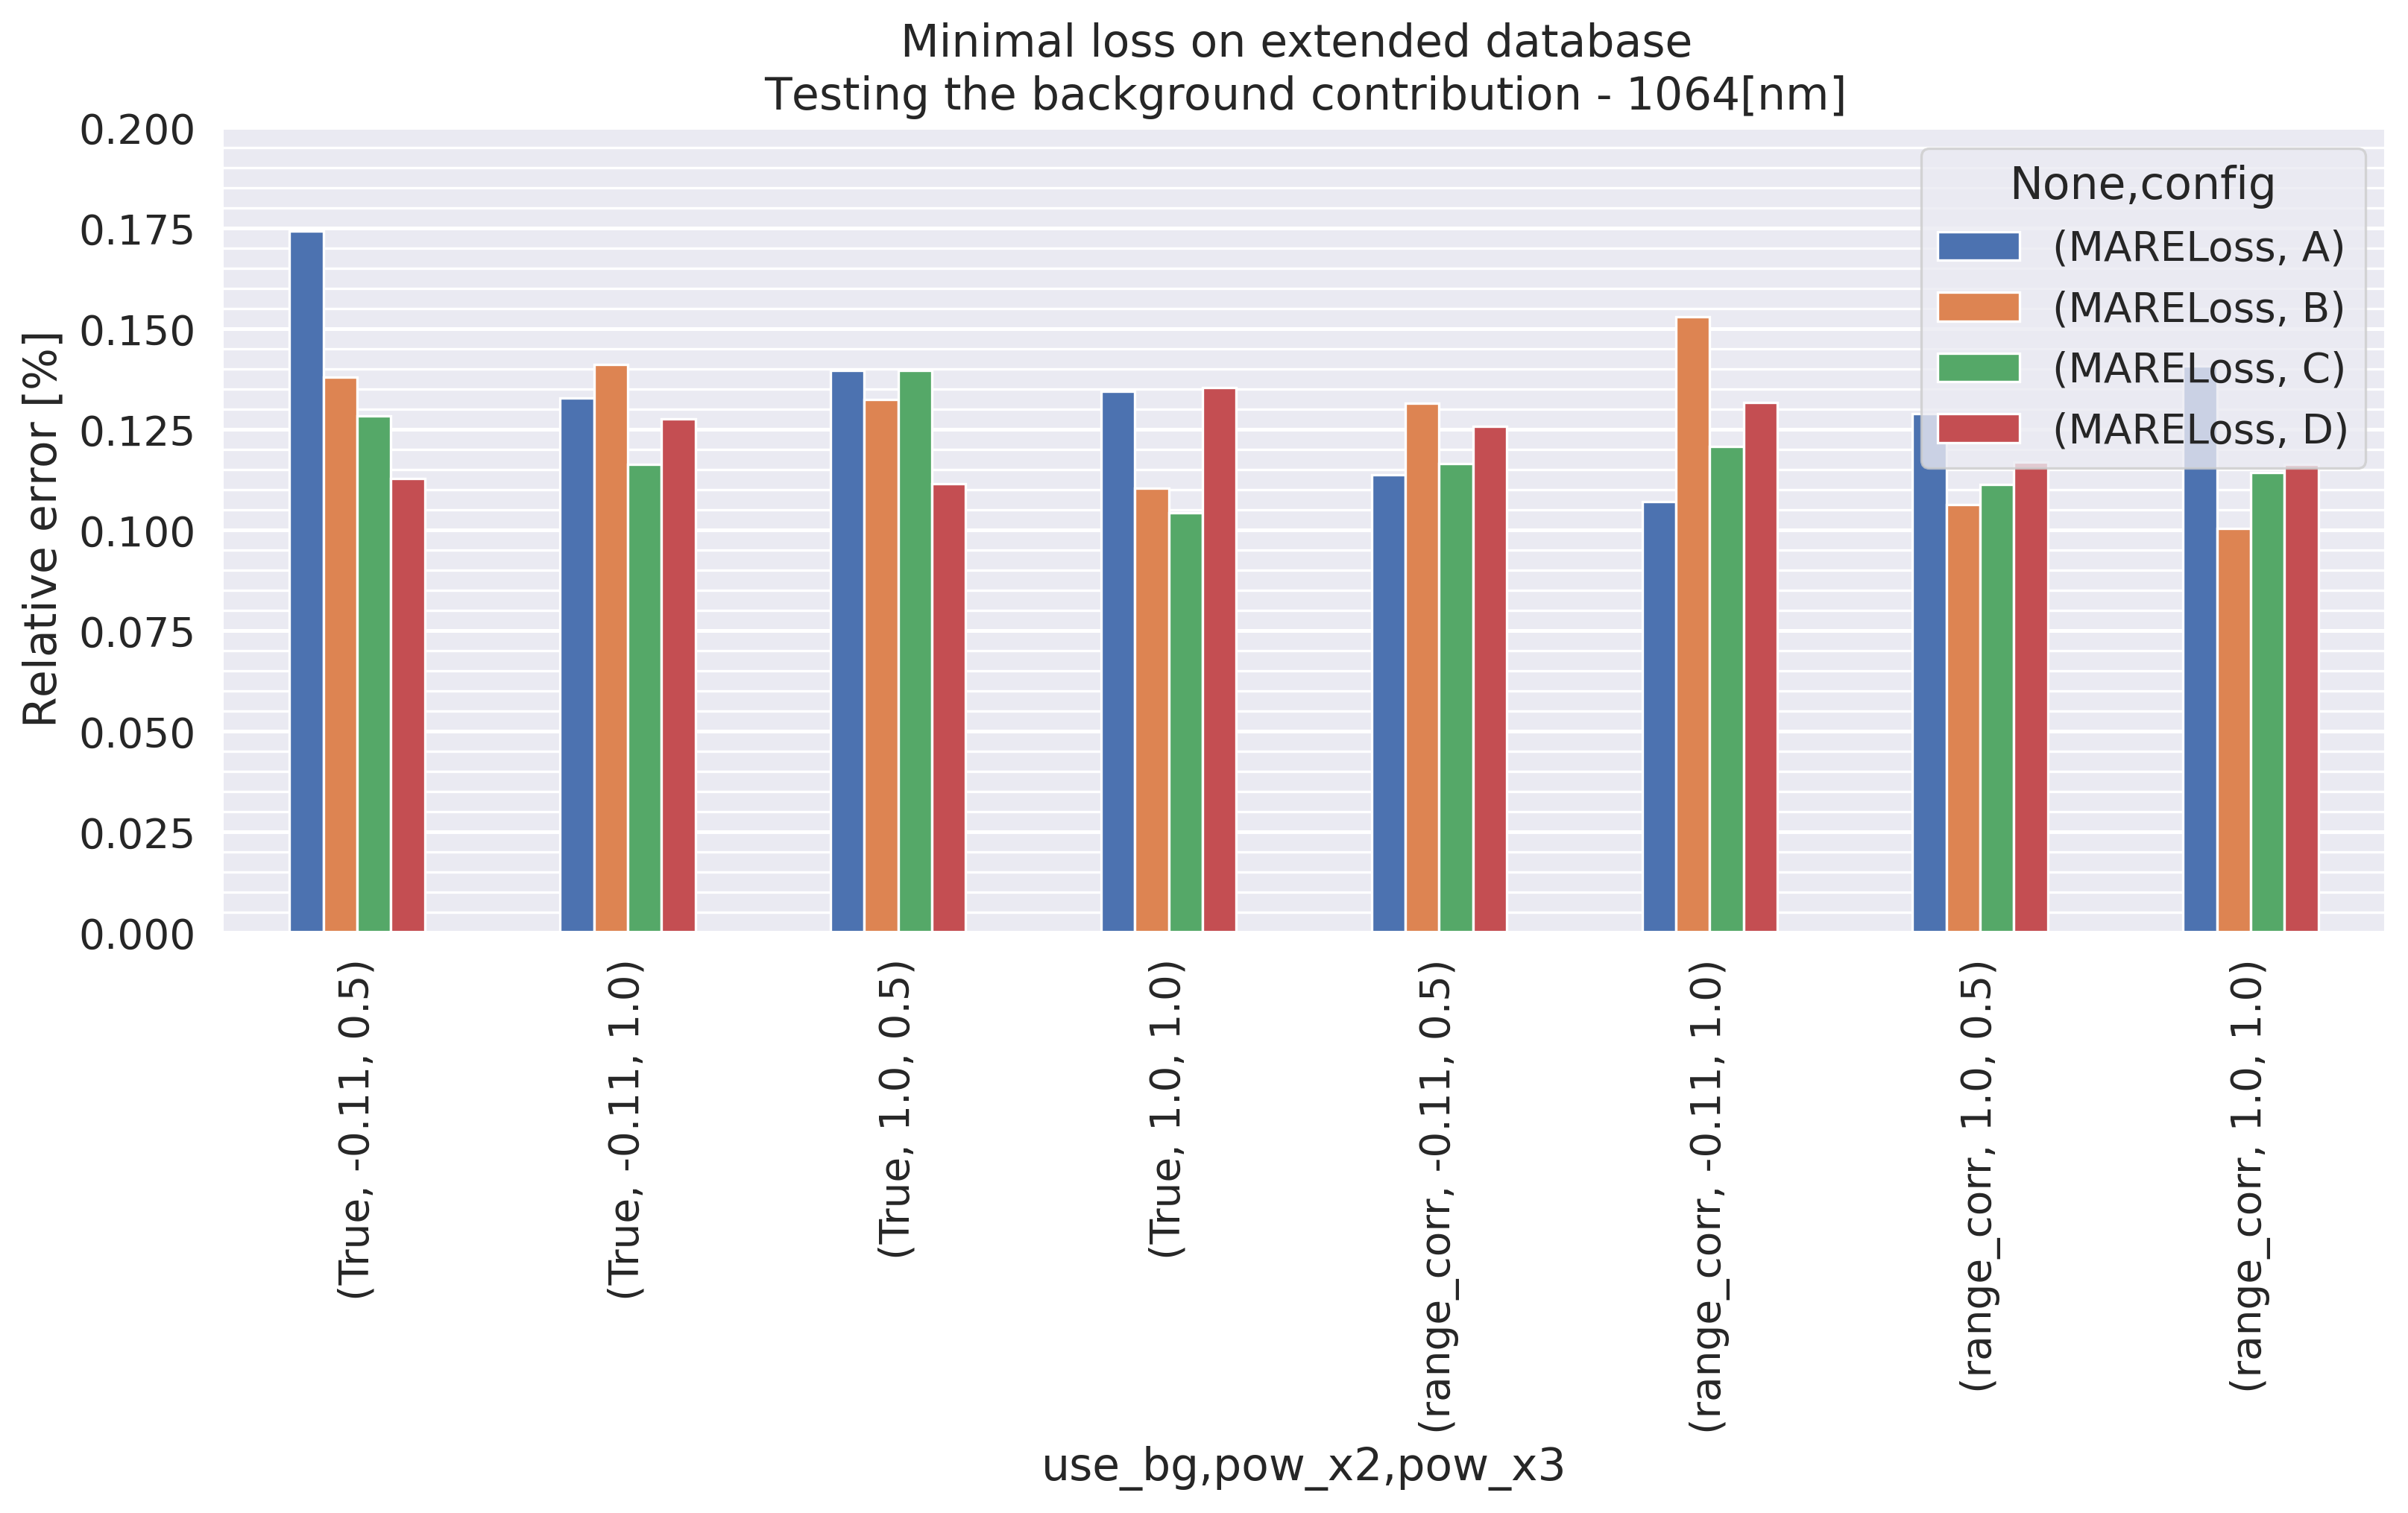

In [26]:
for wavelength in [355,532,1064]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 7))

    pd.pivot_table(all_wavs_configABCD
                   [all_wavs_configABCD.wavelength==wavelength],
                   values=['MARELoss'],
                   columns= ['config'],
                   index=['use_bg', 'pow_x2','pow_x3'],
                   aggfunc=np.min).\
        plot(kind='bar',ax =ax, title=f'Minimal loss on extended database \n'+fr'Testing the background contribution - ${wavelength}[\rm nm]$')
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='minor', color='w', linewidth=0.8)
    ax.grid(b=True, which='major', color='w', linewidth=1.2)
    ax.set_ylabel(r'Relative error $[\%]$')
    ax.xaxis.grid(False)
    ax.set_ylim([0.0, 0.2])
    plt.tight_layout()
    plt.show()

<ipython-input-27-f8727c8cfc7c>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power==False][all_wavs_configABCD.note=='extended_db'],


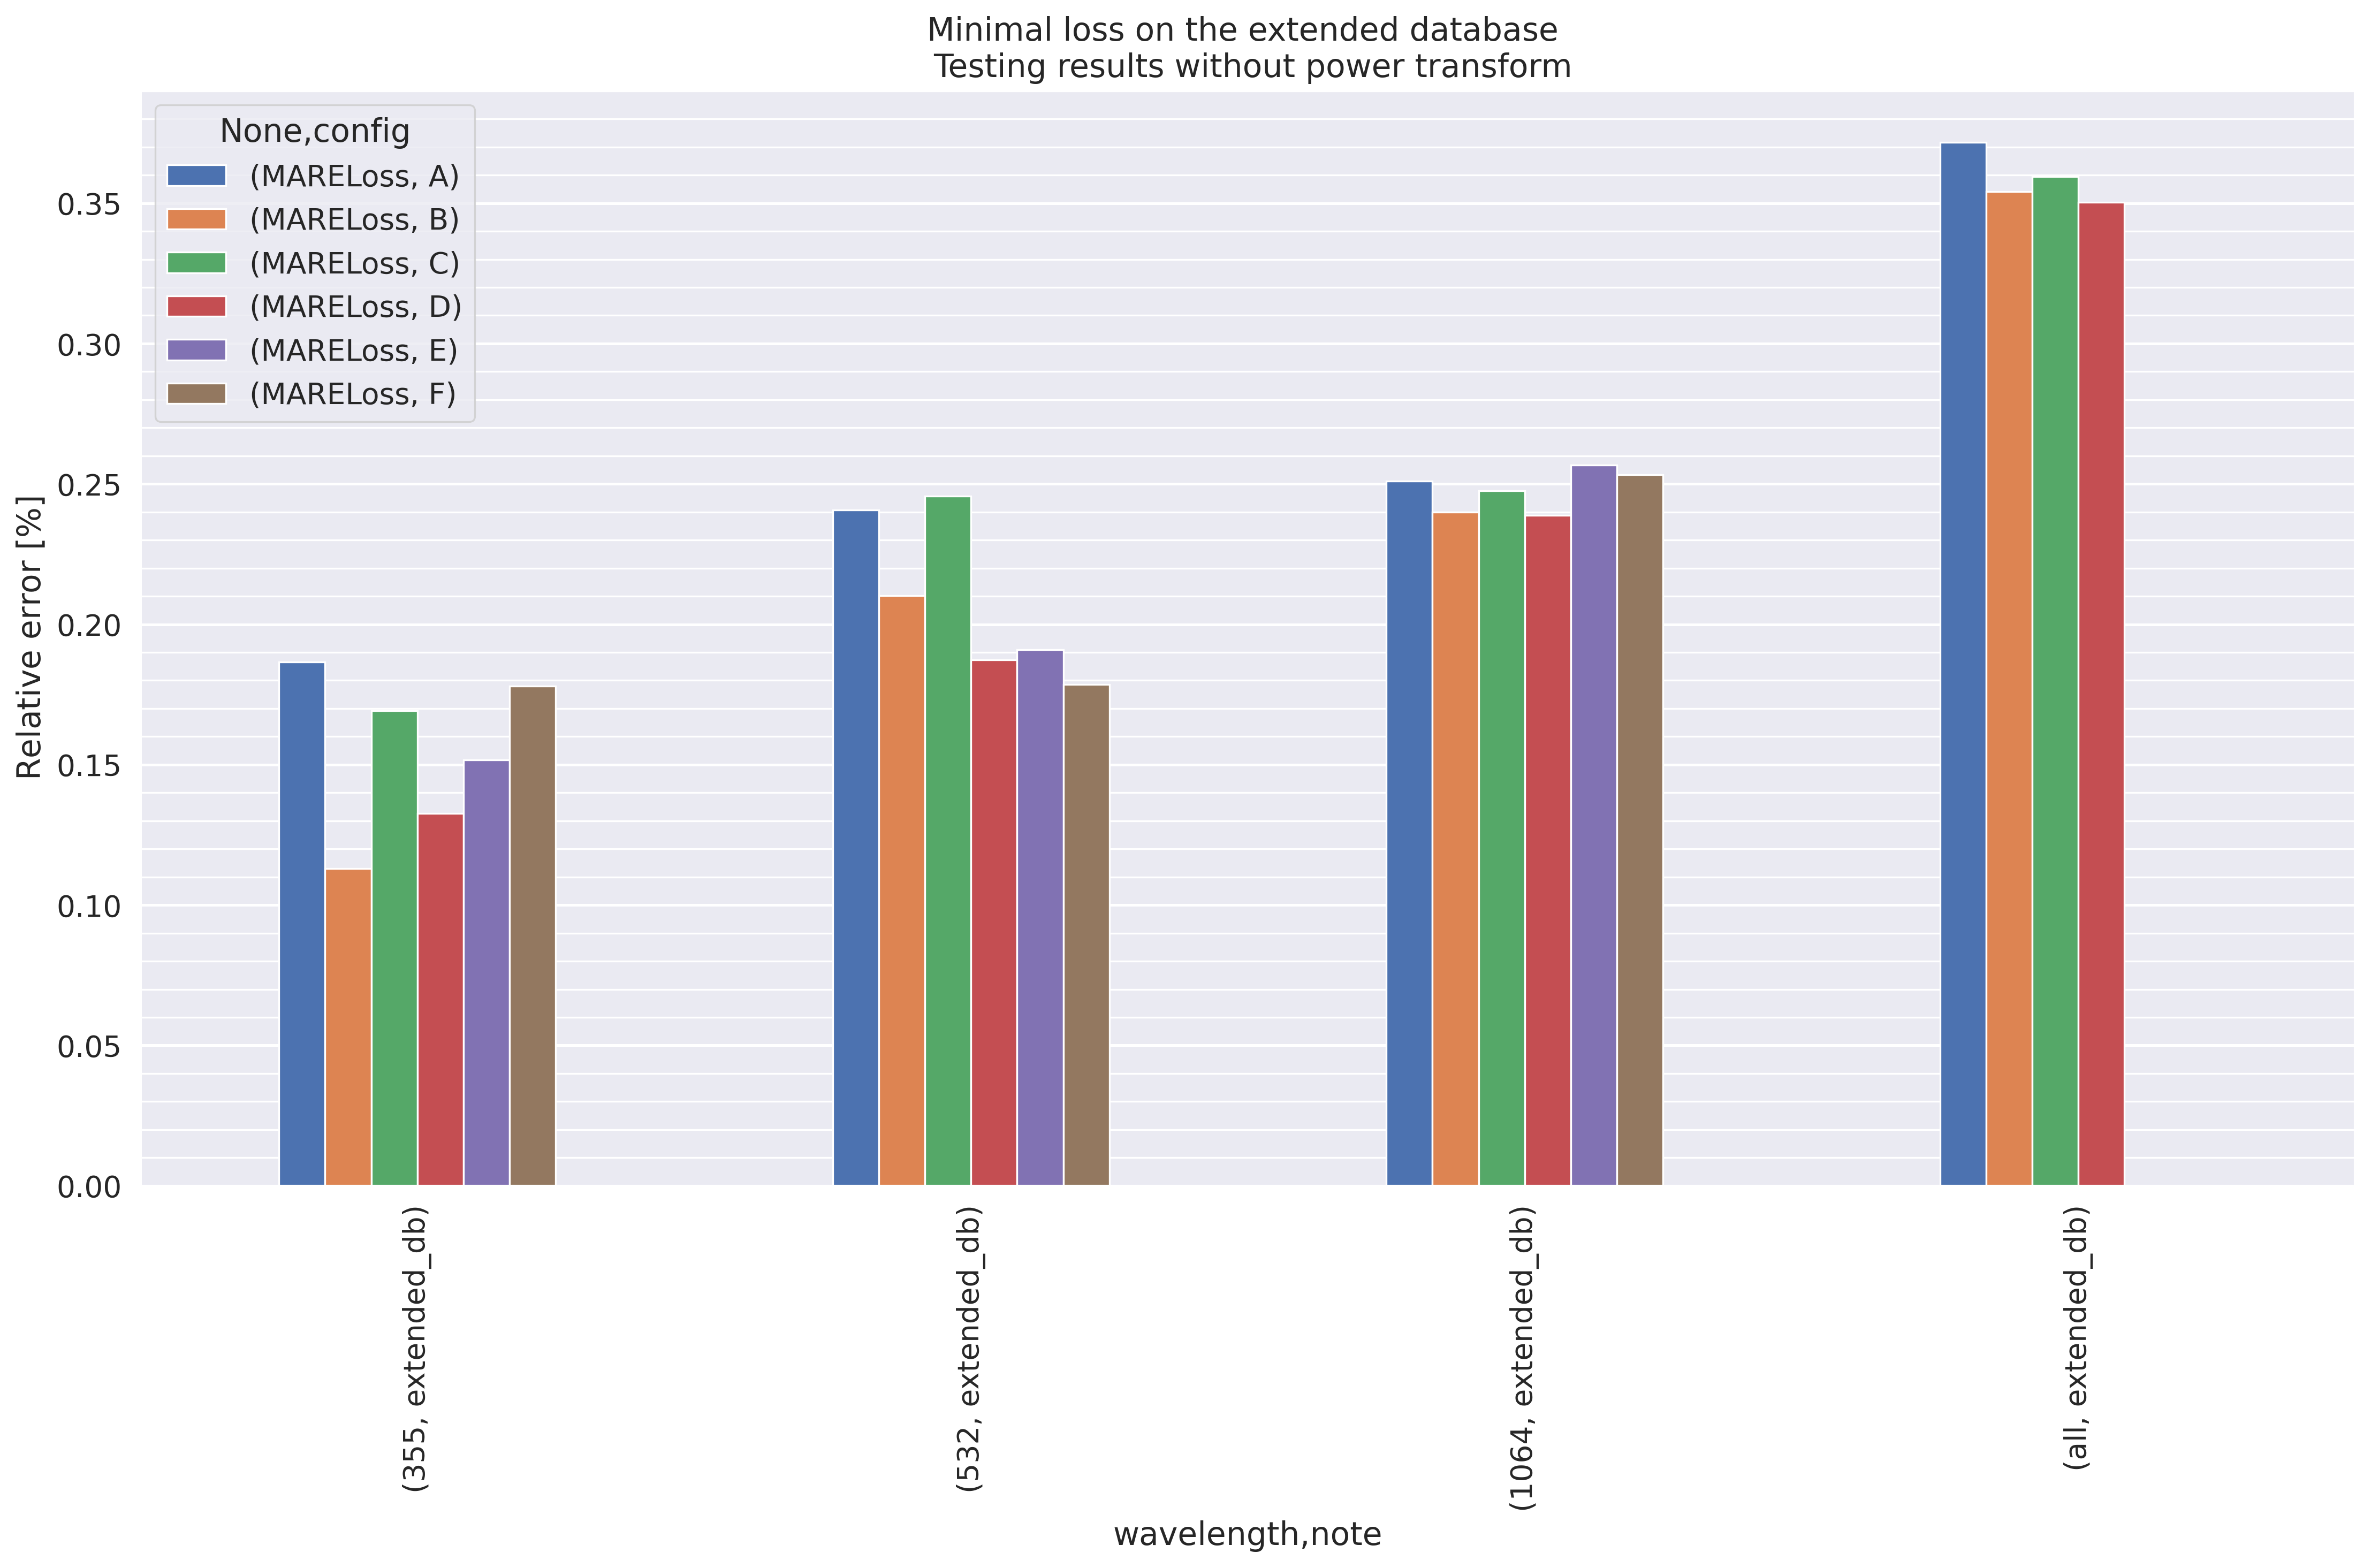

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

pd.pivot_table(all_wavs_configABCD[all_wavs_configABCD.use_power==False][all_wavs_configABCD.note=='extended_db'],
               values=['MARELoss'],
               columns= ['config'],
               index=['wavelength','note'],#'use_bg'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title='Minimal loss on the extended database \n Testing results without power transform')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.set_ylabel(r'Relative error $[\%]$')
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()